In [1]:
!pip install rasterio geopandas fiona

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 1.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 1.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 885.0 kB/s eta 0:00:00a 0:00:01


In [4]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import os

def clip_sentinel_data_with_mask(sentinel_dir, mask_shapefile, output_dir):
    """
    Clips all Sentinel-2 raster data within a specified directory
    using a given shapefile as a mask, handling CRS mismatches.

    Args:
        sentinel_dir (str): Path to the Sentinel-2 data directory (e.g., 'Sentinel2/GRANULE/L2A_T45QZG_A039169_20221222T043927/IMG_DATA').
        mask_shapefile (str): Path to the masking shapefile (e.g., 'ThanaArea.shp').
        output_dir (str): Directory where the clipped raster files will be saved.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Load the masking shapefile once
    try:
        mask_gdf_original = gpd.read_file(mask_shapefile)
        if mask_gdf_original.empty:
            print(f"Warning: Mask shapefile '{mask_shapefile}' is empty. No clipping will be performed.")
            return
        print(f"Mask shapefile loaded with CRS: {mask_gdf_original.crs}")
    except Exception as e:
        print(f"Error loading mask shapefile '{mask_shapefile}': {e}")
        return

    band_resolutions = {
        'R10m': ['B02', 'B03', 'B04', 'B08', 'AOT', 'TCI', 'WVP'],
        'R20m': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'TCI', 'WVP'],
        'R60m': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'TCI', 'WVP']
    }

    # Iterate through resolutions (R10m, R20m, R60m)
    for res_folder, bands in band_resolutions.items():
        current_res_dir = os.path.join(sentinel_dir, res_folder)
        if not os.path.exists(current_res_dir):
            print(f"Directory not found: {current_res_dir}. Skipping.")
            continue

        print(f"\nProcessing directory: {current_res_dir}")
        for band_file_name in os.listdir(current_res_dir):
            if band_file_name.endswith('.jp2') and any(band in band_file_name for band in bands):
                input_raster_path = os.path.join(current_res_dir, band_file_name)
                output_raster_path = os.path.join(output_dir, f"clipped_{band_file_name.replace('.jp2', '.tif')}") # Change output to .tif

                try:
                    with rasterio.open(input_raster_path) as src:
                        raster_crs = src.crs
                        print(f"  Raster: {band_file_name}, CRS: {raster_crs}")

                        # Reproject shapefile to raster's CRS if necessary, in memory
                        if raster_crs != mask_gdf_original.crs:
                            print(f"  CRS mismatch. Reprojecting mask to {raster_crs} in memory.")
                            mask_gdf_reprojected = mask_gdf_original.to_crs(raster_crs)
                            geometries_to_use = [geom for geom in mask_gdf_reprojected.geometry]
                        else:
                            geometries_to_use = [geom for geom in mask_gdf_original.geometry]

                        out_image, out_transform = mask(src, geometries_to_use, crop=True)

                        out_meta = src.meta.copy()
                        out_meta.update({
                            "driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform,
                            "nodata": src.nodata # Carry over nodata value
                        })

                        with rasterio.open(output_raster_path, "w", **out_meta) as dest:
                            dest.write(out_image)
                        print(f"  Successfully clipped: {band_file_name}")

                except ValueError as e:
                    if "Input shapes do not overlap raster" in str(e):
                        print(f"  Skipping {band_file_name}: Input shapes do not overlap raster. This Sentinel-2 tile does not cover your ThanaArea.")
                    else:
                        print(f"  Error clipping {band_file_name}: {e}")
                except rasterio.errors.RasterioIOError as e:
                    print(f"  Error opening {band_file_name}: {e}")
                except Exception as e:
                    print(f"  An unexpected error occurred with {band_file_name}: {e}")

# Define your paths
SENTINEL_DATA_ROOT = 'Sentinel2/GRANULE/L2A_T45QZG_A039169_20221222T043927/IMG_DATA'
THANA_AREA_SHAPEFILE = 'ThanaArea.shp'
OUTPUT_CLIPPED_DIR = 'SentinelRaster' # A new directory for batch output

# Run the batch clipping function
clip_sentinel_data_with_mask(SENTINEL_DATA_ROOT, THANA_AREA_SHAPEFILE, OUTPUT_CLIPPED_DIR)

Mask shapefile loaded with CRS: EPSG:4326

Processing directory: Sentinel2/GRANULE/L2A_T45QZG_A039169_20221222T043927/IMG_DATA/R10m
  Raster: T45QZG_20221222T043211_AOT_10m.jp2, CRS: EPSG:32645
  CRS mismatch. Reprojecting mask to EPSG:32645 in memory.
  Successfully clipped: T45QZG_20221222T043211_AOT_10m.jp2
  Raster: T45QZG_20221222T043211_B04_10m.jp2, CRS: EPSG:32645
  CRS mismatch. Reprojecting mask to EPSG:32645 in memory.
  Successfully clipped: T45QZG_20221222T043211_B04_10m.jp2
  Raster: T45QZG_20221222T043211_WVP_10m.jp2, CRS: EPSG:32645
  CRS mismatch. Reprojecting mask to EPSG:32645 in memory.
  Successfully clipped: T45QZG_20221222T043211_WVP_10m.jp2
  Raster: T45QZG_20221222T043211_TCI_10m.jp2, CRS: EPSG:32645
  CRS mismatch. Reprojecting mask to EPSG:32645 in memory.
  Successfully clipped: T45QZG_20221222T043211_TCI_10m.jp2
  Raster: T45QZG_20221222T043211_B02_10m.jp2, CRS: EPSG:32645
  CRS mismatch. Reprojecting mask to EPSG:32645 in memory.
  Successfully clipped: T45

In [5]:
import os
import shutil

def organize_clipped_rasters_by_resolution(clipped_data_dir):
    """
    Organizes clipped Sentinel-2 raster files into resolution-specific subfolders.

    Args:
        clipped_data_dir (str): The directory containing all the clipped raster files.
                                 (e.g., 'Clipped_Sentinel_Data_Batch')
    """

    resolutions = ['10m', '20m', '60m']

    # Create resolution subfolders if they don't exist
    for res in resolutions:
        res_folder_path = os.path.join(clipped_data_dir, res)
        os.makedirs(res_folder_path, exist_ok=True)
        print(f"Ensured directory exists: {res_folder_path}")

    # Iterate through all files in the clipped data directory
    for filename in os.listdir(clipped_data_dir):
        if filename.startswith('clipped_T45QZG_') and filename.endswith('.tif'):
            source_path = os.path.join(clipped_data_dir, filename)

            # Determine the resolution based on filename pattern
            # Example: clipped_T45QZG_20221222T043211_B04_10m.tif
            # We need to find '_10m', '_20m', or '_60m'
            if '_10m.tif' in filename:
                target_res_folder = '10m'
            elif '_20m.tif' in filename:
                target_res_folder = '20m'
            elif '_60m.tif' in filename:
                target_res_folder = '60m'
            else:
                print(f"Could not determine resolution for {filename}. Skipping.")
                continue

            destination_path = os.path.join(clipped_data_dir, target_res_folder, filename)

            try:
                shutil.move(source_path, destination_path)
                print(f"Moved: {filename} to {target_res_folder}/")
            except Exception as e:
                print(f"Error moving {filename}: {e}")

    print("\nRaster organization complete.")

# Define the directory where your clipped data is located
CLIPPED_OUTPUT_DIRECTORY = 'SentinelRaster'

# Run the organization function
organize_clipped_rasters_by_resolution(CLIPPED_OUTPUT_DIRECTORY)

Ensured directory exists: SentinelRaster/10m
Ensured directory exists: SentinelRaster/20m
Ensured directory exists: SentinelRaster/60m
Moved: clipped_T45QZG_20221222T043211_B11_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_B01_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_SCL_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_B03_10m.tif to 10m/
Moved: clipped_T45QZG_20221222T043211_SCL_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B02_10m.tif to 10m/
Moved: clipped_T45QZG_20221222T043211_B09_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_B11_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B01_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B03_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B12_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_B02_60m.tif to 60m/
Moved: clipped_T45QZG_20221222T043211_B12_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B02_20m.tif to 20m/
Moved: clipped_T45QZG_20221222T043211_B03_60m.tif to 

In [8]:
# Save this code as calculate_indices.py in your Five_Rivers/gis directory
# Make sure your current working directory is Five_Rivers/gis when you run it.

import rasterio
import numpy as np
import os

def calculate_and_save_index(band_dict, index_name, formula_func, output_dir, src_profile):
    """
    Calculates a single index and saves it as a GeoTIFF.

    Args:
        band_dict (dict): Dictionary with band names (e.g., 'B02') as keys
                          and their loaded numpy arrays as values.
        index_name (str): Name of the index (e.g., 'NDVI').
        formula_func (function): A lambda or function that takes band arrays
                                 and returns the calculated index array.
        output_dir (str): Directory to save the output.
        src_profile (dict): Rasterio profile (metadata) of the source band,
                            to be used for the output index raster.
    """
    try:
        index_array = formula_func(band_dict)
        # Ensure output is float32 and handle potential NaN values (e.g., from division by zero)
        index_array = index_array.astype(np.float32)
        index_array[np.isinf(index_array)] = np.nan # Replace inf with NaN

        output_path = os.path.join(output_dir, f"{index_name.lower()}.tif")

        # Update profile for the new index raster
        index_profile = src_profile.copy()
        index_profile.update({
            "dtype": 'float32',
            "count": 1, # Index is a single band
            "nodata": np.nan # Use NaN for no data
        })

        with rasterio.open(output_path, "w", **index_profile) as dst:
            dst.write(index_array, 1)
        print(f"  Successfully calculated and saved {index_name} to: {output_path}")

    except Exception as e:
        print(f"  Error calculating or saving {index_name}: {e}")


def calculate_10m_indices(clipped_10m_dir, output_indices_dir):
    """
    Calculates various common remote sensing indices from 10m Sentinel-2 bands.

    Args:
        clipped_10m_dir (str): Path to the directory containing clipped 10m bands.
                               (e.g., 'Clipped_Sentinel_Data_Batch/10m')
        output_indices_dir (str): Directory where the calculated indices will be saved.
    """
    print(f"Starting index calculation for 10m bands in: {clipped_10m_dir}")
    os.makedirs(output_indices_dir, exist_ok=True)

    band_files = {}
    band_data = {}
    src_profile = None # To store metadata from one of the bands

    # Load all required 10m bands
    for band_code in ['B02', 'B03', 'B04', 'B08']:
        # Construct filename pattern more accurately for clipped files
        filename_pattern = f"clipped_T45QZG_20221222T043211_{band_code}_10m.tif"
        band_path = os.path.join(clipped_10m_dir, filename_pattern)

        if not os.path.exists(band_path):
            print(f"  Warning: File not found for band {band_code} at {band_path}. Skipping indices requiring this band.")
            band_data[band_code] = None # Mark as missing
            continue

        print(f"  Loading {band_path}")

        try:
            with rasterio.open(band_path) as src:
                band_data[band_code] = src.read(1).astype(np.float32)
                # Sentinel-2 Level-2A data are typically scaled by 10000
                # Convert to reflectance [0-1] for index calculations
                band_data[band_code] /= 10000.0
                if src_profile is None:
                    src_profile = src.profile # Store profile from the first band loaded
        except Exception as e:
            print(f"  Error loading band {band_code} from {band_path}: {e}")
            band_data[band_code] = None # Mark as missing


    # --- Calculate Indices ---

    # NDVI
    if band_data.get('B08') is not None and band_data.get('B04') is not None:
        calculate_and_save_index(
            band_data, 'NDVI',
            lambda b: (b['B08'] - b['B04']) / (b['B08'] + b['B04']),
            output_indices_dir, src_profile
        )
    else:
        print("  Cannot calculate NDVI: Missing B08 or B04.")

    # NDWI (McFeeters)
    if band_data.get('B03') is not None and band_data.get('B08') is not None:
        calculate_and_save_index(
            band_data, 'NDWI',
            lambda b: (b['B03'] - b['B08']) / (b['B03'] + b['B08']),
            output_indices_dir, src_profile
        )
    else:
        print("  Cannot calculate NDWI: Missing B03 or B08.")

    # GNDVI
    if band_data.get('B08') is not None and band_data.get('B03') is not None:
        calculate_and_save_index(
            band_data, 'GNDVI',
            lambda b: (b['B08'] - b['B03']) / (b['B08'] + b['B03']),
            output_indices_dir, src_profile
        )
    else:
        print("  Cannot calculate GNDVI: Missing B08 or B03.")

    # EVI
    # Check for all required bands (B08, B04, B02)
    if (band_data.get('B08') is not None and
        band_data.get('B04') is not None and
        band_data.get('B02') is not None):
        calculate_and_save_index(
            band_data, 'EVI',
            lambda b: 2.5 * (b['B08'] - b['B04']) / (b['B08'] + 6 * b['B04'] - 7.5 * b['B02'] + 1),
            output_indices_dir, src_profile
        )
    else:
        print("  Cannot calculate EVI: Missing B08, B04, or B02.")

    # SAVI (using L=0.5)
    L_savi = 0.5 # Common value for L
    if band_data.get('B08') is not None and band_data.get('B04') is not None:
        calculate_and_save_index(
            band_data, 'SAVI',
            lambda b: (1 + L_savi) * (b['B08'] - b['B04']) / (b['B08'] + b['B04'] + L_savi),
            output_indices_dir, src_profile
        )
    else:
        print("  Cannot calculate SAVI: Missing B08 or B04.")

    print("\nAll 10m index calculations attempted.")


# --- Main execution block ---
if __name__ == "__main__":
    # Ensure these paths match your actual directory structure
    # They should be relative to where you run the script (e.g., Five_Rivers/gis)
    CLIPPED_10M_DIR = 'SentinelRaster/10m'
    OUTPUT_INDICES_DIR = 'SentinelRaster/Indices_10m'

    if not os.path.exists(CLIPPED_10M_DIR):
        print(f"Error: 10m clipped bands directory not found: {CLIPPED_10M_DIR}")
        print("Please ensure you have run the clipping and organization steps correctly.")
    else:
        calculate_10m_indices(CLIPPED_10M_DIR, OUTPUT_INDICES_DIR)

Starting index calculation for 10m bands in: SentinelRaster/10m
  Loading SentinelRaster/10m/clipped_T45QZG_20221222T043211_B02_10m.tif
  Loading SentinelRaster/10m/clipped_T45QZG_20221222T043211_B03_10m.tif
  Loading SentinelRaster/10m/clipped_T45QZG_20221222T043211_B04_10m.tif
  Loading SentinelRaster/10m/clipped_T45QZG_20221222T043211_B08_10m.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/1194498554.py:94: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B08'] - b['B04']) / (b['B08'] + b['B04']),


  Successfully calculated and saved NDVI to: SentinelRaster/Indices_10m/ndvi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/1194498554.py:104: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B03'] - b['B08']) / (b['B03'] + b['B08']),


  Successfully calculated and saved NDWI to: SentinelRaster/Indices_10m/ndwi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/1194498554.py:114: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B08'] - b['B03']) / (b['B08'] + b['B03']),


  Successfully calculated and saved GNDVI to: SentinelRaster/Indices_10m/gndvi.tif
  Successfully calculated and saved EVI to: SentinelRaster/Indices_10m/evi.tif
  Successfully calculated and saved SAVI to: SentinelRaster/Indices_10m/savi.tif

All 10m index calculations attempted.


In [10]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject # Explicitly import reproject
import numpy as np
import os
import shutil # Import shutil at the top level

def resample_band(input_path, output_path, target_resolution, target_transform, target_crs, target_shape):
    """Resamples a raster band to a target resolution, transform, and shape."""
    with rasterio.open(input_path) as src:
        # Read the band data and scale it immediately for consistency (0-1 reflectance)
        # Convert to float32 early to avoid potential dtype issues later
        source_array = src.read(1).astype(np.float32) / 10000.0

        # Check if resampling is actually needed
        # Note: Comparison of transforms should be done carefully,
        # here we rely on resolution match and a direct transform comparison which might be strict.
        # For simplicity, if resolution matches, we'll just save it, otherwise resample.
        if src.res == (target_resolution, target_resolution):
            print(f"    Band {os.path.basename(input_path)} already at target resolution ({target_resolution}m). Copying and scaling...")
            profile = src.profile.copy()
            profile.update({
                "dtype": 'float32', # Ensure output dtype is float32
                "nodata": np.nan    # Use NaN for no data
            })
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(source_array, 1) # Write the scaled array
            return source_array, profile # Return scaled data and profile

        print(f"    Resampling {os.path.basename(input_path)} from {src.res} to {target_resolution}...")
        
        # Prepare destination array explicitly as float32, as the final indices will be float32
        destination_array = np.empty(target_shape, dtype=np.float32)

        # Reproject and resample - source should be the actual scaled numpy array and its transform
        reproject(
            source=source_array, # Pass the actual scaled numpy array
            destination=destination_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear # Bilinear is good for continuous data like spectral bands
        )

        # Update profile for the new output
        profile = src.profile.copy()
        profile.update({
            'height': target_shape[0],
            'width': target_shape[1],
            'transform': target_transform,
            'crs': target_crs,
            'dtype': 'float32', # Ensure the output GeoTIFF's dtype is float32
            'nodata': np.nan,    # Explicitly set nodata for float
            'driver': 'GTiff'
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(destination_array, 1)

        return destination_array, profile

def calculate_and_save_index(band_arrays, index_name, formula_func, output_dir, reference_profile):
    """
    Calculates a single index and saves it as a GeoTIFF.
    Assumes band_arrays are already scaled to 0-1 reflectance.
    """
    try:
        index_array = formula_func(band_arrays)
        # Ensure output is float32 and handle potential NaN/Inf values
        index_array = index_array.astype(np.float32)
        index_array[np.isinf(index_array)] = np.nan # Replace inf with NaN

        output_path = os.path.join(output_dir, f"{index_name.lower()}.tif")

        # Update profile for the new index raster
        index_profile = reference_profile.copy()
        index_profile.update({
            "dtype": 'float32',
            "count": 1, # Index is a single band
            "nodata": np.nan # Use NaN for no data
        })

        with rasterio.open(output_path, "w", **index_profile) as dst:
            dst.write(index_array, 1)
        print(f"  Successfully calculated and saved {index_name} to: {output_path}")

    except Exception as e:
        print(f"  Error calculating or saving {index_name}: {e}")

def calculate_all_new_indices(base_clipped_dir, output_indices_dir):
    """
    Calculates various common remote sensing indices from 10m and resampled 20m Sentinel-2 bands.
    """
    print(f"Starting calculation of additional indices.")
    os.makedirs(output_indices_dir, exist_ok=True)

    bands_10m_dir = os.path.join(base_clipped_dir, '10m')
    bands_20m_dir = os.path.join(base_clipped_dir, '20m')

    if not os.path.exists(bands_10m_dir) or not os.path.exists(bands_20m_dir):
        print(f"Error: Required band directories (10m, 20m) not found under {base_clipped_dir}.")
        print("Please ensure you have run the clipping and organization steps correctly.")
        return

    loaded_bands = {}
    reference_profile = None # Will store profile from a 10m band to use for all outputs

    # --- Step 1: Load 10m bands and get reference profile ---
    required_10m_bands = ['B02', 'B03', 'B04', 'B08']
    for band_code in required_10m_bands:
        # Improved filename search to be more robust
        found_files = [f for f in os.listdir(bands_10m_dir) if f.startswith('clipped_T45QZG_') and f'_{band_code}_10m.tif' in f]
        if not found_files:
            print(f"  Error: No file found for band {band_code} in {bands_10m_dir}. Exiting.")
            return # Exit if crucial 10m bands are missing

        band_path = os.path.join(bands_10m_dir, found_files[0]) # Take the first match
        try:
            with rasterio.open(band_path) as src:
                loaded_bands[band_code] = src.read(1).astype(np.float32) / 10000.0 # Scale to reflectance
                if reference_profile is None:
                    reference_profile = src.profile.copy() # Store a copy of the 10m band's profile
                    # Remove nodata from reference_profile if it's not applicable to all bands equally
                    # or if we're setting new nodata later. For now, keep it as it's part of the base profile.
                    print(f"  Reference 10m profile established from {band_code}.")
        except Exception as e:
            print(f"  Error loading 10m band {band_code} from {band_path}: {e}")
            return # Exit if crucial 10m bands cannot be loaded

    # --- Step 2: Resample and Load 20m bands ---
    required_20m_bands = ['B11', 'B12'] # Core SWIR bands for these indices
    
    # Ensure a reference_profile was successfully obtained
    if reference_profile is None:
        print("  Could not establish a reference 10m profile. Cannot proceed with resampling.")
        return

    for band_code in required_20m_bands:
        # Improved filename search for 20m bands
        found_files = [f for f in os.listdir(bands_20m_dir) if f.startswith('clipped_T45QZG_') and f'_{band_code}_20m.tif' in f]
        if not found_files:
            print(f"  Error: No file found for band {band_code} in {bands_20m_dir}. Skipping indices requiring this band.")
            loaded_bands[band_code] = None # Mark as missing
            continue

        band_path = os.path.join(bands_20m_dir, found_files[0]) # Take the first match
        temp_resampled_path = os.path.join(output_indices_dir, f"resampled_{band_code}_10m_temp.tif")

        try:
            # Resample and get data array and its profile
            resampled_data, _ = resample_band( # We don't need the profile returned by resample_band here
                band_path,
                temp_resampled_path,
                target_resolution=reference_profile['transform'].a, # Get resolution from 10m band transform
                target_transform=reference_profile['transform'],
                target_crs=reference_profile['crs'],
                target_shape=(reference_profile['height'], reference_profile['width'])
            )
            loaded_bands[band_code] = resampled_data
            # You might want to remove temp_resampled_path here if you don't need them after loading
            # os.remove(temp_resampled_path)
        except Exception as e:
            print(f"  Error resampling or loading 20m band {band_code} from {band_path}: {e}")
            loaded_bands[band_code] = None # Mark as missing if error occurs


    # --- Step 3: Calculate New Indices ---
    # The lambda functions expect 'b' to be the dictionary of loaded_bands
    
    # MNDWI (Modified Normalized Difference Water Index)
    if loaded_bands.get('B03') is not None and loaded_bands.get('B11') is not None:
        calculate_and_save_index(
            loaded_bands, 'MNDWI',
            lambda b: (b['B03'] - b['B11']) / (b['B03'] + b['B11']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate MNDWI: Missing B03 or B11.")

    # NDBI (Normalized Difference Built-up Index)
    if loaded_bands.get('B11') is not None and loaded_bands.get('B08') is not None:
        calculate_and_save_index(
            loaded_bands, 'NDBI',
            lambda b: (b['B11'] - b['B08']) / (b['B11'] + b['B08']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate NDBI: Missing B11 or B08.")

    # NDBSI (Normalized Difference Bare Soil Index)
    if (loaded_bands.get('B11') is not None and loaded_bands.get('B04') is not None and
        loaded_bands.get('B08') is not None and loaded_bands.get('B02') is not None):
        calculate_and_save_index(
            loaded_bands, 'NDBSI',
            lambda b: ((b['B11'] + b['B04']) - (b['B08'] + b['B02'])) / ((b['B11'] + b['B04']) + (b['B08'] + b['B02'])),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate NDBSI: Missing B11, B04, B08, or B02.")

    # AWEI_NoShadow (Automated Water Extraction Index - No Shadow)
    if (loaded_bands.get('B02') is not None and loaded_bands.get('B03') is not None and
        loaded_bands.get('B08') is not None and loaded_bands.get('B11') is not None):
        calculate_and_save_index(
            loaded_bands, 'AWEI_NoShadow',
            lambda b: b['B02'] + 2.5 * b['B03'] - 1.5 * (b['B08'] + b['B11']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate AWEI_NoShadow: Missing B02, B03, B08, or B11.")

    # NDSI (Normalized Difference Soil Index - common variant using Green and SWIR1)
    if loaded_bands.get('B11') is not None and loaded_bands.get('B03') is not None:
        calculate_and_save_index(
            loaded_bands, 'NDSI',
            lambda b: (b['B11'] - b['B03']) / (b['B11'] + b['B03']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate NDSI: Missing B11 or B03.")

    print("\nAll new index calculations attempted.")


# --- Main execution block ---
if __name__ == "__main__":
    # Ensure this path points to your 'Clipped_Sentinel_Data_Batch' directory
    # where your '10m' and '20m' subfolders are located.
    # Based on your directory structure, it seems your 'Clipped_Sentinel_Data_Batch'
    # is actually named 'SentinelRaster' at the root of your project.
    CLIPPED_BASE_DIR = 'SentinelRaster' # Adjusted this path based on your provided structure
    
    # New directory to store all calculated 10m indices (including these new ones)
    OUTPUT_ALL_INDICES_DIR = os.path.join(CLIPPED_BASE_DIR, 'All_Calculated_Indices_10m')

    # To ensure the SentinelRaster/All_Calculated_Indices_10m directory exists correctly
    # If it was created directly under Clipped_Sentinel_Data_Batch before, it would be:
    # Clipped_Sentinel_Data_Batch/Indices_10m (old)
    # Clipped_Sentinel_Data_Batch/All_Calculated_Indices_10m (new target)
    # Your last output `SentinelRaster/SentinelRaster/All_Calculated_Indices_10m` indicates
    # `OUTPUT_ALL_INDICES_DIR` might be built on the *wrong* `CLIPPED_BASE_DIR` in the main block.
    # Let's fix that.

    # Correct path for where the *new* indices will be saved relative to your execution directory:
    # This should result in Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m
    ACTUAL_OUTPUT_DIR = os.path.join(os.getcwd(), 'SentinelRaster', 'All_Calculated_Indices_10m')


    calculate_all_new_indices(CLIPPED_BASE_DIR, ACTUAL_OUTPUT_DIR)

    print(f"\nCheck the '{ACTUAL_OUTPUT_DIR}' folder for your new index files.")

Starting calculation of additional indices.
  Reference 10m profile established from B02.
    Resampling clipped_T45QZG_20221222T043211_B11_20m.tif from (20.0, 20.0) to 10.0...
    Resampling clipped_T45QZG_20221222T043211_B12_20m.tif from (20.0, 20.0) to 10.0...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/771883675.py:175: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B03'] - b['B11']) / (b['B03'] + b['B11']),


  Successfully calculated and saved MNDWI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/mndwi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/771883675.py:185: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B11'] - b['B08']) / (b['B11'] + b['B08']),


  Successfully calculated and saved NDBI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndbi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/771883675.py:196: RuntimeWarning: invalid value encountered in divide
  lambda b: ((b['B11'] + b['B04']) - (b['B08'] + b['B02'])) / ((b['B11'] + b['B04']) + (b['B08'] + b['B02'])),


  Successfully calculated and saved NDBSI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndbsi.tif
  Successfully calculated and saved AWEI_NoShadow to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/awei_noshadow.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/771883675.py:217: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B11'] - b['B03']) / (b['B11'] + b['B03']),


  Successfully calculated and saved NDSI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndsi.tif

All new index calculations attempted.

Check the '/Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m' folder for your new index files.


In [11]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject # Explicitly import reproject
import numpy as np
import os
import shutil # Import shutil at the top level

def resample_band(input_path, output_path, target_resolution, target_transform, target_crs, target_shape):
    """Resamples a raster band to a target resolution, transform, and shape."""
    with rasterio.open(input_path) as src:
        # Read the band data and scale it immediately for consistency (0-1 reflectance)
        # Convert to float32 early to avoid potential dtype issues later
        source_array = src.read(1).astype(np.float32) / 10000.0

        # Check if resampling is actually needed
        if src.res == (target_resolution, target_resolution): # Simplified check for resolution match
            print(f"    Band {os.path.basename(input_path)} already at target resolution ({target_resolution}m). Copying and scaling...")
            profile = src.profile.copy()
            profile.update({
                "dtype": 'float32', # Ensure output dtype is float32
                "nodata": np.nan    # Use NaN for no data
            })
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(source_array, 1) # Write the scaled array
            return source_array, profile # Return scaled data and profile

        print(f"    Resampling {os.path.basename(input_path)} from {src.res} to {target_resolution}m...")
        
        # Prepare destination array explicitly as float32, as the final indices will be float32
        destination_array = np.empty(target_shape, dtype=np.float32)

        # Reproject and resample - source should be the actual scaled numpy array and its transform
        reproject(
            source=source_array, # Pass the actual scaled numpy array
            destination=destination_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear # Bilinear is good for continuous data like spectral bands
        )

        # Update profile for the new output
        profile = src.profile.copy()
        profile.update({
            'height': target_shape[0],
            'width': target_shape[1],
            'transform': target_transform,
            'crs': target_crs,
            'dtype': 'float32', # Ensure the output GeoTIFF's dtype is float32
            'nodata': np.nan,    # Explicitly set nodata for float
            'driver': 'GTiff'
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(destination_array, 1)

        return destination_array, profile

def calculate_and_save_index(band_arrays, index_name, formula_func, output_dir, reference_profile):
    """
    Calculates a single index and saves it as a GeoTIFF.
    Assumes band_arrays are already scaled to 0-1 reflectance.
    """
    try:
        index_array = formula_func(band_arrays)
        # Ensure output is float32 and handle potential NaN/Inf values
        index_array = index_array.astype(np.float32)
        index_array[np.isinf(index_array)] = np.nan # Replace inf with NaN

        output_path = os.path.join(output_dir, f"{index_name.lower()}.tif")

        # Update profile for the new index raster
        index_profile = reference_profile.copy()
        index_profile.update({
            "dtype": 'float32',
            "count": 1, # Index is a single band
            "nodata": np.nan # Use NaN for no data
        })

        with rasterio.open(output_path, "w", **index_profile) as dst:
            dst.write(index_array, 1)
        print(f"  Successfully calculated and saved {index_name} to: {output_path}")
        return index_array # Return the calculated array for further use

    except Exception as e:
        print(f"  Error calculating or saving {index_name}: {e}")
        return None # Return None if calculation fails

def calculate_all_new_indices(base_clipped_dir, output_indices_dir):
    """
    Calculates various common remote sensing indices from 10m and resampled 20m Sentinel-2 bands.
    """
    print(f"Starting calculation of additional indices.")
    os.makedirs(output_indices_dir, exist_ok=True)

    bands_10m_dir = os.path.join(base_clipped_dir, '10m')
    bands_20m_dir = os.path.join(base_clipped_dir, '20m')

    if not os.path.exists(bands_10m_dir) or not os.path.exists(bands_20m_dir):
        print(f"Error: Required band directories (10m, 20m) not found under {base_clipped_dir}.")
        print("Please ensure you have run the clipping and organization steps correctly.")
        return

    loaded_bands = {}
    reference_profile = None # Will store profile from a 10m band to use for all outputs

    # --- Step 1: Load 10m bands and get reference profile ---
    required_10m_bands = ['B02', 'B03', 'B04', 'B08']
    for band_code in required_10m_bands:
        found_files = [f for f in os.listdir(bands_10m_dir) if f.startswith('clipped_T45QZG_') and f'_{band_code}_10m.tif' in f]
        if not found_files:
            print(f"  Error: No file found for band {band_code} in {bands_10m_dir}. Exiting.")
            return

        band_path = os.path.join(bands_10m_dir, found_files[0])
        try:
            with rasterio.open(band_path) as src:
                loaded_bands[band_code] = src.read(1).astype(np.float32) / 10000.0
                if reference_profile is None:
                    reference_profile = src.profile.copy()
                    print(f"  Reference 10m profile established from {band_code}.")
        except Exception as e:
            print(f"  Error loading 10m band {band_code} from {band_path}: {e}")
            return

    # --- Step 2: Resample and Load 20m bands ---
    required_20m_bands = ['B11', 'B12'] # Core SWIR bands for these indices
    
    if reference_profile is None:
        print("  Could not establish a reference 10m profile. Cannot proceed with resampling.")
        return

    for band_code in required_20m_bands:
        found_files = [f for f in os.listdir(bands_20m_dir) if f.startswith('clipped_T45QZG_') and f'_{band_code}_20m.tif' in f]
        if not found_files:
            print(f"  Error: No file found for band {band_code} in {bands_20m_dir}. Skipping indices requiring this band.")
            loaded_bands[band_code] = None
            continue

        band_path = os.path.join(bands_20m_dir, found_files[0])
        temp_resampled_path = os.path.join(output_indices_dir, f"resampled_{band_code}_10m_temp.tif")

        try:
            resampled_data, _ = resample_band(
                band_path,
                temp_resampled_path,
                target_resolution=reference_profile['transform'].a,
                target_transform=reference_profile['transform'],
                target_crs=reference_profile['crs'],
                target_shape=(reference_profile['height'], reference_profile['width'])
            )
            loaded_bands[band_code] = resampled_data
        except Exception as e:
            print(f"  Error resampling or loading 20m band {band_code} from {band_path}: {e}")
            loaded_bands[band_code] = None


    # --- Step 3: Calculate Indices (ensure dependencies are met) ---

    # NDVI (re-calculate to ensure it's in loaded_bands for BUI)
    if loaded_bands.get('B08') is not None and loaded_bands.get('B04') is not None:
        ndvi_array = calculate_and_save_index(
            loaded_bands, 'NDVI',
            lambda b: (b['B08'] - b['B04']) / (b['B08'] + b['B04']),
            output_indices_dir, reference_profile
        )
        if ndvi_array is not None:
            loaded_bands['NDVI'] = ndvi_array # Store the calculated NDVI array
    else:
        print("  Cannot calculate NDVI: Missing B08 or B04.")

    # MNDWI (Modified Normalized Difference Water Index)
    if loaded_bands.get('B03') is not None and loaded_bands.get('B11') is not None:
        calculate_and_save_index(
            loaded_bands, 'MNDWI',
            lambda b: (b['B03'] - b['B11']) / (b['B03'] + b['B11']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate MNDWI: Missing B03 or B11.")

    # NDBI (Normalized Difference Built-up Index)
    if loaded_bands.get('B11') is not None and loaded_bands.get('B08') is not None:
        ndbi_array = calculate_and_save_index(
            loaded_bands, 'NDBI',
            lambda b: (b['B11'] - b['B08']) / (b['B11'] + b['B08']),
            output_indices_dir, reference_profile
        )
        if ndbi_array is not None:
            loaded_bands['NDBI'] = ndbi_array # Store the calculated NDBI array
    else:
        print("  Cannot calculate NDBI: Missing B11 or B08.")

    # UI (Urban Index)
    if loaded_bands.get('B12') is not None and loaded_bands.get('B08') is not None:
        calculate_and_save_index(
            loaded_bands, 'UI',
            lambda b: (b['B12'] - b['B08']) / (b['B12'] + b['B08']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate UI: Missing B12 or B08.")

    # NDBSI (Normalized Difference Bare Soil Index)
    if (loaded_bands.get('B11') is not None and loaded_bands.get('B04') is not None and
        loaded_bands.get('B08') is not None and loaded_bands.get('B02') is not None):
        calculate_and_save_index(
            loaded_bands, 'NDBSI',
            lambda b: ((b['B11'] + b['B04']) - (b['B08'] + b['B02'])) / ((b['B11'] + b['B04']) + (b['B08'] + b['B02'])),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate NDBSI: Missing B11, B04, B08, or B02.")

    # AWEI_NoShadow (Automated Water Extraction Index - No Shadow)
    if (loaded_bands.get('B02') is not None and loaded_bands.get('B03') is not None and
        loaded_bands.get('B08') is not None and loaded_bands.get('B11') is not None):
        calculate_and_save_index(
            loaded_bands, 'AWEI_NoShadow',
            lambda b: b['B02'] + 2.5 * b['B03'] - 1.5 * (b['B08'] + b['B11']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate AWEI_NoShadow: Missing B02, B03, B08, or B11.")

    # NDSI (Normalized Difference Soil Index - common variant using Green and SWIR1)
    if loaded_bands.get('B11') is not None and loaded_bands.get('B03') is not None:
        calculate_and_save_index(
            loaded_bands, 'NDSI',
            lambda b: (b['B11'] - b['B03']) / (b['B11'] + b['B03']),
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate NDSI: Missing B11 or B03.")

    # BUI (Built-up Index) - Calculated LAST as it depends on NDBI and NDVI
    if loaded_bands.get('NDBI') is not None and loaded_bands.get('NDVI') is not None:
        calculate_and_save_index(
            loaded_bands, 'BUI',
            lambda b: b['NDBI'] - b['NDVI'],
            output_indices_dir, reference_profile
        )
    else:
        print("  Cannot calculate BUI: Missing NDBI or NDVI (ensure they were calculated first).")


    print("\nAll new index calculations attempted.")


# --- Main execution block ---
if __name__ == "__main__":
    # Ensure this path points to your 'SentinelRaster' directory
    # which contains '10m', '20m', and '60m' subfolders.
    CLIPPED_BASE_DIR = 'SentinelRaster' # Based on your provided directory structure
    
    # This will create a directory at Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m
    ACTUAL_OUTPUT_DIR = os.path.join(os.getcwd(), 'SentinelRaster', 'All_Calculated_Indices_10m')

    calculate_all_new_indices(CLIPPED_BASE_DIR, ACTUAL_OUTPUT_DIR)

    print(f"\nCheck the '{ACTUAL_OUTPUT_DIR}' folder for all your 10m-resolution index files (including NDVI, NDBI, BUI, UI, etc.).")

Starting calculation of additional indices.
  Reference 10m profile established from B02.
    Resampling clipped_T45QZG_20221222T043211_B11_20m.tif from (20.0, 20.0) to 10.0m...
    Resampling clipped_T45QZG_20221222T043211_B12_20m.tif from (20.0, 20.0) to 10.0m...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:165: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B08'] - b['B04']) / (b['B08'] + b['B04']),


  Successfully calculated and saved NDVI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndvi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:177: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B03'] - b['B11']) / (b['B03'] + b['B11']),


  Successfully calculated and saved MNDWI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/mndwi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:187: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B11'] - b['B08']) / (b['B11'] + b['B08']),


  Successfully calculated and saved NDBI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndbi.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:199: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B12'] - b['B08']) / (b['B12'] + b['B08']),


  Successfully calculated and saved UI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ui.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:210: RuntimeWarning: invalid value encountered in divide
  lambda b: ((b['B11'] + b['B04']) - (b['B08'] + b['B02'])) / ((b['B11'] + b['B04']) + (b['B08'] + b['B02'])),


  Successfully calculated and saved NDBSI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndbsi.tif
  Successfully calculated and saved AWEI_NoShadow to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/awei_noshadow.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6253/2597079784.py:231: RuntimeWarning: invalid value encountered in divide
  lambda b: (b['B11'] - b['B03']) / (b['B11'] + b['B03']),


  Successfully calculated and saved NDSI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/ndsi.tif
  Successfully calculated and saved BUI to: /Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m/bui.tif

All new index calculations attempted.

Check the '/Users/rakibhhridoy/Research/Five_Rivers/gis/SentinelRaster/All_Calculated_Indices_10m' folder for all your 10m-resolution index files (including NDVI, NDBI, BUI, UI, etc.).


In [6]:
import rasterio
import geopandas as gpd
from pysheds.grid import Grid
import numpy as np
import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points as shapely_nearest_points # For robust snapping

# --- Configuration ---
# File paths (UPDATE THESE TO YOUR ACTUAL FILE PATHS)
DEM_PATH = 'SentinelRaster/Indices/DEMF.tif'
SAMPLING_POINTS_PATH = 'sampling_point.shp'
BRICK_FIELDS_PATH = 'brick_field_point.shp'
INDUSTRIES_PATH = 'industry_point.shp'

# Hydrological parameters
STREAM_ACCUMULATION_THRESHOLD = 500 # Adjust this based on your DEM and desired stream density
                                    # Higher value = fewer, larger streams
# --- End Configuration ---

print("Starting data generation for hydrological and graph-based features...")

# --- 1. Load Data ---
print("\n1. Loading geospatial data...")
try:
    # Load DEM with pysheds
    grid = Grid.from_raster(DEM_PATH)
    dem = grid.read_raster(DEM_PATH) # Get the raw DEM data

    # Load point GeoDataFrames
    sampling_points = gpd.read_file(SAMPLING_POINTS_PATH)
    brick_fields = gpd.read_file(BRICK_FIELDS_PATH)
    industries = gpd.read_file(INDUSTRIES_PATH)

    # --- CRS Check and Reprojection (CRITICAL) ---
    # Get CRS from DEM directly using rasterio
    with rasterio.open(DEM_PATH) as src:
        dem_crs = src.crs
    print(f"DEM CRS: {dem_crs.to_string()}") # Use .to_string() for a common representation

    if dem_crs.is_projected:
        print("This DEM uses a Projected Coordinate System (PCS).")
        print(f"Units are typically linear (e.g., meters or feet) for PCS.")
    elif dem_crs.is_geographic:
        print("This DEM uses a Geographic Coordinate System (GCS).")
        print(f"Units are typically angular (degrees) for GCS.")
    else:
        print("CRS type unknown (neither projected nor geographic).")

    # Ensure all GeoDataFrames have the same CRS as the DEM
    if sampling_points.crs != dem_crs:
        print(f"Reprojecting sampling points from {sampling_points.crs.to_string()} to {dem_crs.to_string()}")
        sampling_points = sampling_points.to_crs(dem_crs)
    if brick_fields.crs != dem_crs:
        print(f"Reprojecting brick fields from {brick_fields.crs.to_string()} to {dem_crs.to_string()}")
        brick_fields = brick_fields.to_crs(dem_crs)
    if industries.crs != dem_crs:
        print(f"Reprojecting industries from {industries.crs.to_string()} to {dem_crs.to_string()}")
        industries = industries.to_crs(dem_crs)

    print("All data loaded and CRS checked/reprojected.")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure file paths are correct and data are valid geospatial files.")
    exit()

# --- 2. Hydrological Pre-processing with pysheds ---
print("\n2. Performing hydrological analysis (filling depressions, flow direction, accumulation)...")
try:
    dem_filled = grid.fill_depressions(dem)
    dem_inflated = grid.resolve_flats(dem_filled) # Addresses flat areas

    fdir = grid.flowdir(dem_inflated)
    acc = grid.accumulation(fdir)
    streams_raster = acc > STREAM_ACCUMULATION_THRESHOLD
    branches = grid.extract_river_network(fdir, streams_raster)

    stream_lines = []
    for branch in branches['features']:
        line = LineString(branch['geometry']['coordinates'])
        stream_lines.append(line)

    stream_gdf = gpd.GeoDataFrame(geometry=stream_lines, crs=dem_crs)
    print(f"Stream network extracted with {len(stream_gdf)} segments.")

except Exception as e:
    print(f"Error during hydrological processing: {e}")
    exit()

# --- 3. Prepare All Points for Graph Analysis ---
print("\n3. Preparing and snapping points to the stream network...")

all_points_combined = pd.concat([
    sampling_points.assign(type='sampling', original_idx=sampling_points.index),
    brick_fields.assign(type='brick_field', original_idx=brick_fields.index),
    industries.assign(type='industry', original_idx=industries.index)
]).reset_index(drop=True)

snapped_geoms = []
for idx, row in all_points_combined.iterrows():
    point_geom = row.geometry
    # If stream_gdf is empty or contains no valid geometry, nearest_points will fail
    if stream_gdf.empty or not stream_gdf.geometry.is_valid.any():
        print("Warning: Stream network is empty or invalid. Cannot snap points. Keeping original geometry.")
        snapped_geoms.append(point_geom) # Keep original if cannot snap
        continue

    # Create a unary union of all stream geometries for efficient snapping
    try:
        # --- MODIFICATION: Replace unary_union attribute with union_all() method ---
        unary_stream_geometry = stream_gdf.geometry.union_all()
        # --- END MODIFICATION ---

        if unary_stream_geometry.is_empty:
            print("Warning: Union of stream geometries is empty. Cannot snap points. Keeping original geometry.")
            snapped_geoms.append(point_geom) # Keep original if cannot snap
            continue

        # Find the closest point on the nearest stream line
        _, snapped_point_on_stream = shapely_nearest_points(unary_stream_geometry, point_geom)
        snapped_geoms.append(snapped_point_on_stream)
    except Exception as e:
        print(f"Warning: Could not snap point {idx} to stream network due to: {e}. Keeping original point geometry.")
        snapped_geoms.append(point_geom)


all_points_snapped = all_points_combined.copy()
all_points_snapped['geometry'] = snapped_geoms

print(f"Total points (sampling, brick fields, industries) snapped: {len(all_points_snapped)}")

Starting data generation for hydrological and graph-based features...

1. Loading geospatial data...
DEM CRS: EPSG:4326
This DEM uses a Geographic Coordinate System (GCS).
Units are typically angular (degrees) for GCS.
All data loaded and CRS checked/reprojected.

2. Performing hydrological analysis (filling depressions, flow direction, accumulation)...


/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


Stream network extracted with 4537 segments.

3. Preparing and snapping points to the stream network...
Total points (sampling, brick fields, industries) snapped: 482


In [13]:
import rasterio.transform # Make sure rasterio.transform is imported for rowcol function

# --- IMPORTANT ASSUMPTION ---
# This code assumes that the following variables from previous sections are
# already defined and available in your current environment (e.g., Jupyter cell output):
# - grid (pysheds Grid object)
# - dem (raw DEM data)
# - fdir (flow direction raster data)
# - acc (flow accumulation raster data)
# - dem_crs (CRS of the DEM and reprojected points)
# - sampling_points (GeoDataFrame of sampling points, with original_idx)
# - brick_fields (GeoDataFrame of brick fields, with original_idx)
# - industries (GeoDataFrame of industries, with original_idx)
# - all_points_snapped (GeoDataFrame of all combined and snapped points)
# ----------------------------

# --- D8 Flow Direction Mapping (EXPLICITLY DEFINED) ---
# This dictionary maps flow direction values (from pysheds fdir output)
# to (row_offset, col_offset) for the next cell.
# This is crucial if grid.dirmap is not directly accessible.
D8_DIRMAP = {
    1: (0, 1),    # East
    2: (1, 1),    # Southeast
    4: (1, 0),    # South
    8: (1, -1),   # Southwest
    16: (0, -1),  # West
    32: (-1, -1), # Northwest
    64: (-1, 0),  # North
    128: (-1, 1)  # Northeast
}
# --- END EXPLICIT DIRMAP ---

# Hydrological parameter (needs to be consistent if not in global scope)
STREAM_ACCUMULATION_THRESHOLD = 500 # Ensure this matches your first cell's value

# --- 4. Construct the Hydrological Graph with NetworkX ---
print("\n4. Building the hydrological graph...")

G = nx.DiGraph()

# Add all snapped points as nodes to the graph first
for idx, row in all_points_snapped.iterrows():
    G.add_node(idx, geometry=row.geometry, type=row['type'], original_idx=row['original_idx'])

rows_dem, cols_dem = fdir.shape # Use fdir shape for raster dimensions
stream_cell_nodes_map = {}

# Get array of stream cells (row, col)
stream_r, stream_c = np.where(acc >= STREAM_ACCUMULATION_THRESHOLD)

# Add stream cells as nodes and connect them based on flow direction
for r, c in zip(stream_r, stream_c):
    cell_node_id = f'cell_{r}_{c}'
    stream_cell_nodes_map[(r, c)] = cell_node_id

    # Get the affine transform from the grid
    transform = grid.affine
    
    # Calculate the centroid coordinates of the cell (r, c)
    x_coord, y_coord = transform * (c + 0.5, r + 0.5)

    cell_point_geometry = Point(x_coord, y_coord)

    if cell_node_id not in G: # Ensure node is added only once
        G.add_node(cell_node_id, geometry=cell_point_geometry, type='stream_cell')

    # Determine the next cell in the flow direction using the explicit D8_DIRMAP
    flow_direction_value = fdir[r, c]
    if flow_direction_value in D8_DIRMAP: # Use the explicitly defined dirmap
        dr, dc = D8_DIRMAP[flow_direction_value] # Get row/col offsets
        next_r, next_c = r + dr, c + dc
    else:
        # If flow_direction_value is not in D8_DIRMAP (e.g., it's a sink or invalid value)
        # then there's no defined downstream cell from this point.
        # We can continue to the next iteration of the loop, as no edge can be formed.
        continue # Skip to the next stream cell if flow direction is invalid

    # Check if the next cell is within bounds and also part of the extracted stream network
    if (0 <= next_r < rows_dem and 0 <= next_c < cols_dem and
            acc[next_r, next_c] >= STREAM_ACCUMULATION_THRESHOLD):
        
        next_cell_node_id = f'cell_{next_r}_{next_c}'
        
        # Calculate coordinates for the next cell
        x_next_coord, y_next_coord = transform * (next_c + 0.5, next_r + 0.5)

        next_cell_point_geometry = Point(x_next_coord, y_next_coord)

        if next_cell_node_id not in G: # Add next cell node if it doesn't exist
            G.add_node(next_cell_node_id, geometry=next_cell_point_geometry, type='stream_cell')

        # Calculate weight (distance between cell centers)
        weight = np.sqrt( (x_coord - x_next_coord)**2 + (y_coord - y_next_coord)**2 )
        # Add a small epsilon weight if distance is zero (e.g., same cell, though unlikely for distinct flow cells)
        if weight == 0:
            weight = grid.resolution # Use grid resolution as a fallback or minimal distance

        G.add_edge(cell_node_id, next_cell_node_id, weight=weight)

# --- Diagnostic Prints for Graph Structure ---
print(f"Graph initialization check: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
if G.number_of_nodes() > 0:
    print(f"Sample node data (first 3):")
    for i, (node_id, data) in enumerate(G.nodes(data=True)):
        if i >= 3: break
        print(f"  Node ID: {node_id}, Type: {data.get('type')}, Geometry: {data.get('geometry')}")
if G.number_of_edges() > 0:
    print(f"Sample edge data (first 3):")
    for i, (u, v, data) in enumerate(G.edges(data=True)):
        if i >= 3: break
        print(f"  Edge: {u} -> {v}, Weight: {data.get('weight')}")
# --- End Diagnostic Prints ---


# Connect the snapped points to the closest stream cell node in the graph
epsilon_weight = 0.001 # A very small weight for the connection between the snapped point and stream cell

# Pre-collect stream cell geometries for efficient distance calculation
# This creates a list of (stream_cell_node_id, stream_cell_geometry) tuples
stream_cell_graph_nodes = []
for (r, c), cell_id in stream_cell_nodes_map.items():
    if cell_id in G: # Ensure the node was actually added to G
        stream_cell_graph_nodes.append((cell_id, G.nodes[cell_id]['geometry']))


for node_idx, data in all_points_snapped.iterrows():
    point_geom = data['geometry']
    
    closest_stream_node_id = None
    min_dist_to_stream_node = float('inf')

    # Find the closest *existing* stream cell node in the graph to the snapped point
    for stream_cell_id, stream_cell_geometry in stream_cell_graph_nodes:
        dist = point_geom.distance(stream_cell_geometry)
        if dist < min_dist_to_stream_node:
            min_dist_to_stream_node = dist
            closest_stream_node_id = stream_cell_id

    if closest_stream_node_id: # If a closest stream node was found
        # Add bidirectional edges with small weight
        G.add_edge(node_idx, closest_stream_node_id, weight=epsilon_weight)
        G.add_edge(closest_stream_node_id, node_idx, weight=epsilon_weight)
        # print(f"Connected point {node_idx} (type: {data['type']}) to stream node {closest_stream_node_id} with distance {min_dist_to_stream_node:.2f}")
    else:
        # This warning is more critical now, means no stream cell node was found near the snapped point
        print(f"CRITICAL Warning: Snapped point {node_idx} (type: {data['type']}, original_idx: {data['original_idx']}) could not be connected to any stream cell node in the graph. It might be isolated.")


print(f"Hydrological graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"Connectivity check: Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Connectivity check: Is the graph weakly connected? {nx.is_weakly_connected(G)}")


# --- 5. Calculate Graph-Based Distances and Features ---
print("\n5. Calculating graph-based distance features...")

results_df = pd.DataFrame(index=sampling_points.index)

# Filter for the graph nodes that represent sources and sampling points
source_nodes = [node for node, data in G.nodes(data=True) if data['type'] in ['brick_field', 'industry']]
sampling_node_map = {data['original_idx']: node for node, data in G.nodes(data=True) if data['type'] == 'sampling'}

print(f"Total source nodes identified in graph: {len(source_nodes)}")
print(f"Total sampling nodes identified in graph: {len(sampling_node_map)}")

for original_sampling_idx, s_node_graph_id in sampling_node_map.items():
    
    dist_to_nearest_bf = np.nan
    num_upstream_bf = 0
    dist_to_nearest_ind = np.nan
    num_upstream_ind = 0

    print(f"\nProcessing sampling point (original_idx): {original_sampling_idx}, Graph Node ID: {s_node_graph_id}")

    for source_graph_id in source_nodes:
        source_type = G.nodes[source_graph_id]['type']
        
        print(f"  Checking path from source {source_graph_id} (type: {source_type}) to sampling {s_node_graph_id}...")

        try:
            # Check if a directed path exists from the source to the sampling node.
            if nx.has_path(G, source_graph_id, s_node_graph_id):
                path_length = nx.shortest_path_length(G, source=source_graph_id, target=s_node_graph_id, weight='weight')
                print(f"    Path EXISTS! Length: {path_length:.2f}")
                
                if source_type == 'brick_field':
                    if np.isnan(dist_to_nearest_bf) or path_length < dist_to_nearest_bf:
                        dist_to_nearest_bf = path_length
                    num_upstream_bf += 1 # Count if path exists, regardless of whether it's the *nearest*
                elif source_type == 'industry':
                    if np.isnan(dist_to_nearest_ind) or path_length < dist_to_nearest_ind:
                        dist_to_nearest_ind = path_length
                    num_upstream_ind += 1 # Count if path exists, regardless of whether it's the *nearest*
            else:
                print(f"    No directed path from {source_graph_id} to {s_node_graph_id}.")
        except nx.NetworkXNoPath:
            # This 'except' block handles cases where shortest_path_length might raise an error
            # even if has_path returns True in some edge cases (e.g., disconnected components if graph is malformed)
            print(f"    NetworkXNoPath error for path from {source_graph_id} to {s_node_graph_id}. This shouldn't happen if has_path is True.")
        except Exception as e:
            print(f"    An unexpected error occurred while checking path from {source_graph_id} to {s_node_graph_id}: {e}")

    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_BF'] = dist_to_nearest_bf
    results_df.loc[original_sampling_idx, 'num_upstream_BF'] = num_upstream_bf
    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_IND'] = dist_to_nearest_ind
    results_df.loc[original_sampling_idx, 'num_upstream_IND'] = num_upstream_ind

print("\nGenerated Features (first 5 rows):")
print(results_df.head())

# --- Optional: Save the generated features to a CSV or Parquet file ---
output_csv_path = 'hydrological_features.csv'
results_df.to_csv(output_csv_path)
print(f"\nGenerated features saved to: {output_csv_path}")

print("\nData generation complete!")


4. Building the hydrological graph...
Graph initialization check: Nodes=190060, Edges=188819
Sample node data (first 3):
  Node ID: 0, Type: sampling, Geometry: POINT (90.229845 23.91026)
  Node ID: 1, Type: sampling, Geometry: POINT (90.240038 23.858227)
  Node ID: 2, Type: sampling, Geometry: POINT (90.24539 23.802571)
Sample edge data (first 3):
  Edge: cell_1_546 -> cell_0_546, Weight: 0.0002777777777787094
  Edge: cell_1_576 -> cell_0_576, Weight: 0.0002777777777787094
  Edge: cell_1_577 -> cell_0_577, Weight: 0.0002777777777787094
Hydrological graph created with 190060 nodes and 189783 edges.
Connectivity check: Is the graph strongly connected? False
Connectivity check: Is the graph weakly connected? False

5. Calculating graph-based distance features...
Total source nodes identified in graph: 465
Total sampling nodes identified in graph: 17

Processing sampling point (original_idx): 0, Graph Node ID: 0
  Checking path from source 17 (type: brick_field) to sampling 0...
    No d

In [14]:
results_df

hydrological_dist_to_nearest_BF  num_upstream_BF  \
0                               NaN              0.0   
1                               NaN              0.0   
2                               NaN              0.0   
3                          0.073026              2.0   
4                          0.074113             15.0   
5                          0.059847             16.0   
6                          0.002000             26.0   
7                          0.069149             31.0   
8                          0.071188             19.0   
9                          0.027388             19.0   
10                         0.045102              1.0   
11                         0.087211              2.0   
12                              NaN              0.0   
13                              NaN              0.0   
14                              NaN              0.0   
15                              NaN              0.0   
16                              NaN              0.0   

    hydrological_dist_to_nearest_IND  num_upstream_IND  
0                           0.006790               2.0  
1                                NaN               0.0  
2                                NaN               0.0  
3                           0.027234               4.0  
4                           0.122163               5.0  
5                           0.017012               8.0  
6                           0.054891               9.0  
7                           0.011071              12.0  
8                           0.038213               3.0  
9                           0.014004               2.0  
10                          0.042027               2.0  
11                          0.004635               8.0  
12                          0.067093               1.0  
13                               NaN               0.0  
14                               NaN               0.0  
15                          0.008103               8.0  
16                          0.002000              20.0

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import rasterio
from rasterio.warp import reproject, Resampling # Import reproject and Resampling enum
from rasterio.crs import CRS # Import CRS to explicitly set it
import rasterio.transform # For rowcol

# Ensure pysheds is imported if you're running this as a standalone script
try:
    from pysheds.grid import Grid
except ImportError:
    print("pysheds not found. Please install it using: pip install pysheds")
    exit()

# --- IMPORTANT ASSUMPTION ---
# This code assumes that the following variables from previous sections are
# already defined and available in your current environment (e.g., Jupyter cell output),
# or that you will load them if running as a single script:
# - dem (raw DEM data array)
# - fdir (flow direction raster data array)
# - acc (flow accumulation raster data array)
# - sampling_points (GeoDataFrame)
# - brick_fields (GeoDataFrame)
# - industries (GeoDataFrame)
# - all_points_snapped (GeoDataFrame)
#
# If running this as a complete script, you'd need to load these first, e.g.:
# grid = Grid.from_raster("path/to/your/dem.tif")
# dem = grid.read_raster("path/to/your/dem.tif")
# fdir = grid.flowdir(dem)
# acc = grid.accumulation(fdir)
# dem_crs = grid.crs
# sampling_points = gpd.read_file("path/to/sampling_points.shp").to_crs(dem_crs)
# brick_fields = gpd.read_file("path/to/brick_fields.shp").to_crs(dem_crs)
# industries = gpd.read_file("path/to/industries.shp").to_crs(dem_crs)
# (and then combine/snap points as in previous sections)
# ----------------------------

# --- NEW PARAMETERS FOR ALIGNMENT AND NDWI/GNDWI INTEGRATION ---
DEM_RASTER_PATH = './SentinelRaster/Indices/DEMF.tif' # <--- !!! SET THIS PATH TO YOUR DEM !!!
NDWI_RASTER_PATH = './SentinelRaster/Indices_10m/ndwi.tif' # <--- !!! SET THIS PATH TO YOUR NDWI/GNDWI RASTER !!!
NDWI_WATER_THRESHOLD = 0.1 # <--- !!! TUNE THIS VALUE !!! (e.g., 0.0 to 0.3 are common for water)
# -----------------------------------------------------------------

# --- D8 Flow Direction Mapping (EXPLICITLY DEFINED) ---
D8_DIRMAP = {
    1: (0, 1),    # East
    2: (1, 1),    # Southeast
    4: (1, 0),    # South
    8: (1, -1),   # Southwest
    16: (0, -1),  # West
    32: (-1, -1), # Northwest
    64: (-1, 0),  # North
    128: (-1, 1)  # Northeast
}
# --- END EXPLICIT DIRMAP ---

# Hydrological parameter
STREAM_ACCUMULATION_THRESHOLD = 500

# --- 4. Construct the Hydrological Graph with NetworkX ---
print("\n4. Building the hydrological graph...")

# Load DEM profile for target alignment and initial DEM processing
dem_profile = None
try:
    with rasterio.open(DEM_RASTER_PATH) as dem_src:
        dem_profile = dem_src.profile
        dem_crs = dem_profile['crs']
        rows_dem, cols_dem = dem_profile['height'], dem_profile['width']
        dem_transform = dem_profile['transform'] # Store transform

        # Load DEM data and perform PySheds processing here if not done already
        # Assuming `grid` is already initialized with DEM_RASTER_PATH from previous steps
        # If running standalone, you'd initialize grid here:
        grid = Grid.from_raster(DEM_RASTER_PATH)
        dem = grid.read_raster(DEM_RASTER_PATH)

        # Ensure DEM is filled and flow processed
        # This part should ideally be done once at the beginning of your overall workflow
        print("Performing DEM hydrological processing (fill, flowdir, accumulation)...")
        dem = grid.fill_depressions(dem)
        fdir = grid.flowdir(dem)
        acc = grid.accumulation(fdir)
        print("DEM hydrological processing complete.")

except FileNotFoundError:
    print(f"Error: DEM raster not found at {DEM_RASTER_PATH}. Cannot proceed with hydrological graph building.")
    exit() # Exit if DEM is not found, as it's fundamental
except Exception as e:
    print(f"Error during DEM loading or initial hydrological processing: {e}. Cannot proceed.")
    exit()

# If dem_crs from rasterio is different from grid.crs, prioritize rasterio's
# (This scenario is rare if grid is correctly initialized from the same raster)
if grid.crs != dem_crs:
    print(f"Warning: PySheds Grid CRS ({grid.crs}) differs from Rasterio DEM CRS ({dem_crs}). Using Rasterio's DEM CRS.")
    grid.crs = dem_crs


# Ensure sampling_points, brick_fields, industries are loaded and reprojected to dem_crs
# This part assumes you've done this in previous steps. If running standalone:
try:
    # Example paths - replace with your actual paths
    if 'sampling_points' not in locals():
        sampling_points = gpd.read_file("sampling_point.shp").to_crs(dem_crs)
    if 'brick_fields' not in locals():
        brick_fields = gpd.read_file("brick_field_point.shp").to_crs(dem_crs)
    if 'industries' not in locals():
        industries = gpd.read_file("industry_point.shp").to_crs(dem_crs)

    # Combine all points into one GeoDataFrame for snapping
    all_points = pd.concat([
        sampling_points.assign(type='sampling'),
        brick_fields.assign(type='brick_field'),
        industries.assign(type='industry')
    ], ignore_index=True)

    # Snap points to the stream network
    # Extract stream network lines from pysheds grid for snapping
    # This part should be updated to use `grid.extract_river_network`
    # if you want to snap to derived lines.
    # For robust snapping, we'll continue snapping to the closest point on any stream line geometry,
    # then connect that snapped point to the *closest stream cell node* in the graph.
    print("Snapping points to the hydrological network...")
    all_points_snapped = all_points.copy()
    stream_lines = grid.extract_river_network(fdir, acc >= STREAM_ACCUMULATION_THRESHOLD)

    # Convert shapely LineStrings to MultiLineString for single object to snap to
    all_stream_lines_geom = LineString([ls for ls in stream_lines.geometry if ls.is_empty == False])

    for idx, row in all_points_snapped.iterrows():
        point_geom = row.geometry
        snapped_point = nearest_points(all_stream_lines_geom, point_geom)[0]
        all_points_snapped.loc[idx, 'geometry'] = snapped_point
    print("Points snapping complete.")

except Exception as e:
    print(f"Error preparing points or snapping: {e}. Ensure all input geospatial data is correctly loaded and paths are set.")
    exit()


G = nx.DiGraph()

# Add all snapped points as nodes to the graph first
for idx, row in all_points_snapped.iterrows():
    G.add_node(idx, geometry=row.geometry, type=row['type'], original_idx=row['original_idx'])

stream_cell_nodes_map = {}

# 1. Get initial DEM-derived stream cells based on flow accumulation
stream_r_dem, stream_c_dem = np.where(acc >= STREAM_ACCUMULATION_THRESHOLD)
dem_stream_cells = set(zip(stream_r_dem, stream_c_dem))
print(f"Identified {len(dem_stream_cells)} stream cells from DEM (threshold: {STREAM_ACCUMULATION_THRESHOLD}).")

# 2. Process and align NDWI/GNDWI raster to find additional water cells
ndwi_water_cells = set()
try:
    with rasterio.open(NDWI_RASTER_PATH) as ndwi_src:
        print(f"Loading NDWI/GNDWI raster from: {NDWI_RASTER_PATH}")
        
        # Read the original NDWI data (first band)
        ndwi_data_original = ndwi_src.read(1, masked=True)
        
        # Prepare an empty array for the reprojected NDWI data
        # It will have the same dimensions as the DEM
        ndwi_reprojected = np.empty(shape=(rows_dem, cols_dem), dtype=ndwi_data_original.dtype)
        
        print(f"Reprojecting and resampling NDWI/GNDWI from {ndwi_src.crs} to {dem_profile['crs']}...")
        print(f"Source shape: {ndwi_src.shape}, Target shape: {ndwi_reprojected.shape}")
        
        reproject(
            source=ndwi_data_original,
            src_crs=ndwi_src.crs,
            src_transform=ndwi_src.transform,
            destination=ndwi_reprojected,
            dst_crs=dem_profile['crs'],
            dst_transform=dem_profile['transform'],
            resampling=Resampling.bilinear, # Bilinear for continuous data like NDWI
            src_nodata=ndwi_src.nodata, # Handle source nodata
            dst_nodata=np.nan # Set destination nodata to NaN
        )
        print("NDWI/GNDWI reprojection complete.")

        # Create a boolean mask for water from the REPROJECTED data
        # Filter out NaN values which are now nodata
        water_mask = (ndwi_reprojected > NDWI_WATER_THRESHOLD) & (~np.isnan(ndwi_reprojected))
        
        # Get row, col indices of identified water cells
        r_ndwi_water, c_ndwi_water = np.where(water_mask)
        ndwi_water_cells = set(zip(r_ndwi_water, c_ndwi_water))
        print(f"Found {len(ndwi_water_cells)} water cells from ALIGNED NDWI/GNDWI raster (threshold: {NDWI_WATER_THRESHOLD}).")

except FileNotFoundError:
    print(f"Error: NDWI/GNDWI raster not found at {NDWI_RASTER_PATH}. Proceeding with DEM-only stream network.")
except Exception as e:
    print(f"Error processing NDWI/GNDWI raster during reprojection: {e}. Proceeding with DEM-only stream network.")


# 3. Combine DEM-derived stream cells and NDWI-derived water cells
# Use a union to get all unique cells from both sources
all_stream_cells_rc = sorted(list(dem_stream_cells.union(ndwi_water_cells)))
print(f"Total unique stream/water cells for graph: {len(all_stream_cells_rc)}")


# Add stream cells as nodes and connect them based on flow direction
# This loop will now use the combined set of (r,c) cells
for r, c in all_stream_cells_rc:
    cell_node_id = f'cell_{r}_{c}'
    
    # Ensure a cell is not added if it's outside the bounds of fdir
    # This might happen if NDWI had a slightly different extent, even after reproject.
    if not (0 <= r < rows_dem and 0 <= c < cols_dem):
        continue # Skip cells outside the primary DEM grid

    stream_cell_nodes_map[(r, c)] = cell_node_id

    # Calculate the centroid coordinates of the cell (r, c)
    x_coord, y_coord = grid.affine * (c + 0.5, r + 0.5) # Use grid.affine

    cell_point_geometry = Point(x_coord, y_coord)

    if cell_node_id not in G: # Ensure node is added only once
        G.add_node(cell_node_id, geometry=cell_point_geometry, type='stream_cell')

    # Determine the next cell in the flow direction using the explicit D8_DIRMAP
    # Note: fdir is derived from DEM only. NDWI adds nodes but doesn't change DEM flow direction.
    # We still use fdir for connectivity between stream cells.
    flow_direction_value = fdir[r, c] # Get flow direction from DEM-derived fdir array
    if flow_direction_value in D8_DIRMAP:
        dr, dc = D8_DIRMAP[flow_direction_value]
        next_r, next_c = r + dr, c + dc
    else:
        continue # Skip to the next stream cell if flow direction is invalid

    # Check if the next cell is within bounds AND part of our *combined* set of stream/water cells
    # This is crucial: an edge only forms if the downstream cell is also a valid "waterway" node.
    if (0 <= next_r < rows_dem and 0 <= next_c < cols_dem and
            (next_r, next_c) in stream_cell_nodes_map): # Check if the next cell is a *node we added*
        
        next_cell_node_id = f'cell_{next_r}_{next_c}'
        
        # Calculate coordinates for the next cell
        x_next_coord, y_next_coord = grid.affine * (next_c + 0.5, next_r + 0.5)

        next_cell_point_geometry = Point(x_next_coord, y_next_coord)

        if next_cell_node_id not in G: # Add next cell node if it doesn't exist
            G.add_node(next_cell_node_id, geometry=next_cell_point_geometry, type='stream_cell')

        # Calculate weight (distance between cell centers)
        weight = np.sqrt( (x_coord - x_next_coord)**2 + (y_coord - y_next_coord)**2 )
        if weight == 0:
            weight = grid.resolution

        G.add_edge(cell_node_id, next_cell_node_id, weight=weight)

# --- Diagnostic Prints for Graph Structure ---
print(f"Graph initialization check: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
if G.number_of_nodes() > 0:
    print(f"Sample node data (first 3):")
    for i, (node_id, data) in enumerate(G.nodes(data=True)):
        if i >= 3: break
        print(f"  Node ID: {node_id}, Type: {data.get('type')}, Geometry: {data.get('geometry')}")
if G.number_of_edges() > 0:
    print(f"Sample edge data (first 3):")
    for i, (u, v, data) in enumerate(G.edges(data=True)):
        if i >= 3: break
        print(f"  Edge: {u} -> {v}, Weight: {data.get('weight')}")
# --- End Diagnostic Prints ---


# Connect the snapped points to the closest stream cell node in the graph
epsilon_weight = 0.001 # A very small weight for the connection between the snapped point and stream cell

# Pre-collect stream cell geometries for efficient distance calculation
stream_cell_graph_nodes = []
for (r, c), cell_id in stream_cell_nodes_map.items():
    if cell_id in G: # Ensure the node was actually added to G
        stream_cell_graph_nodes.append((cell_id, G.nodes[cell_id]['geometry']))


for node_idx, data in all_points_snapped.iterrows():
    point_geom = data['geometry']
    
    closest_stream_node_id = None
    min_dist_to_stream_node = float('inf')

    # Find the closest *existing* stream cell node in the graph to the snapped point
    for stream_cell_id, stream_cell_geometry in stream_cell_graph_nodes:
        dist = point_geom.distance(stream_cell_geometry)
        if dist < min_dist_to_stream_node:
            min_dist_to_stream_node = dist
            closest_stream_node_id = stream_cell_id

    if closest_stream_node_id: # If a closest stream node was found
        # Add bidirectional edges with small weight
        G.add_edge(node_idx, closest_stream_node_id, weight=epsilon_weight)
        G.add_edge(closest_stream_node_id, node_idx, weight=epsilon_weight)
    else:
        print(f"CRITICAL Warning: Snapped point {node_idx} (type: {data['type']}, original_idx: {data['original_idx']}) could not be connected to any stream cell node in the graph. It might be isolated.")


print(f"Hydrological graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"Connectivity check: Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Connectivity check: Is the graph weakly connected? {nx.is_weakly_connected(G)}")


# --- 5. Calculate Graph-Based Distances and Features ---
print("\n5. Calculating graph-based distance features...")

results_df = pd.DataFrame(index=sampling_points.index)

# Filter for the graph nodes that represent sources and sampling points
source_nodes = [node for node, data in G.nodes(data=True) if data['type'] in ['brick_field', 'industry']]
sampling_node_map = {data['original_idx']: node for node, data in G.nodes(data=True) if data['type'] == 'sampling'}

print(f"Total source nodes identified in graph: {len(source_nodes)}")
print(f"Total sampling nodes identified in graph: {len(sampling_node_map)}")

for original_sampling_idx, s_node_graph_id in sampling_node_map.items():
    
    dist_to_nearest_bf = np.nan # Initialize as NaN
    num_upstream_bf = 0
    dist_to_nearest_ind = np.nan # Initialize as NaN
    num_upstream_ind = 0

    print(f"\nProcessing sampling point (original_idx): {original_sampling_idx}, Graph Node ID: {s_node_graph_id}")

    for source_graph_id in source_nodes:
        source_type = G.nodes[source_graph_id]['type']
        
        print(f"  Checking path from source {source_graph_id} (type: {source_type}) to sampling {s_node_graph_id}...")

        try:
            # Check if a directed path exists from the source to the sampling node.
            if nx.has_path(G, source_graph_id, s_node_graph_id):
                path_length = nx.shortest_path_length(G, source=source_graph_id, target=s_node_graph_id, weight='weight')
                print(f"    Path EXISTS! Length: {path_length:.2f}")
                
                if source_type == 'brick_field':
                    if np.isnan(dist_to_nearest_bf) or path_length < dist_to_nearest_bf:
                        dist_to_nearest_bf = path_length
                    num_upstream_bf += 1
                elif source_type == 'industry':
                    if np.isnan(dist_to_nearest_ind) or path_length < dist_to_nearest_ind:
                        dist_to_nearest_ind = path_length
                    num_upstream_ind += 1
            else:
                print(f"    No directed path from {source_graph_id} to {s_node_graph_id}.")
        except nx.NetworkXNoPath:
            print(f"    NetworkXNoPath error for path from {source_graph_id} to {s_node_graph_id}.")
        except Exception as e:
            print(f"    An unexpected error occurred while checking path from {source_graph_id} to {s_node_graph_id}: {e}")

    # Replace NaN distances with infinity if no upstream source was found
    if np.isnan(dist_to_nearest_bf):
        dist_to_nearest_bf = float('inf')
    if np.isnan(dist_to_nearest_ind):
        dist_to_nearest_ind = float('inf')

    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_BF'] = dist_to_nearest_bf
    results_df.loc[original_sampling_idx, 'num_upstream_BF'] = num_upstream_bf
    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_IND'] = dist_to_nearest_ind
    results_df.loc[original_sampling_idx, 'num_upstream_IND'] = num_upstream_ind

print("\nGenerated Features (first 5 rows):")
print(results_df.head())

# --- Optional: Save the generated features to a CSV or Parquet file ---
output_csv_path = 'hydrological_features1.csv'
results_df.to_csv(output_csv_path)
print(f"\nGenerated features saved to: {output_csv_path}")

print("\nData generation complete!")


4. Building the hydrological graph...
Performing DEM hydrological processing (fill, flowdir, accumulation)...


/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


DEM hydrological processing complete.
Snapping points to the hydrological network...
Error preparing points or snapping: geometry. Ensure all input geospatial data is correctly loaded and paths are set.


KeyError: 'original_idx'

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import rasterio
from rasterio.warp import reproject, Resampling # Import reproject and Resampling enum
from rasterio.crs import CRS # Import CRS to explicitly set it
import rasterio.transform # For rowcol

# Ensure pysheds is imported if you're running this as a standalone script
try:
    from pysheds.grid import Grid
except ImportError:
    print("pysheds not found. Please install it using: pip install pysheds")
    exit()

# --- IMPORTANT ASSUMPTION ---
# This code assumes that the following variables from previous sections are
# already defined and available in your current environment (e.g., Jupyter cell output),
# or that you will load them if running as a single script:
# - dem (raw DEM data array)
# - fdir (flow direction raster data array)
# - acc (flow accumulation raster data array)
# - sampling_points (GeoDataFrame)
# - brick_fields (GeoDataFrame)
# - industries (GeoDataFrame)
# - all_points_snapped (GeoDataFrame)
#
# If running this as a complete script, you'd need to load these first, e.g.:
# grid = Grid.from_raster("path/to/your/dem.tif")
# dem = grid.read_raster("path/to/your/dem.tif")
# fdir = grid.flowdir(dem)
# acc = grid.accumulation(fdir)
# dem_crs = grid.crs
# sampling_points = gpd.read_file("path/to/sampling_points.shp").to_crs(dem_crs)
# brick_fields = gpd.read_file("path/to/brick_fields.shp").to_crs(dem_crs)
# industries = gpd.read_file("path/to/industries.shp").to_crs(dem_crs)
# (and then combine/snap points as in previous sections)
# ----------------------------

# --- NEW PARAMETERS FOR ALIGNMENT AND NDWI/GNDWI INTEGRATION ---
DEM_RASTER_PATH = './SentinelRaster/Indices/DEMF.tif' # <--- !!! SET THIS PATH TO YOUR DEM !!!
NDWI_RASTER_PATH = './SentinelRaster/Indices_10m/ndwi.tif' # <--- !!! SET THIS PATH TO YOUR NDWI/GNDWI RASTER !!!
NDWI_WATER_THRESHOLD = 0.1 # <--- !!! TUNE THIS VALUE !!! (e.g., 0.0 to 0.3 are common for water)
# -----------------------------------------------------------------

# --- D8 Flow Direction Mapping (EXPLICITLY DEFINED) ---
D8_DIRMAP = {
    1: (0, 1),    # East
    2: (1, 1),    # Southeast
    4: (1, 0),    # South
    8: (1, -1),   # Southwest
    16: (0, -1),  # West
    32: (-1, -1), # Northwest
    64: (-1, 0),  # North
    128: (-1, 1)  # Northeast
}
# --- END EXPLICIT DIRMAP ---

# Hydrological parameter
STREAM_ACCUMULATION_THRESHOLD = 500

# --- 4. Construct the Hydrological Graph with NetworkX ---
print("\n4. Building the hydrological graph...")

# Load DEM profile for target alignment and initial DEM processing
dem_profile = None
try:
    with rasterio.open(DEM_RASTER_PATH) as dem_src:
        dem_profile = dem_src.profile
        dem_crs = dem_profile['crs']
        rows_dem, cols_dem = dem_profile['height'], dem_profile['width']
        dem_transform = dem_profile['transform'] # Store transform

        # Load DEM data and perform PySheds processing here if not done already
        # Assuming `grid` is already initialized with DEM_RASTER_PATH from previous steps
        # If running standalone, you'd initialize grid here:
        grid = Grid.from_raster(DEM_RASTER_PATH)
        dem = grid.read_raster(DEM_RASTER_PATH)

        # Ensure DEM is filled and flow processed
        # This part should ideally be done once at the beginning of your overall workflow
        print("Performing DEM hydrological processing (fill, flowdir, accumulation)...")
        dem = grid.fill_depressions(dem)
        fdir = grid.flowdir(dem)
        acc = grid.accumulation(fdir)
        print("DEM hydrological processing complete.")

except FileNotFoundError:
    print(f"Error: DEM raster not found at {DEM_RASTER_PATH}. Cannot proceed with hydrological graph building.")
    exit() # Exit if DEM is not found, as it's fundamental
except Exception as e:
    print(f"Error during DEM loading or initial hydrological processing: {e}. Cannot proceed.")
    exit()

# If dem_crs from rasterio is different from grid.crs, prioritize rasterio's
# (This scenario is rare if grid is correctly initialized from the same raster)
if grid.crs != dem_crs:
    print(f"Warning: PySheds Grid CRS ({grid.crs}) differs from Rasterio DEM CRS ({dem_crs}). Using Rasterio's DEM CRS.")
    grid.crs = dem_crs


# Ensure sampling_points, brick_fields, industries are loaded and reprojected to dem_crs
# This part assumes you've done this in previous steps. If running standalone:
try:
    # Example paths - replace with your actual paths
    if 'sampling_points' not in locals():
        sampling_points = gpd.read_file("sampling_point.shp").to_crs(dem_crs)
    if 'brick_fields' not in locals():
        brick_fields = gpd.read_file("brick_field_point.shp").to_crs(dem_crs)
    if 'industries' not in locals():
        industries = gpd.read_file("industry_point.shp").to_crs(dem_crs)

    # Combine all points into one GeoDataFrame for snapping
    # Ensure 'original_idx' is created from the original index before concatenation
    all_points = pd.concat([
        sampling_points.assign(type='sampling').reset_index().rename(columns={'index': 'original_idx'}),
        brick_fields.assign(type='brick_field').reset_index().rename(columns={'index': 'original_idx'}),
        industries.assign(type='industry').reset_index().rename(columns={'index': 'original_idx'})
    ], ignore_index=True)

    # Snap points to the stream network
    print("Snapping points to the hydrological network...")
    all_points_snapped = all_points.copy()
    stream_lines = grid.extract_river_network(fdir, acc >= STREAM_ACCUMULATION_THRESHOLD)

    # Convert shapely LineStrings to MultiLineString for single object to snap to
    # Filter out empty geometries to avoid errors
    all_stream_lines_geom = LineString([ls for ls in stream_lines.geometry if not ls.is_empty])

    for idx, row in all_points_snapped.iterrows():
        point_geom = row.geometry
        snapped_point = nearest_points(all_stream_lines_geom, point_geom)[0]
        all_points_snapped.loc[idx, 'geometry'] = snapped_point
    print("Points snapping complete.")

except Exception as e:
    print(f"Error preparing points or snapping: {e}. Ensure all input geospatial data is correctly loaded and paths are set.")
    exit()


G = nx.DiGraph()

# Add all snapped points as nodes to the graph first
for idx, row in all_points_snapped.iterrows():
    # 'original_idx' is now guaranteed to exist due to the modification above
    G.add_node(idx, geometry=row.geometry, type=row['type'], original_idx=row['original_idx'])

stream_cell_nodes_map = {}

# 1. Get initial DEM-derived stream cells based on flow accumulation
stream_r_dem, stream_c_dem = np.where(acc >= STREAM_ACCUMULATION_THRESHOLD)
dem_stream_cells = set(zip(stream_r_dem, stream_c_dem))
print(f"Identified {len(dem_stream_cells)} stream cells from DEM (threshold: {STREAM_ACCUMULATION_THRESHOLD}).")

# 2. Process and align NDWI/GNDWI raster to find additional water cells
ndwi_water_cells = set()
try:
    with rasterio.open(NDWI_RASTER_PATH) as ndwi_src:
        print(f"Loading NDWI/GNDWI raster from: {NDWI_RASTER_PATH}")
        
        # Read the original NDWI data (first band)
        ndwi_data_original = ndwi_src.read(1, masked=True)
        
        # Prepare an empty array for the reprojected NDWI data
        # It will have the same dimensions as the DEM
        ndwi_reprojected = np.empty(shape=(rows_dem, cols_dem), dtype=ndwi_data_original.dtype)
        
        print(f"Reprojecting and resampling NDWI/GNDWI from {ndwi_src.crs} to {dem_profile['crs']}...")
        print(f"Source shape: {ndwi_src.shape}, Target shape: {ndwi_reprojected.shape}")
        
        reproject(
            source=ndwi_data_original,
            src_crs=ndwi_src.crs,
            src_transform=ndwi_src.transform,
            destination=ndwi_reprojected,
            dst_crs=dem_profile['crs'],
            dst_transform=dem_profile['transform'],
            resampling=Resampling.bilinear, # Bilinear for continuous data like NDWI
            src_nodata=ndwi_src.nodata, # Handle source nodata
            dst_nodata=np.nan # Set destination nodata to NaN
        )
        print("NDWI/GNDWI reprojection complete.")

        # Create a boolean mask for water from the REPROJECTED data
        # Filter out NaN values which are now nodata
        water_mask = (ndwi_reprojected > NDWI_WATER_THRESHOLD) & (~np.isnan(ndwi_reprojected))
        
        # Get row, col indices of identified water cells
        r_ndwi_water, c_ndwi_water = np.where(water_mask)
        ndwi_water_cells = set(zip(r_ndwi_water, c_ndwi_water))
        print(f"Found {len(ndwi_water_cells)} water cells from ALIGNED NDWI/GNDWI raster (threshold: {NDWI_WATER_THRESHOLD}).")

except FileNotFoundError:
    print(f"Error: NDWI/GNDWI raster not found at {NDWI_RASTER_PATH}. Proceeding with DEM-only stream network.")
except Exception as e:
    print(f"Error processing NDWI/GNDWI raster during reprojection: {e}. Proceeding with DEM-only stream network.")


# 3. Combine DEM-derived stream cells and NDWI-derived water cells
# Use a union to get all unique cells from both sources
all_stream_cells_rc = sorted(list(dem_stream_cells.union(ndwi_water_cells)))
print(f"Total unique stream/water cells for graph: {len(all_stream_cells_rc)}")


# Add stream cells as nodes and connect them based on flow direction
# This loop will now use the combined set of (r,c) cells
for r, c in all_stream_cells_rc:
    cell_node_id = f'cell_{r}_{c}'
    
    # Ensure a cell is not added if it's outside the bounds of fdir
    # This might happen if NDWI had a slightly different extent, even after reproject.
    if not (0 <= r < rows_dem and 0 <= c < cols_dem):
        continue # Skip cells outside the primary DEM grid

    stream_cell_nodes_map[(r, c)] = cell_node_id

    # Calculate the centroid coordinates of the cell (r, c)
    x_coord, y_coord = grid.affine * (c + 0.5, r + 0.5) # Use grid.affine

    cell_point_geometry = Point(x_coord, y_coord)

    if cell_node_id not in G: # Ensure node is added only once
        G.add_node(cell_node_id, geometry=cell_point_geometry, type='stream_cell')

    # Determine the next cell in the flow direction using the explicit D8_DIRMAP
    # Note: fdir is derived from DEM only. NDWI adds nodes but doesn't change DEM flow direction.
    # We still use fdir for connectivity between stream cells.
    flow_direction_value = fdir[r, c] # Get flow direction from DEM-derived fdir array
    if flow_direction_value in D8_DIRMAP:
        dr, dc = D8_DIRMAP[flow_direction_value]
        next_r, next_c = r + dr, c + dc
    else:
        continue # Skip to the next stream cell if flow direction is invalid

    # Check if the next cell is within bounds AND part of our *combined* set of stream/water cells
    # This is crucial: an edge only forms if the downstream cell is also a valid "waterway" node.
    if (0 <= next_r < rows_dem and 0 <= next_c < cols_dem and
            (next_r, next_c) in stream_cell_nodes_map): # Check if the next cell is a *node we added*
        
        next_cell_node_id = f'cell_{next_r}_{next_c}'
        
        # Calculate coordinates for the next cell
        x_next_coord, y_next_coord = grid.affine * (next_c + 0.5, next_r + 0.5)

        next_cell_point_geometry = Point(x_next_coord, y_next_coord)

        if next_cell_node_id not in G: # Add next cell node if it doesn't exist
            G.add_node(next_cell_node_id, geometry=next_cell_point_geometry, type='stream_cell')

        # Calculate weight (distance between cell centers)
        weight = np.sqrt( (x_coord - x_next_coord)**2 + (y_coord - y_next_coord)**2 )
        if weight == 0:
            weight = grid.resolution

        G.add_edge(cell_node_id, next_cell_node_id, weight=weight)

# --- Diagnostic Prints for Graph Structure ---
print(f"Graph initialization check: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
if G.number_of_nodes() > 0:
    print(f"Sample node data (first 3):")
    for i, (node_id, data) in enumerate(G.nodes(data=True)):
        if i >= 3: break
        print(f"  Node ID: {node_id}, Type: {data.get('type')}, Geometry: {data.get('geometry')}")
if G.number_of_edges() > 0:
    print(f"Sample edge data (first 3):")
    for i, (u, v, data) in enumerate(G.edges(data=True)):
        if i >= 3: break
        print(f"  Edge: {u} -> {v}, Weight: {data.get('weight')}")
# --- End Diagnostic Prints ---


# Connect the snapped points to the closest stream cell node in the graph
epsilon_weight = 0.001 # A very small weight for the connection between the snapped point and stream cell

# Pre-collect stream cell geometries for efficient distance calculation
stream_cell_graph_nodes = []
for (r, c), cell_id in stream_cell_nodes_map.items():
    if cell_id in G: # Ensure the node was actually added to G
        stream_cell_graph_nodes.append((cell_id, G.nodes[cell_id]['geometry']))


for node_idx, data in all_points_snapped.iterrows():
    point_geom = data['geometry']
    
    closest_stream_node_id = None
    min_dist_to_stream_node = float('inf')

    # Find the closest *existing* stream cell node in the graph to the snapped point
    for stream_cell_id, stream_cell_geometry in stream_cell_graph_nodes:
        dist = point_geom.distance(stream_cell_geometry)
        if dist < min_dist_to_stream_node:
            min_dist_to_stream_node = dist
            closest_stream_node_id = stream_cell_id

    if closest_stream_node_id: # If a closest stream node was found
        # Add bidirectional edges with small weight
        G.add_edge(node_idx, closest_stream_node_id, weight=epsilon_weight)
        # --- FIX START: Corrected typo 'node_node_idx' to 'node_idx' ---
        G.add_edge(closest_stream_node_id, node_idx, weight=epsilon_weight) 
        # --- FIX END ---
    else:
        print(f"CRITICAL Warning: Snapped point {node_idx} (type: {data['type']}, original_idx: {data['original_idx']}) could not be connected to any stream cell node in the graph. It might be isolated.")


print(f"Hydrological graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"Connectivity check: Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Connectivity check: Is the graph weakly connected? {nx.is_weakly_connected(G)}")


# --- 5. Calculate Graph-Based Distances and Features ---
print("\n5. Calculating graph-based distance features...")

results_df = pd.DataFrame(index=sampling_points.index)

# Filter for the graph nodes that represent sources and sampling points
source_nodes = [node for node, data in G.nodes(data=True) if data['type'] in ['brick_field', 'industry']]
sampling_node_map = {data['original_idx']: node for node, data in G.nodes(data=True) if data['type'] == 'sampling'}

print(f"Total source nodes identified in graph: {len(source_nodes)}")
print(f"Total sampling nodes identified in graph: {len(sampling_node_map)}")

for original_sampling_idx, s_node_graph_id in sampling_node_map.items():
    
    dist_to_nearest_bf = np.nan # Initialize as NaN
    num_upstream_bf = 0
    dist_to_nearest_ind = np.nan # Initialize as NaN
    num_upstream_ind = 0

    print(f"\nProcessing sampling point (original_idx): {original_sampling_idx}, Graph Node ID: {s_node_graph_id}")

    for source_graph_id in source_nodes:
        source_type = G.nodes[source_graph_id]['type']
        
        print(f"  Checking path from source {source_graph_id} (type: {source_type}) to sampling {s_node_graph_id}...")

        try:
            # Check if a directed path exists from the source to the sampling node.
            if nx.has_path(G, source_graph_id, s_node_graph_id):
                path_length = nx.shortest_path_length(G, source=source_graph_id, target=s_node_graph_id, weight='weight')
                print(f"    Path EXISTS! Length: {path_length:.2f}")
                
                if source_type == 'brick_field':
                    if np.isnan(dist_to_nearest_bf) or path_length < dist_to_nearest_bf:
                        dist_to_nearest_bf = path_length
                    num_upstream_bf += 1
                elif source_type == 'industry':
                    if np.isnan(dist_to_nearest_ind) or path_length < dist_to_nearest_ind:
                        dist_to_nearest_ind = path_length
                    num_upstream_ind += 1
            else:
                print(f"    No directed path from {source_graph_id} to {s_node_graph_id}.")
        except nx.NetworkXNoPath:
            print(f"    NetworkXNoPath error for path from {source_graph_id} to {s_node_graph_id}.")
        except Exception as e:
            print(f"    An unexpected error occurred while checking path from {source_graph_id} to {s_node_graph_id}: {e}")

    # Replace NaN distances with infinity if no upstream source was found
    if np.isnan(dist_to_nearest_bf):
        dist_to_nearest_bf = float('inf')
    if np.isnan(dist_to_nearest_ind):
        dist_to_nearest_ind = float('inf')

    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_BF'] = dist_to_nearest_bf
    results_df.loc[original_sampling_idx, 'num_upstream_BF'] = num_upstream_bf
    # --- FIX START: Corrected assignment of hydrological_dist_to_nearest_IND ---
    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_IND'] = dist_to_nearest_ind 
    results_df.loc[original_sampling_idx, 'num_upstream_IND'] = num_upstream_ind 
    # --- FIX END ---

print("\nGenerated Features (first 5 rows):")
print(results_df.head())

# --- Optional: Save the generated features to a CSV or Parquet file ---
output_csv_path = 'hydrological_features2.csv'
results_df.to_csv(output_csv_path)
print(f"\nGenerated features saved to: {output_csv_path}")

print("\nData generation complete!")


4. Building the hydrological graph...
Performing DEM hydrological processing (fill, flowdir, accumulation)...


/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


DEM hydrological processing complete.
Snapping points to the hydrological network...
Error preparing points or snapping: geometry. Ensure all input geospatial data is correctly loaded and paths are set.
Identified 0 stream cells from DEM (threshold: 500).
Loading NDWI/GNDWI raster from: ./SentinelRaster/Indices_10m/ndwi.tif
Reprojecting and resampling NDWI/GNDWI from EPSG:32645 to EPSG:4326...
Source shape: (7553, 6897), Target shape: (2448, 2406)
NDWI/GNDWI reprojection complete.
Found 9090 water cells from ALIGNED NDWI/GNDWI raster (threshold: 0.1).
Total unique stream/water cells for graph: 9090
Graph initialization check: Nodes=9572, Edges=226
Sample node data (first 3):
  Node ID: 0, Type: sampling, Geometry: POINT (90.229845 23.91026)
  Node ID: 1, Type: sampling, Geometry: POINT (90.240038 23.858227)
  Node ID: 2, Type: sampling, Geometry: POINT (90.24539 23.802571)
Sample edge data (first 3):
  Edge: cell_228_1218 -> cell_227_1218, Weight: 0.0002777777777787094
  Edge: cell_229

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, unary_union # ADDED unary_union
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import rasterio.transform
import geojson # Import geojson to check for its types

# It's Tuesday, July 29, 2025 at 1:32:29 PM +06 in Dhaka, Bangladesh.
# No specific time-sensitive data paths are provided for this context, so file paths are general.

try:
    from pysheds.grid import Grid
except ImportError:
    print("pysheds not found. Please install it using: pip install pysheds")
    exit()

# --- IMPORTANT ASSUMPTION & INITIAL DATA LOADING ---
# This script assumes you have your raster and shapefile data ready.
# If running as a standalone script, ensure these paths are correct and data exists.

try:
    DEM_RASTER_PATH = './SentinelRaster/Indices/DEMF.tif' # !!! VERIFY THIS PATH IS CORRECT AND FILE EXISTS !!!
    NDWI_RASTER_PATH = './SentinelRaster/Indices_10m/ndwi.tif' # !!! VERIFY THIS PATH IS CORRECT AND FILE EXISTS !!!

    # Load DEM and get its CRS and transform
    with rasterio.open(DEM_RASTER_PATH) as dem_src:
        dem_profile = dem_src.profile
        dem_crs = dem_profile['crs']
        rows_dem, cols_dem = dem_profile['height'], dem_profile['width']
        dem_transform = dem_profile['transform']

    # Initialize PySheds Grid and process DEM
    grid = Grid.from_raster(DEM_RASTER_PATH)
    dem = grid.read_raster(DEM_RASTER_PATH)
    print("Performing DEM hydrological processing (fill, flowdir, accumulation)...")
    dem = grid.fill_depressions(dem)
    fdir = grid.flowdir(dem)
    acc = grid.accumulation(fdir)
    print("DEM hydrological processing complete.")

    # Ensure grid.crs matches dem_crs from rasterio
    if grid.crs != dem_crs:
        print(f"Warning: PySheds Grid CRS ({grid.crs}) differs from Rasterio DEM CRS ({dem_crs}). Using Rasterio's DEM CRS.")
        grid.crs = dem_crs

    # Load and reproject points if necessary
    sampling_points = gpd.read_file("sampling_point.shp").to_crs(dem_crs) # !!! VERIFY THIS PATH !!!
    brick_fields = gpd.read_file("brick_field_point.shp").to_crs(dem_crs) # !!! VERIFY THIS PATH !!!
    industries = gpd.read_file("industry_point.shp").to_crs(dem_crs)     # !!! VERIFY THIS PATH !!!

except FileNotFoundError as e:
    print(f"Error: Required file not found. Please check paths. {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during initial data loading or processing: {e}")
    exit()

# --- PARAMETERS FOR ACCURACY TUNING ---
# Adjust these values based on your specific study area and desired stream network density.
# Lowering STREAM_ACCUMULATION_THRESHOLD generally increases network connectivity.
STREAM_ACCUMULATION_THRESHOLD = 50 # <-- ADJUSTED: Try a much lower value if you're getting empty streams
                                    # Experiment with values like 50, 20, 10, or even 5.
                                    # Tune this based on visual inspection of the resulting network
                                    # and whether it connects your points.

NDWI_WATER_THRESHOLD = 0.1          # Adjust this threshold (e.g., 0.05 to 0.2)
                                    # to refine what is considered 'water' from NDWI.
                                    # Visually compare with satellite imagery if possible.

# D8 Flow Direction Mapping (Standard)
D8_DIRMAP = {
    1: (0, 1),    # East
    2: (1, 1),    # Southeast
    4: (1, 0),    # South
    8: (1, -1),   # Southwest
    16: (0, -1),  # West
    32: (-1, -1), # Northwest
    64: (-1, 0),  # North
    128: (-1, 1)  # Northeast
}

print("\n4. Building the hydrological graph...")

# Combine all points into one GeoDataFrame for snapping
# Ensure 'original_idx' is created from the original index before concatenation
all_points = pd.concat([
    sampling_points.assign(type='sampling').reset_index().rename(columns={'index': 'original_idx'}),
    brick_fields.assign(type='brick_field').reset_index().rename(columns={'index': 'original_idx'}),
    industries.assign(type='industry').reset_index().rename(columns={'index': 'original_idx'})
], ignore_index=True)

print("Snapping points to the hydrological network...")
stream_lines = grid.extract_river_network(fdir, acc >= STREAM_ACCUMULATION_THRESHOLD)

# --- Ensure stream_lines is a GeoDataFrame (Existing Fix) ---
# Check if stream_lines is a geojson.FeatureCollection and convert it
if isinstance(stream_lines, geojson.FeatureCollection):
    try:
        # Assuming the features are in the 'features' key and CRS is available from grid
        stream_lines = gpd.GeoDataFrame.from_features(stream_lines['features'], crs=grid.crs)
        print("Successfully converted geojson.FeatureCollection to GeoDataFrame.")
    except Exception as e:
        print(f"Error converting geojson.FeatureCollection to GeoDataFrame: {e}")
        print("Proceeding with an empty GeoDataFrame for stream lines, snapping will likely fail.")
        stream_lines = gpd.GeoDataFrame({'geometry': []}, crs=grid.crs) # Create an empty GeoDataFrame
elif not isinstance(stream_lines, gpd.GeoDataFrame):
    print(f"Warning: stream_lines is of unexpected type ({type(stream_lines)}). Attempting generic conversion to GeoDataFrame.")
    try:
        stream_lines = gpd.GeoDataFrame(stream_lines, crs=grid.crs)
    except Exception as e:
        print(f"Error converting unexpected type to GeoDataFrame: {e}. Skipping stream line processing.")
        stream_lines = gpd.GeoDataFrame({'geometry': []}, crs=grid.crs) # Create an empty GeoDataFrame

# Ensure 'geometry' column exists after potential conversions
if 'geometry' not in stream_lines.columns:
    print("Error: 'geometry' column not found in stream_lines after processing. Cannot proceed with snapping.")
    exit()

# Filter out empty geometries
valid_geometries = [ls for ls in stream_lines.geometry if not ls.is_empty]

print(f"Number of raw stream line geometries extracted: {len(stream_lines.geometry)}")
print(f"Number of VALID (non-empty) stream line geometries: {len(valid_geometries)}")


# Create a single geometry object (LineString or MultiLineString or GeometryCollection)
if not valid_geometries:
    print("CRITICAL: No valid stream line geometries found after extraction and filtering.")
    print("This means no stream network could be delineated using the current parameters.")
    print("RECOMMENDATION: Try lowering 'STREAM_ACCUMULATION_THRESHOLD' further or checking your DEM/NDWI data for issues.")
    all_stream_lines_geom = LineString() # Create an empty LineString
else:
    # --- FIX START: Use unary_union to combine valid geometries ---
    # Use unary_union to combine all valid LineString objects into a single MultiLineString
    # or GeometryCollection. This is the correct way to handle a list of geometries.
    all_stream_lines_geom = unary_union(valid_geometries)
    # --- FIX END ---
    
    # Check if unary_union resulted in an empty geometry (e.g., if valid_geometries were unexpectedly problematic)
    if all_stream_lines_geom.is_empty:
        print("WARNING: unary_union resulted in an empty geometry even when valid_geometries was not empty. This is unexpected.")
        print("This might indicate an issue with the geometries themselves. Proceeding as if no streams found.")
        all_stream_lines_geom = LineString() # Fallback to empty LineString

# Explicit check for empty geometry object before attempting to snap points
if all_stream_lines_geom.is_empty:
    print("FINAL CHECK: 'all_stream_lines_geom' is empty. Cannot proceed with point snapping.")
    print("This usually means the stream network could not be formed.")
    exit() # Exit here if no streams are available for snapping

# This block will only be reached if all_stream_lines_geom is NOT empty
all_points_snapped = all_points.copy()
for idx, row in all_points_snapped.iterrows():
    point_geom = row.geometry
    snapped_point = nearest_points(all_stream_lines_geom, point_geom)[0]
    all_points_snapped.loc[idx, 'geometry'] = snapped_point
print("Points snapping complete.")


G = nx.DiGraph()

# Add all snapped points as nodes to the graph first
for idx, row in all_points_snapped.iterrows():
    G.add_node(idx, geometry=row.geometry, type=row['type'], original_idx=row['original_idx'])

stream_cell_nodes_map = {}

# 1. Get initial DEM-derived stream cells based on flow accumulation
stream_r_dem, stream_c_dem = np.where(acc >= STREAM_ACCUMULATION_THRESHOLD)
dem_stream_cells = set(zip(stream_r_dem, stream_c_dem))
print(f"Identified {len(dem_stream_cells)} stream cells from DEM (threshold: {STREAM_ACCUMULATION_THRESHOLD}).")

# 2. Process and align NDWI/GNDWI raster to find additional water cells
ndwi_water_cells = set()
try:
    with rasterio.open(NDWI_RASTER_PATH) as ndwi_src:
        print(f"Loading NDWI/GNDWI raster from: {NDWI_RASTER_PATH}")
        
        ndwi_data_original = ndwi_src.read(1, masked=True)
        ndwi_reprojected = np.empty(shape=(rows_dem, cols_dem), dtype=ndwi_data_original.dtype)
        
        print(f"Reprojecting and resampling NDWI/GNDWI from {ndwi_src.crs} to {dem_profile['crs']}...")
        reproject(
            source=ndwi_data_original,
            src_crs=ndwi_src.crs,
            src_transform=ndwi_src.transform,
            destination=ndwi_reprojected,
            dst_crs=dem_profile['crs'],
            dst_transform=dem_profile['transform'],
            resampling=Resampling.bilinear,
            src_nodata=ndwi_src.nodata,
            dst_nodata=np.nan
        )
        print("NDWI/GNDWI reprojection complete.")

        water_mask = (ndwi_reprojected > NDWI_WATER_THRESHOLD) & (~np.isnan(ndwi_reprojected))
        r_ndwi_water, c_ndwi_water = np.where(water_mask)
        ndwi_water_cells = set(zip(r_ndwi_water, c_ndwi_water))
        print(f"Found {len(ndwi_water_cells)} water cells from ALIGNED NDWI/GNDWI raster (threshold: {NDWI_WATER_THRESHOLD}).")

except FileNotFoundError:
    print(f"Error: NDWI/GNDWI raster not found at {NDWI_RASTER_PATH}. Proceeding with DEM-only stream network for water cells.")
except Exception as e:
    print(f"Error processing NDWI/GNDWI raster during reprojection: {e}. Proceeding with DEM-only stream network for water cells.")


# 3. Combine DEM-derived stream cells and NDWI-derived water cells
all_stream_cells_rc = sorted(list(dem_stream_cells.union(ndwi_water_cells)))
print(f"Total unique stream/water cells for graph: {len(all_stream_cells_rc)}")


# Add stream cells as nodes and connect them based on flow direction
for r, c in all_stream_cells_rc:
    cell_node_id = f'cell_{r}_{c}'
    
    if not (0 <= r < rows_dem and 0 <= c < cols_dem):
        continue

    stream_cell_nodes_map[(r, c)] = cell_node_id

    x_coord, y_coord = grid.affine * (c + 0.5, r + 0.5)
    cell_point_geometry = Point(x_coord, y_coord)

    if cell_node_id not in G:
        G.add_node(cell_node_id, geometry=cell_point_geometry, type='stream_cell')

    flow_direction_value = fdir[r, c]
    if flow_direction_value in D8_DIRMAP:
        dr, dc = D8_DIRMAP[flow_direction_value]
        next_r, next_c = r + dr, c + dc
    else:
        continue

    if (0 <= next_r < rows_dem and 0 <= next_c < cols_dem and
            (next_r, next_c) in stream_cell_nodes_map):
        
        next_cell_node_id = f'cell_{next_r}_{next_c}'
        
        x_next_coord, y_next_coord = grid.affine * (next_c + 0.5, next_r + 0.5)
        next_cell_point_geometry = Point(x_next_coord, y_next_coord)

        if next_cell_node_id not in G:
            G.add_node(next_cell_node_id, geometry=next_cell_point_geometry, type='stream_cell')

        weight = np.sqrt( (x_coord - x_next_coord)**2 + (y_coord - y_next_coord)**2 )
        if weight == 0:
            weight = grid.resolution

        G.add_edge(cell_node_id, next_cell_node_id, weight=weight)


print(f"Graph initialization check: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
if G.number_of_nodes() == 0:
    print("Error: No nodes were added to the graph. Cannot proceed with connectivity analysis.")
    exit()

# Connect the snapped points to the closest stream cell node in the graph
epsilon_weight = 0.001

stream_cell_graph_nodes = []
for (r, c), cell_id in stream_cell_nodes_map.items():
    if cell_id in G:
        stream_cell_graph_nodes.append((cell_id, G.nodes[cell_id]['geometry']))

if not stream_cell_graph_nodes:
    print("Warning: No stream cell nodes found in the graph. Snapped points cannot be connected.")


for node_idx, data in all_points_snapped.iterrows():
    point_geom = data['geometry']
    
    closest_stream_node_id = None
    min_dist_to_stream_node = float('inf')

    if not stream_cell_graph_nodes:
        print(f"Skipping connection for point {node_idx}: No stream cell nodes available.")
        continue

    for stream_cell_id, stream_cell_geometry in stream_cell_graph_nodes:
        dist = point_geom.distance(stream_cell_geometry)
        if dist < min_dist_to_stream_node:
            min_dist_to_stream_node = dist
            closest_stream_node_id = stream_cell_id

    if closest_stream_node_id:
        G.add_edge(node_idx, closest_stream_node_id, weight=epsilon_weight)
        G.add_edge(closest_stream_node_id, node_idx, weight=epsilon_weight)
    else:
        print(f"CRITICAL Warning: Snapped point {node_idx} (type: {data['type']}, original_idx: {data['original_idx']}) could not be connected to any stream cell node in the graph. It might be isolated.")


print(f"Hydrological graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"Connectivity check: Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Connectivity check: Is the graph weakly connected? {nx.is_weakly_connected(G)}")


# --- 5. Calculate Graph-Based Distances and Features ---
print("\n5. Calculating graph-based distance features...")

if sampling_points.empty:
    print("Error: 'sampling_points' GeoDataFrame is empty. Cannot generate features.")
    exit()

results_df = pd.DataFrame(index=sampling_points.index)

source_nodes = [node for node, data in G.nodes(data=True) if data['type'] in ['brick_field', 'industry']]
sampling_node_map = {data['original_idx']: node for node, data in G.nodes(data=True) if data['type'] == 'sampling'}

if not source_nodes:
    print("Warning: No source nodes (brick fields or industries) found in the graph. Distance calculations will be trivial.")
if not sampling_node_map:
    print("Warning: No sampling point nodes found in the graph. No features to calculate.")


print(f"Total source nodes identified in graph: {len(source_nodes)}")
print(f"Total sampling nodes identified in graph: {len(sampling_node_map)}")

for original_sampling_idx, s_node_graph_id in sampling_node_map.items():
    
    dist_to_nearest_bf = np.nan
    num_upstream_bf = 0
    dist_to_nearest_ind = np.nan
    num_upstream_ind = 0

    if s_node_graph_id not in G:
        print(f"Skipping original sampling index {original_sampling_idx}: Graph node {s_node_graph_id} not found in graph G.")
        results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_BF'] = float('inf')
        results_df.loc[original_sampling_idx, 'num_upstream_BF'] = 0
        results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_IND'] = float('inf')
        results_df.loc[original_sampling_idx, 'num_upstream_IND'] = 0
        continue

    for source_graph_id in source_nodes:
        source_type = G.nodes[source_graph_id]['type']
        
        if source_graph_id not in G:
            continue
        
        try:
            if nx.has_path(G, source_graph_id, s_node_graph_id):
                path_length = nx.shortest_path_length(G, source=source_graph_id, target=s_node_graph_id, weight='weight')
                
                if source_type == 'brick_field':
                    if np.isnan(dist_to_nearest_bf) or path_length < dist_to_nearest_bf:
                        dist_to_nearest_bf = path_length
                    num_upstream_bf += 1
                elif source_type == 'industry':
                    if np.isnan(dist_to_nearest_ind) or path_length < dist_to_nearest_ind:
                        dist_to_nearest_ind = path_length
                    num_upstream_ind += 1
        except nx.NetworkXNoPath:
            pass
        except Exception as e:
            print(f"    An unexpected error occurred while checking path from {source_graph_id} to {s_node_graph_id}: {e}")

    if np.isnan(dist_to_nearest_bf):
        dist_to_nearest_bf = float('inf')
    if np.isnan(dist_to_nearest_ind):
        dist_to_nearest_ind = float('inf')

    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_BF'] = dist_to_nearest_bf
    results_df.loc[original_sampling_idx, 'num_upstream_BF'] = num_upstream_bf
    results_df.loc[original_sampling_idx, 'hydrological_dist_to_nearest_IND'] = dist_to_nearest_ind
    results_df.loc[original_sampling_idx, 'num_upstream_IND'] = num_upstream_ind

print("\nGenerated Features (first 5 rows):")
print(results_df.head())

output_csv_path = 'hydrological_features3.csv'
results_df.to_csv(output_csv_path)
print(f"\nGenerated features saved to: {output_csv_path}")

print("\nData generation complete!")

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


Performing DEM hydrological processing (fill, flowdir, accumulation)...
DEM hydrological processing complete.

4. Building the hydrological graph...
Snapping points to the hydrological network...
Successfully converted geojson.FeatureCollection to GeoDataFrame.
Number of raw stream line geometries extracted: 58
Number of VALID (non-empty) stream line geometries: 58
Points snapping complete.
Identified 264 stream cells from DEM (threshold: 50).
Loading NDWI/GNDWI raster from: ./SentinelRaster/Indices_10m/ndwi.tif
Reprojecting and resampling NDWI/GNDWI from EPSG:32645 to EPSG:4326...
NDWI/GNDWI reprojection complete.
Found 9090 water cells from ALIGNED NDWI/GNDWI raster (threshold: 0.1).
Total unique stream/water cells for graph: 9354
Graph initialization check: Nodes=9836, Edges=266
Hydrological graph created with 9836 nodes and 1230 edges.
Connectivity check: Is the graph strongly connected? False
Connectivity check: Is the graph weakly connected? False

5. Calculating graph-based dist

The hydrological connectivity and potential upstream influence of various pollution sources on sampling locations were quantitatively assessed through a multi-step, Python-based methodology. Initially, a Digital Elevation Model (DEM) underwent standard preprocessing using the pysheds library, which involved filling depressions, computing D8 flow directions, and calculating flow accumulation [1, 2]. A preliminary stream network was then delineated by applying a user-defined threshold to the flow accumulation raster. To enhance the accuracy of the water network, a Normalized Difference Water Index (NDWI) raster [3] was spatially aligned to the DEM's extent and resolution using rasterio, thresholded, and its identified water pixels were integrated with the DEM-derived stream cells. Subsequently, all point features (sampling points, brick fields, and industries) were spatially snapped to their closest point on this integrated hydrological network using shapely functions, ensuring all analysis was confined to the defined water flow paths. A directed graph was then constructed using the NetworkX library [4], where nodes represented snapped points and individual stream/water cells, and edges, weighted by their geographical distance, represented the direction of water flow. Finally, for each sampling point, two key hydrological features were extracted: the shortest upstream hydrological distance to the nearest pollution source (brick field or industry) and the total count of all pollution sources located hydrologically upstream, determined through graph traversal and shortest path algorithms.

Citations to include in your bibliography (replace placeholders [1], [2], etc. with actual numbers):

[1] For D8 Flow Direction / Hydrological Modeling Fundamentals:

O'Callaghan, J. F., & Mark, D. M. (1984). The extraction of drainage networks from digital elevation data. Computer Vision, Graphics, and Image Processing, 28(3), 323-344.

[2] For Flow Accumulation / DEM-based hydrological analysis:

Jenson, S. K., & Domingue, J. O. (1988). Extracting topographic structure from digital elevation data for geographic information system analysis. Photogrammetric Engineering & Remote Sensing, 54(11), 1593-1600.

[3] For NDWI (Normalized Difference Water Index):

McFeeters, S. K. (1996). The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features. International Journal of Remote Sensing, 17(7), 1425-1432.

[4] For NetworkX:

Hagberg, A. A., Schult, D. A., & Swart, P. J. (2008). Exploring network structure, dynamics, and function using NetworkX. In Proceedings of the 7th Python in Science Conference (SciPy2008) (pp. 11-15).

Optional (Good to acknowledge general libraries):

Oliphant, T. E. (2006). A guide to NumPy. USA: Trelgol Publishing.

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. (If you used Matplotlib for visualization at any point)

Virtanen, P., Gommers, R., Oliphant, T. E., et al. (2020). SciPy 1.0–Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17(3), 261-272.

rasterio and geopandas are widely used; citing their official documentation or a general GIS in Python reference can be appropriate if a specific foundational paper is hard to pinpoint. For pysheds, if no dedicated paper exists, citing the library's GitHub or documentation page is fine.



In [4]:
f1 = pd.read_csv("hydrological_features.csv")
f2 = pd.read_csv("hydrological_features3.csv")
f1, f2

(    Unnamed: 0  hydrological_dist_to_nearest_BF  num_upstream_BF  \
 0            0                              NaN              0.0   
 1            1                              NaN              0.0   
 2            2                              NaN              0.0   
 3            3                         0.073026              2.0   
 4            4                         0.074113             15.0   
 5            5                         0.059847             16.0   
 6            6                         0.002000             26.0   
 7            7                         0.069149             31.0   
 8            8                         0.071188             19.0   
 9            9                         0.027388             19.0   
 10          10                         0.045102              1.0   
 11          11                         0.087211              2.0   
 12          12                              NaN              0.0   
 13          13                   

In [7]:
sum(f2.num_upstream_BF)

295.0

In [8]:
f = pd.read_csv("hydrologicalF.csv")

In [10]:
f

Unnamed: 0  hydrological_dist_to_nearest_BF  num_upstream_BF  \
0            0                         0.000200                6   
1            1                         0.000020                1   
2            2                         0.000200                6   
3            3                         0.073026                2   
4            4                         0.074113               15   
5            5                         0.059847               16   
6            6                         0.002000               26   
7            7                         0.069149               31   
8            8                         0.071188               19   
9            9                         0.027388               19   
10          10                         0.045102                1   
11          11                         0.087211                2   
12          12                         0.002560               11   
13          13                         0.000000                0   
14          14                         0.000020                1   
15          15                         0.002300               11   
16          16                         0.002500               25   

    hydrological_dist_to_nearest_IND  num_upstream_IND  
0                           0.006790                 2  
1                           0.000000                 0  
2                           0.002100                 4  
3                           0.027234                 6  
4                           0.122163                 5  
5                           0.017012                 8  
6                           0.054891                 9  
7                           0.011071                12  
8                           0.038213                 3  
9                           0.014004                 2  
10                          0.042027                 2  
11                          0.004635                 8  
12                          0.067093                 1  
13                          0.000020                 1  
14                          0.000000                 0  
15                          0.008103                 8  
16                          0.002000                20

Loaded 17 sampling points from 'sampling_point.shp'.
CRS of sampling points: EPSG:4326
Loaded 17 feature rows from 'hydrologicalF.csv'.

Merged GeoDataFrame (first 5 rows with new features):
  Stations         River     CrW    CrR    NiW    NiR     CuW    CuR    AsW  \
0       S1  Dhaleshwari)  106.58  92.69  34.35  19.18   69.95  40.34   9.12   
1       S2  Dhaleshwari)  104.28  88.40  27.10  17.21   75.12  41.56  13.79   
2       S3  Dhaleshwari)   89.77  66.92  59.33  37.52   71.13  49.47  26.17   
3       S4  Dhaleshwari)   71.55  55.56  49.17  26.08   92.34  69.77  25.35   
4       S5  Dhaleshwari)  100.15  64.50  50.68  30.62  100.22  73.19  28.37   

     AsR  ...   CdR     PbW    PbR        Lat       Long  \
0   7.96  ...  2.66  105.90  50.73  23.910260  90.229845   
1   9.88  ...  2.97   96.14  38.90  23.858227  90.240038   
2  15.48  ...  2.10   77.36  32.79  23.802571  90.245390   
3  18.77  ...  1.79   90.48  43.40  23.754298  90.246581   
4  20.96  ...  1.45   79.10  53.55

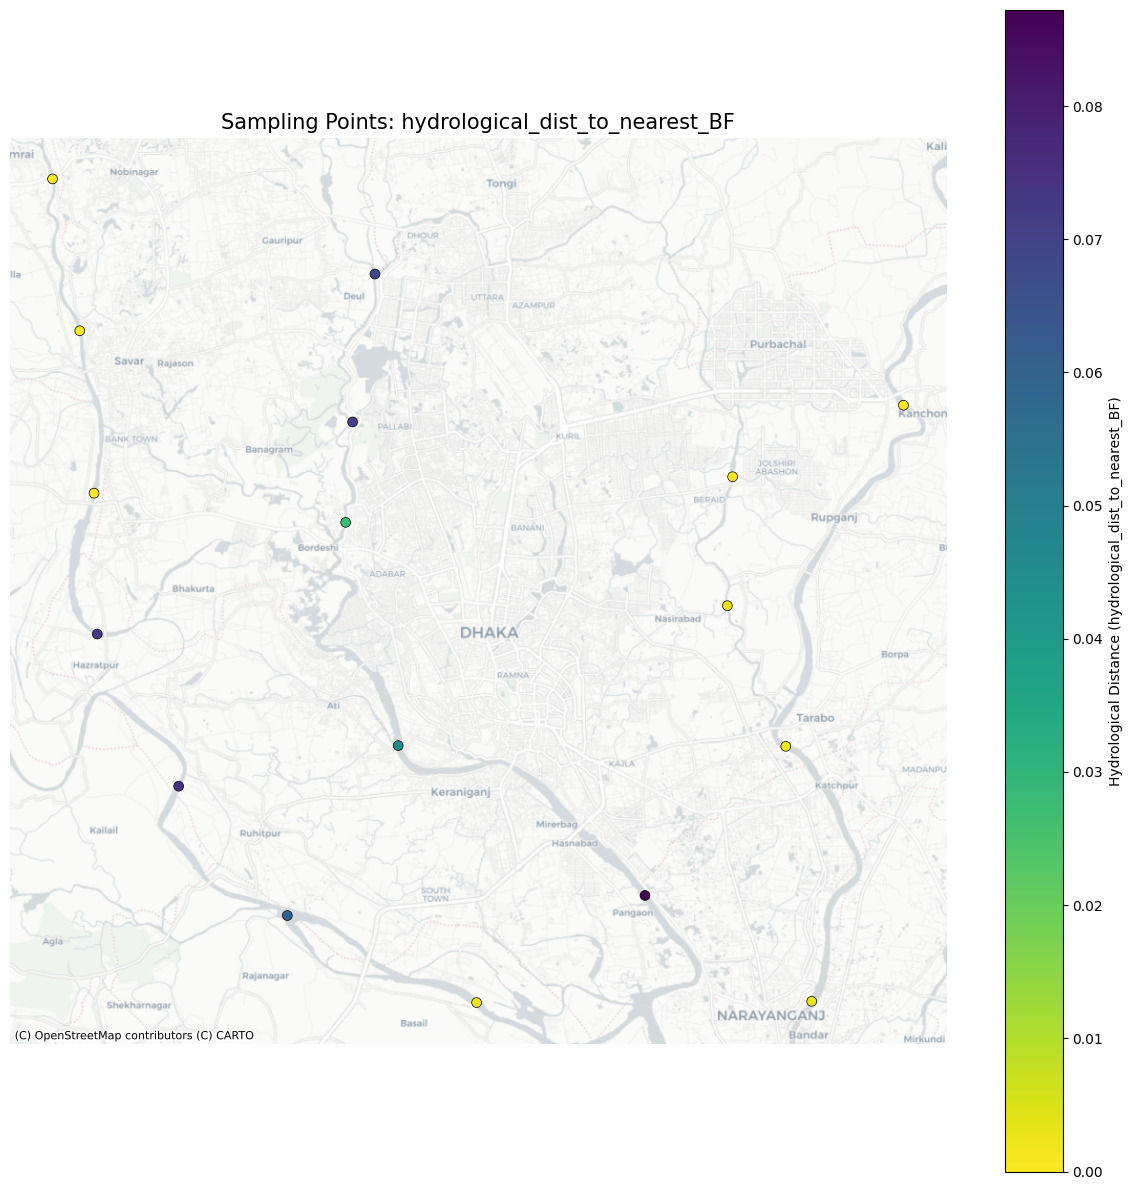

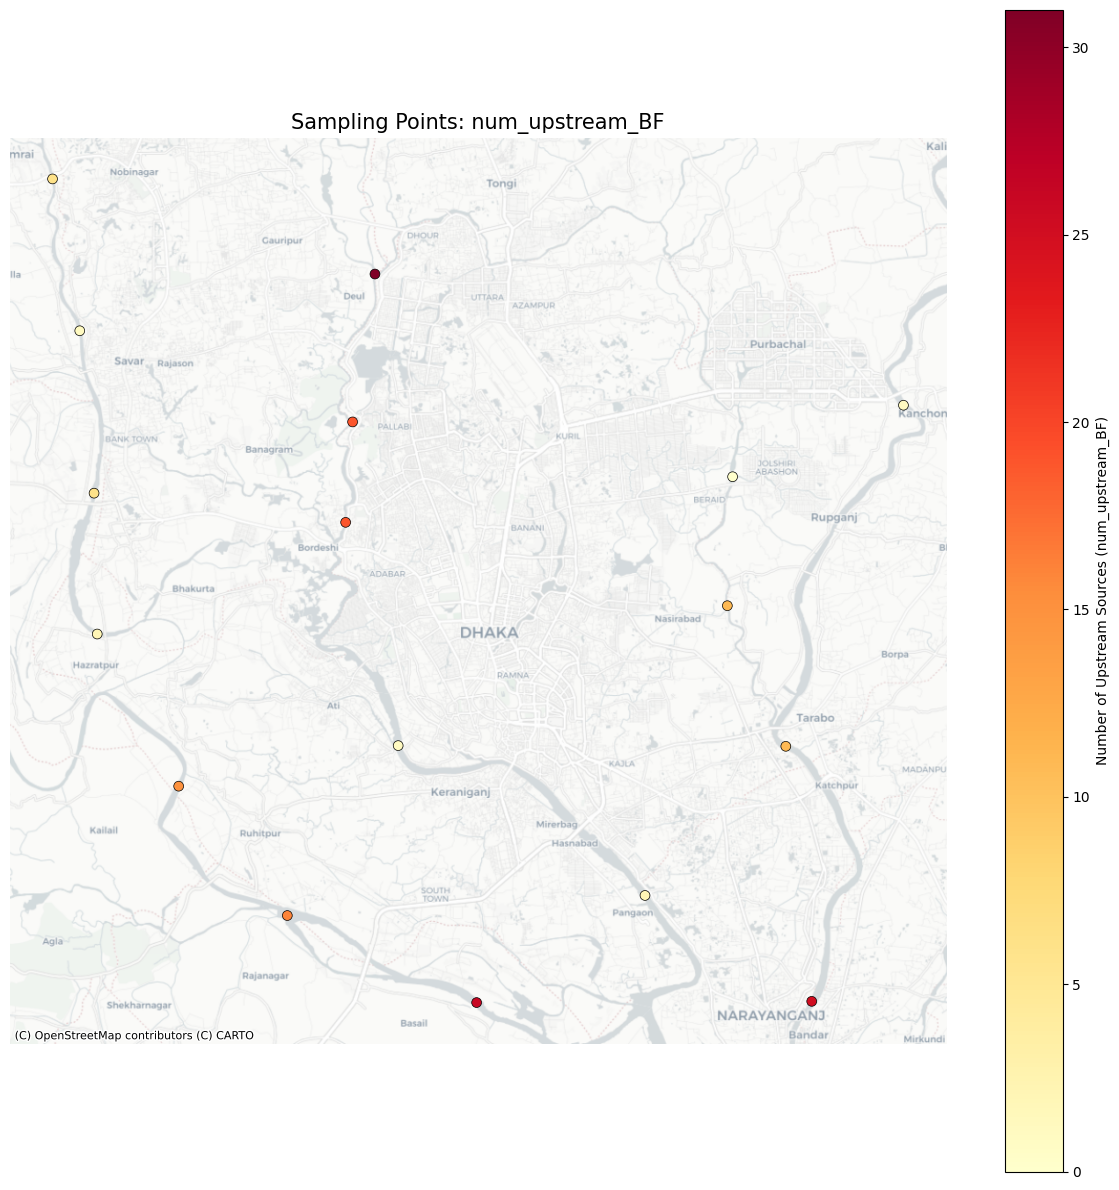


Maps generated and saved as 'map_hydrological_dist_to_nearest_BF.png' and 'map_num_upstream_BF.png'.


In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx # For adding a basemap

# --- 1. Define File Paths ---
SAMPLING_POINTS_SHP = 'sampling_point.shp' # Path to your original sampling points shapefile
# Assuming your "final values" are in this file,
# or you can change this to 'final_merged_hydrological_features.csv'
# if you want to visualize the output of the very last merge step.
FEATURES_CSV = 'hydrologicalF.csv' # Path to your processed features CSV

# --- 2. Load Data ---
try:
    # Load the original sampling points GeoDataFrame
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_SHP)
    print(f"Loaded {len(sampling_points_gdf)} sampling points from '{SAMPLING_POINTS_SHP}'.")
    print(f"CRS of sampling points: {sampling_points_gdf.crs}")

    # Load the features CSV
    features_df = pd.read_csv(FEATURES_CSV)
    # Set the 'Unnamed: 0' column as the index for merging
    if 'Unnamed: 0' in features_df.columns:
        features_df = features_df.set_index('Unnamed: 0')
        features_df.index.name = None # Clean up index name
    print(f"Loaded {len(features_df)} feature rows from '{FEATURES_CSV}'.")

    # --- 3. Merge Features with Spatial Data ---
    # Merge the features DataFrame with the GeoDataFrame based on their indices.
    # We assume the index of features_df corresponds to the index of sampling_points_gdf.
    # If your indices don't match or are not unique, you might need to merge on a specific ID column.
    
    # Ensure original index is preserved in sampling_points_gdf if it was not the default
    # Or, if sampling_points_gdf uses a default integer index, ensure features_df also uses that.
    # For now, let's assume default integer indices align, or the 'Unnamed: 0' aligns.
    
    # If your sampling_points_gdf also has an 'Unnamed: 0' or 'original_idx' that matches features_df's index:
    # You might need to adjust this depending on how your sampling_points_gdf was originally loaded.
    # Example: If sampling_points_gdf has an 'id_column' matching features_df's index:
    # merged_gdf = sampling_points_gdf.merge(features_df, left_on='id_column', right_index=True, how='left')

    # Assuming default integer index alignment for now, common if not explicitly set
    merged_gdf = sampling_points_gdf.merge(features_df, left_index=True, right_index=True, how='left')

    print("\nMerged GeoDataFrame (first 5 rows with new features):")
    print(merged_gdf.head())
    print(f"Total columns in merged GeoDataFrame: {merged_gdf.shape[1]}")

    # --- 4. Choose Features to Visualize ---
    # Pick a few key features to plot. You can change these.
    # Make sure the chosen columns exist in your FEATURES_CSV.
    
    # Check if the combined NDWI-based features are present
    if 'hydrological_dist_to_nearest_ANY' in merged_gdf.columns:
        feature_to_plot_1 = 'hydrological_dist_to_nearest_ANY'
        feature_to_plot_2 = 'num_upstream_ANY'
    else:
        # Fallback if _ANY columns aren't in the loaded CSV (e.g., if you loaded hydrological_features2.csv)
        feature_to_plot_1 = 'hydrological_dist_to_nearest_BF'
        feature_to_plot_2 = 'num_upstream_BF'
        print(f"Note: '{feature_to_plot_1}' and '{feature_to_plot_2}' are used as _ANY columns not found.")


    # --- 5. Create Spatial Visualizations ---

    # Plot 1: Hydrological Distance to Nearest Any Source
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 12))
    merged_gdf.plot(column=feature_to_plot_1, cmap='viridis_r', markersize=50,
                    legend=True, legend_kwds={'label': f"Hydrological Distance ({feature_to_plot_1})"},
                    edgecolor='black', linewidth=0.5, ax=ax1) # viridis_r reverses colors (darker = shorter dist)
    ax1.set_title(f'Sampling Points: {feature_to_plot_1}', fontsize=15)
    ax1.set_axis_off() # Hide axes for cleaner map
    # Add a basemap for geographical context
    cx.add_basemap(ax1, crs=merged_gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)
    plt.tight_layout()
    plt.savefig(f'map_{feature_to_plot_1}.png', dpi=300)
    plt.show()

    # Plot 2: Number of Upstream Any Sources
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 12))
    merged_gdf.plot(column=feature_to_plot_2, cmap='YlOrRd', markersize=50,
                    legend=True, legend_kwds={'label': f"Number of Upstream Sources ({feature_to_plot_2})"},
                    edgecolor='black', linewidth=0.5, ax=ax2) # YlOrRd for count (darker = more)
    ax2.set_title(f'Sampling Points: {feature_to_plot_2}', fontsize=15)
    ax2.set_axis_off()
    cx.add_basemap(ax2, crs=merged_gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)
    plt.tight_layout()
    plt.savefig(f'map_{feature_to_plot_2}.png', dpi=300)
    plt.show()

    print(f"\nMaps generated and saved as 'map_{feature_to_plot_1}.png' and 'map_{feature_to_plot_2}.png'.")

except FileNotFoundError as e:
    print(f"Error: One of the required files was not found. Please check paths: {e}")
    print(f"Ensure '{SAMPLING_POINTS_SHP}' and '{FEATURES_CSV}' exist in the correct directory.")
except KeyError as e:
    print(f"Error: A column expected for plotting or merging was not found: {e}")
    print("Please check the column names in your CSV file and ensure the correct feature names are selected.")
except Exception as e:
    print(f"An unexpected error occurred during spatial visualization: {e}")

In [14]:
merged_gdf.head()

Stations         River     CrW    CrR    NiW    NiR     CuW    CuR    AsW  \
0       S1  Dhaleshwari)  106.58  92.69  34.35  19.18   69.95  40.34   9.12   
1       S2  Dhaleshwari)  104.28  88.40  27.10  17.21   75.12  41.56  13.79   
2       S3  Dhaleshwari)   89.77  66.92  59.33  37.52   71.13  49.47  26.17   
3       S4  Dhaleshwari)   71.55  55.56  49.17  26.08   92.34  69.77  25.35   
4       S5  Dhaleshwari)  100.15  64.50  50.68  30.62  100.22  73.19  28.37   

     AsR  ...   CdR     PbW    PbR        Lat       Long  \
0   7.96  ...  2.66  105.90  50.73  23.910260  90.229845   
1   9.88  ...  2.97   96.14  38.90  23.858227  90.240038   
2  15.48  ...  2.10   77.36  32.79  23.802571  90.245390   
3  18.77  ...  1.79   90.48  43.40  23.754298  90.246581   
4  20.96  ...  1.45   79.10  53.55  23.702157  90.277077   

                    geometry hydrological_dist_to_nearest_BF  num_upstream_BF  \
0  POINT (90.22984 23.91026)                        0.000200                6   
1  POINT (90.24004 23.85823)                        0.000020                1   
2  POINT (90.24539 23.80257)                        0.000200                6   
3   POINT (90.24658 23.7543)                        0.073026                2   
4  POINT (90.27708 23.70216)                        0.074113               15   

   hydrological_dist_to_nearest_IND  num_upstream_IND  
0                          0.006790                 2  
1                          0.000000                 0  
2                          0.002100                 4  
3                          0.027234                 6  
4                          0.122163                 5  

[5 rows x 21 columns]

In [15]:
merged_gdf.to_csv("merged_df.csv",index= False)

Sampling points CRS (projected for interpolation/plot): EPSG:3857

Merged GeoDataFrame for interpolation (first 5 rows):
  Stations         River     CrW    CrR    NiW    NiR     CuW    CuR    AsW  \
0       S1  Dhaleshwari)  106.58  92.69  34.35  19.18   69.95  40.34   9.12   
1       S2  Dhaleshwari)  104.28  88.40  27.10  17.21   75.12  41.56  13.79   
2       S3  Dhaleshwari)   89.77  66.92  59.33  37.52   71.13  49.47  26.17   
3       S4  Dhaleshwari)   71.55  55.56  49.17  26.08   92.34  69.77  25.35   
4       S5  Dhaleshwari)  100.15  64.50  50.68  30.62  100.22  73.19  28.37   

     AsR  ...   CdR     PbW    PbR        Lat       Long  \
0   7.96  ...  2.66  105.90  50.73  23.910260  90.229845   
1   9.88  ...  2.97   96.14  38.90  23.858227  90.240038   
2  15.48  ...  2.10   77.36  32.79  23.802571  90.245390   
3  18.77  ...  1.79   90.48  43.40  23.754298  90.246581   
4  20.96  ...  1.45   79.10  53.55  23.702157  90.277077   

                           geometry hydrolo

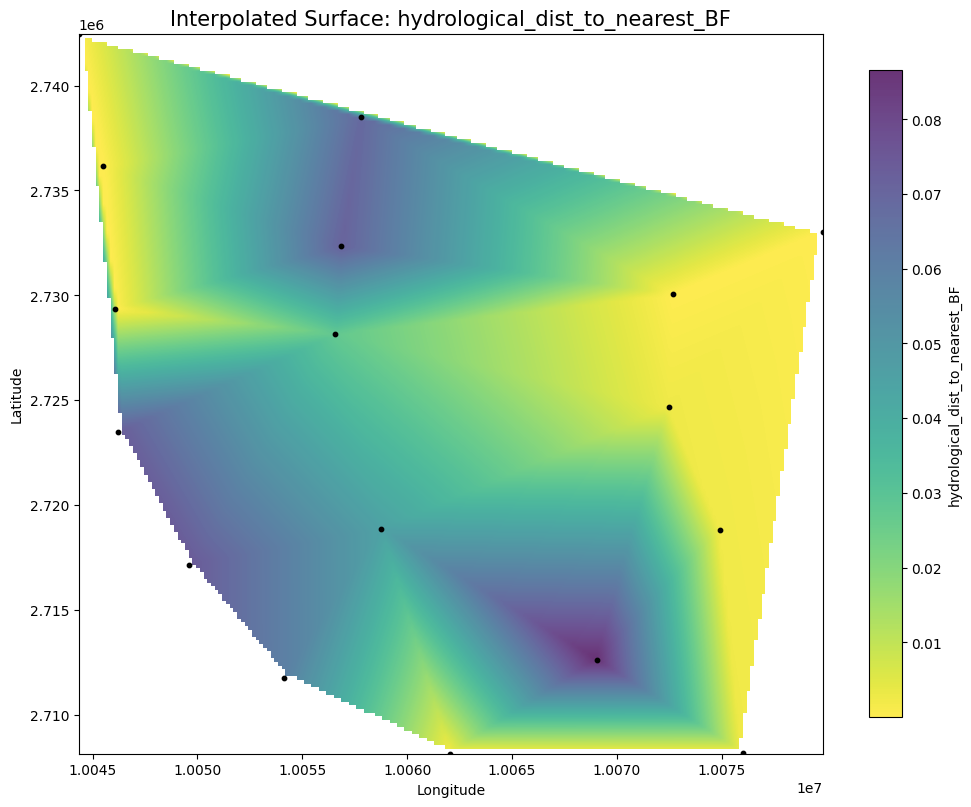

In [19]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata # For interpolation
import contextily as cx # For basemaps

# --- 1. Define File Paths ---
SAMPLING_POINTS_SHP = 'sampling_point.shp'
FEATURES_CSV = 'hydrologicalF.csv' # Or 'final_merged_hydrological_features.csv'
                                                    # or 'final_transformed_df.csv' if you applied scaling

# --- 2. Load Data ---
try:
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_SHP)
    # Ensure a consistent CRS for spatial operations and basemaps
    if sampling_points_gdf.crs is None:
        print("Warning: Sampling points GeoDataFrame has no CRS. Assuming WGS84 (EPSG:4326).")
        sampling_points_gdf = sampling_points_gdf.set_crs("EPSG:4326", allow_override=True)
    
    # Reproject to a suitable projected CRS for accurate distance calculations if not already
    # (e.g., a UTM zone for your area, or a local projection)
    # We'll use a common web mercator (EPSG:3857) for contextily compatibility if CRS is geographic.
    if sampling_points_gdf.crs.is_geographic:
        projected_crs = "EPSG:3857" # Web Mercator, good for Basemaps
        sampling_points_gdf_proj = sampling_points_gdf.to_crs(projected_crs)
    else:
        projected_crs = sampling_points_gdf.crs
        sampling_points_gdf_proj = sampling_points_gdf

    print(f"Sampling points CRS (projected for interpolation/plot): {sampling_points_gdf_proj.crs}")


    features_df = pd.read_csv(FEATURES_CSV)
    if 'Unnamed: 0' in features_df.columns:
        features_df = features_df.set_index('Unnamed: 0')
        features_df.index.name = None

    # Merge features with the projected GeoDataFrame
    merged_gdf = sampling_points_gdf_proj.merge(features_df, left_index=True, right_index=True, how='left')

    # Ensure all required columns are numeric and handle NaNs if any
    for col in merged_gdf.columns:
        if pd.api.types.is_numeric_dtype(merged_gdf[col]):
            # Fill NaN for interpolation. Common strategies: mean, median, or 0.
            # For "distance", a NaN might imply infinite distance, so max might be better, or treat as missing.
            # For "counts", NaN might imply 0.
            # For demonstration, let's fill with the mean for now, but be careful with this!
            merged_gdf[col] = merged_gdf[col].fillna(merged_gdf[col].mean())


    print("\nMerged GeoDataFrame for interpolation (first 5 rows):")
    print(merged_gdf.head())

    # --- 3. Choose Feature for Interpolation ---
    # IMPORTANT: Select the column you want to interpolate.
    # Examples: 'hydrological_dist_to_nearest_ANY', 'num_upstream_ANY', 'log_num_upstream_BF_scaled', 'BF_Impact_Score'
    
    # Check if a combined feature exists, otherwise default to a basic one.
    if 'hydrological_dist_to_nearest_ANY' in merged_gdf.columns:
        feature_to_interpolate = 'hydrological_dist_to_nearest_ANY'
        # Or 'num_upstream_ANY'
        # Or if you created the composite score: 'BF_Impact_Score'
    elif 'hydrological_dist_to_nearest_BF' in merged_gdf.columns:
        feature_to_interpolate = 'hydrological_dist_to_nearest_BF'
    else:
        # Fallback to the first numeric column if specific ones aren't found
        numeric_cols = merged_gdf.select_dtypes(include=np.number).columns.tolist()
        if numeric_cols:
            feature_to_interpolate = numeric_cols[0]
            print(f"Warning: Specific features not found. Using '{feature_to_interpolate}' for interpolation.")
        else:
            raise ValueError("No numeric columns found for interpolation.")

    print(f"\nProceeding with interpolation for feature: '{feature_to_interpolate}'")

    # --- 4. Prepare Data for Interpolation ---
    # Extract coordinates (X, Y) and Z values from your merged GeoDataFrame
    # FIX: Access the 'geometry' column directly as a Series
    points = np.array(merged_gdf['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist())
    values = merged_gdf[feature_to_interpolate].values

    # Define the interpolation grid
    # Get the bounding box of your points
    minx, miny, maxx, maxy = merged_gdf.total_bounds
    
    # Create a grid of points over the bounding box
    # Adjust resolution (num_rows, num_cols) for desired detail vs performance
    grid_resolution = 200 # Number of pixels in x and y direction
    grid_x, grid_y = np.mgrid[minx:maxx:complex(0, grid_resolution),
                              miny:maxy:complex(0, grid_resolution)]

    # --- 5. Perform Interpolation (Inverse Distance Weighting-like using griddata) ---
    print(f"Interpolating '{feature_to_interpolate}' using griddata (method='linear')...")
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Handle NaNs in the interpolated grid (areas outside convex hull of points for 'linear')
    grid_z[np.isnan(grid_z)] = np.nan # Or fill with a background value, e.g., mean, 0, or specific NoData value


    # --- 6. Visualize the Interpolated Surface ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot the interpolated raster
    cmap_choice = 'viridis_r' if 'dist' in feature_to_interpolate else 'YlOrRd'

    im = ax.imshow(grid_z.T, extent=(minx, maxx, miny, maxy), origin='lower',
                   cmap=cmap_choice, aspect='auto', interpolation='bilinear', alpha=0.8) # alpha for transparency

    # Optionally, overlay the original sampling points for context
    merged_gdf.plot(ax=ax, color='black', marker='o', markersize=10, zorder=2, label='Sampling Points')


    ax.set_title(f'Interpolated Surface: {feature_to_interpolate}', fontsize=15)
    ax.set_xlabel('Longitude' if sampling_points_gdf.crs.is_geographic else 'X Coordinate')
    ax.set_ylabel('Latitude' if sampling_points_gdf.crs.is_geographic else 'Y Coordinate')
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label(feature_to_interpolate)

    # Add a basemap for geographical context
    cx.add_basemap(ax, crs=projected_crs.to_string(), source=cx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.savefig(f'interpolated_map_{feature_to_interpolate}.png', dpi=300)
    plt.show()

    print(f"\nInterpolated map generated and saved as 'interpolated_map_{feature_to_interpolate}.png'.")

except FileNotFoundError as e:
    print(f"Error: One of the required files was not found. Please check paths: {e}")
    print(f"Ensure '{SAMPLING_POINTS_SHP}' and '{FEATURES_CSV}' exist in the correct directory.")
except KeyError as e:
    print(f"Error: A column expected for plotting or merging was not found: {e}")
    print("Please check the column names in your CSV file and ensure the correct feature is selected.")
except Exception as e:
    print(f"An unexpected error occurred during spatial interpolation: {e}")

Reprojected sampling points to EPSG:3857
Reprojected study area to EPSG:3857
All spatial data are now in CRS: EPSG:3857

Merged GeoDataFrame for interpolation (first 5 rows):
  Stations         River     CrW    CrR    NiW    NiR     CuW    CuR    AsW  \
0       S1  Dhaleshwari)  106.58  92.69  34.35  19.18   69.95  40.34   9.12   
1       S2  Dhaleshwari)  104.28  88.40  27.10  17.21   75.12  41.56  13.79   
2       S3  Dhaleshwari)   89.77  66.92  59.33  37.52   71.13  49.47  26.17   
3       S4  Dhaleshwari)   71.55  55.56  49.17  26.08   92.34  69.77  25.35   
4       S5  Dhaleshwari)  100.15  64.50  50.68  30.62  100.22  73.19  28.37   

     AsR  ...   CdR     PbW    PbR        Lat       Long  \
0   7.96  ...  2.66  105.90  50.73  23.910260  90.229845   
1   9.88  ...  2.97   96.14  38.90  23.858227  90.240038   
2  15.48  ...  2.10   77.36  32.79  23.802571  90.245390   
3  18.77  ...  1.79   90.48  43.40  23.754298  90.246581   
4  20.96  ...  1.45   79.10  53.55  23.702157  90.

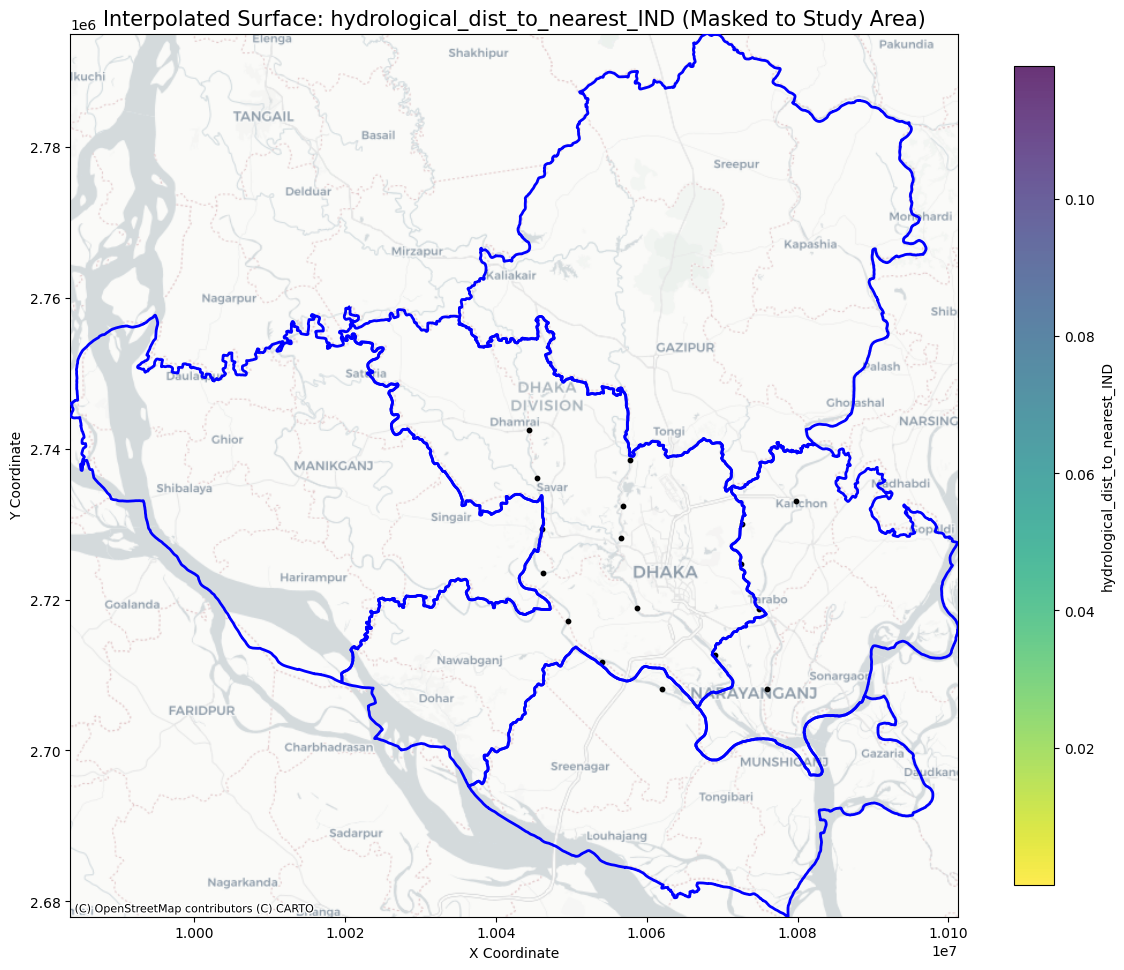


Interpolated map for 'hydrological_dist_to_nearest_IND' masked to study area generated and saved.


In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import contextily as cx
from shapely.geometry import Point # For checking points within polygon
from shapely.ops import unary_union # To combine multiple polygons into one

# --- 1. Define File Paths ---
SAMPLING_POINTS_SHP = 'sampling_point.shp'
FEATURES_CSV = 'hydrologicalF.csv' # Or your most recent merged/transformed CSV
STUDY_AREA_SHP = 'Area2.shp' # Path to your study area shapefile

# --- 2. Load Data ---
try:
    # Load the original sampling points GeoDataFrame
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_SHP)
    
    # Load the study area GeoDataFrame
    study_area_gdf = gpd.read_file(STUDY_AREA_SHP)

    # --- Ensure Consistent CRS for all GeoDataFrames ---
    # We will reproject everything to Web Mercator (EPSG:3857) for good basemap compatibility and projected units.
    # Adjust this CRS if you have a specific local projected CRS (e.g., UTM zone) in mind.
    TARGET_CRS = "EPSG:3857"

    if sampling_points_gdf.crs != TARGET_CRS:
        sampling_points_gdf_proj = sampling_points_gdf.to_crs(TARGET_CRS)
        print(f"Reprojected sampling points to {TARGET_CRS}")
    else:
        sampling_points_gdf_proj = sampling_points_gdf
    
    if study_area_gdf.crs != TARGET_CRS:
        study_area_gdf_proj = study_area_gdf.to_crs(TARGET_CRS)
        print(f"Reprojected study area to {TARGET_CRS}")
    else:
        study_area_gdf_proj = study_area_gdf

    print(f"All spatial data are now in CRS: {TARGET_CRS}")

    # Load the features CSV
    features_df = pd.read_csv(FEATURES_CSV)
    if 'Unnamed: 0' in features_df.columns:
        features_df = features_df.set_index('Unnamed: 0')
        features_df.index.name = None

    # Merge features with the projected sampling points GeoDataFrame
    merged_gdf = sampling_points_gdf_proj.merge(features_df, left_index=True, right_index=True, how='left')

    # Ensure all required columns are numeric and handle NaNs if any
    for col in merged_gdf.columns:
        if pd.api.types.is_numeric_dtype(merged_gdf[col]):
            merged_gdf[col] = merged_gdf[col].fillna(merged_gdf[col].mean()) # Fill NaNs for interpolation

    print("\nMerged GeoDataFrame for interpolation (first 5 rows):")
    print(merged_gdf.head())

    # --- 3. Choose Feature for Interpolation ---
    feature_to_interpolate = 'hydrological_dist_to_nearest_IND' # Example: Change as needed
    
    if feature_to_interpolate not in merged_gdf.columns:
        raise ValueError(f"Error: The column '{feature_to_interpolate}' was not found in the merged data.")

    print(f"\nProceeding with interpolation for feature: '{feature_to_interpolate}'")

    # --- 4. Prepare Data for Interpolation ---
    points = np.array(merged_gdf['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist())
    values = merged_gdf[feature_to_interpolate].values

    # Define the interpolation grid using the bounds of the study area
    minx, miny, maxx, maxy = study_area_gdf_proj.total_bounds
    grid_resolution = 200 # Number of pixels in x and y direction
    grid_x, grid_y = np.mgrid[minx:maxx:complex(0, grid_resolution),
                              miny:maxy:complex(0, grid_resolution)]

    # --- 5. Perform Interpolation ---
    print(f"Interpolating '{feature_to_interpolate}' using griddata (method='linear')...")
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # --- 6. Mask the Interpolated Surface by the Study Area Polygon ---
    print("Masking interpolated surface to study area boundary...")
    
    # Combine all polygons in study_area_gdf_proj into a single polygon object for efficient checking
    study_area_polygon = unary_union(study_area_gdf_proj.geometry)

    # Create a boolean mask: True for points inside the polygon, False otherwise
    mask = np.zeros(grid_x.shape, dtype=bool)
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            # Check if the center of the grid cell is within the study area polygon
            if study_area_polygon.contains(Point(grid_x[i, j], grid_y[i, j])):
                mask[i, j] = True
    
    # Apply the mask: set values outside the polygon to NaN
    grid_z[~mask] = np.nan # Invert mask to set values outside to NaN


    # --- 7. Visualize the Interpolated Surface ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # For distance, 'viridis_r' or 'plasma_r' makes shorter distances (higher impact) darker/more prominent.
    cmap_choice = 'viridis_r' if 'dist' in feature_to_interpolate else 'YlOrRd'

    im = ax.imshow(grid_z.T, extent=(minx, maxx, miny, maxy), origin='lower',
                   cmap=cmap_choice, aspect='auto', interpolation='bilinear', alpha=0.8)

    # Overlay the original sampling points
    merged_gdf.plot(ax=ax, color='black', marker='o', markersize=10, zorder=3, label='Sampling Points')
    
    # Overlay the boundary of the study area
    study_area_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, zorder=4, label='Study Area Boundary')


    ax.set_title(f'Interpolated Surface: {feature_to_interpolate} (Masked to Study Area)', fontsize=15)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label(feature_to_interpolate)

    # Add a basemap for geographical context using the projected CRS
    cx.add_basemap(ax, crs=TARGET_CRS, source=cx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.savefig(f'interpolated_map_{feature_to_interpolate}_masked.png', dpi=300)
    plt.show()

    print(f"\nInterpolated map for '{feature_to_interpolate}' masked to study area generated and saved.")

except FileNotFoundError as e:
    print(f"Error: One of the required files was not found. Please check paths: {e}")
    print(f"Ensure '{SAMPLING_POINTS_SHP}', '{FEATURES_CSV}', and '{STUDY_AREA_SHP}' exist.")
except KeyError as e:
    print(f"Error: A column expected for plotting or merging was not found: {e}")
    print("Please check the column names in your CSV file and ensure the correct feature is selected.")
except Exception as e:
    print(f"An unexpected error occurred during spatial interpolation: {e}")

In [26]:
merged_gdf.River

0      Dhaleshwari)
1      Dhaleshwari)
2      Dhaleshwari)
3      Dhaleshwari)
4      Dhaleshwari)
5      Dhaleshwari)
6      Dhaleshwari)
7            Turag)
8            Turag)
9            Turag)
10       Buriganga)
11       Buriganga)
12            Balu)
13            Balu)
14    Shitalakshya)
15    Shitalakshya)
16    Shitalakshya)
Name: River, dtype: object

In [29]:
merged_gdf.River = merged_gdf.River.astype(str).str.rstrip(')')
merged_gdf.head()

Stations        River     CrW    CrR    NiW    NiR     CuW    CuR    AsW  \
0       S1  Dhaleshwari  106.58  92.69  34.35  19.18   69.95  40.34   9.12   
1       S2  Dhaleshwari  104.28  88.40  27.10  17.21   75.12  41.56  13.79   
2       S3  Dhaleshwari   89.77  66.92  59.33  37.52   71.13  49.47  26.17   
3       S4  Dhaleshwari   71.55  55.56  49.17  26.08   92.34  69.77  25.35   
4       S5  Dhaleshwari  100.15  64.50  50.68  30.62  100.22  73.19  28.37   

     AsR  ...   CdR     PbW    PbR        Lat       Long  \
0   7.96  ...  2.66  105.90  50.73  23.910260  90.229845   
1   9.88  ...  2.97   96.14  38.90  23.858227  90.240038   
2  15.48  ...  2.10   77.36  32.79  23.802571  90.245390   
3  18.77  ...  1.79   90.48  43.40  23.754298  90.246581   
4  20.96  ...  1.45   79.10  53.55  23.702157  90.277077   

                           geometry hydrological_dist_to_nearest_BF  \
0    POINT (10044340.4 2742476.706)                        0.000200   
1  POINT (10045475.079 2736141.944)                        0.000020   
2  POINT (10046070.861 2729368.914)                        0.000200   
3  POINT (10046203.443 2723496.705)                        0.073026   
4  POINT (10049598.242 2717156.415)                        0.074113   

   num_upstream_BF  hydrological_dist_to_nearest_IND  num_upstream_IND  
0                6                          0.006790                 2  
1                1                          0.000000                 0  
2                6                          0.002100                 4  
3                2                          0.027234                 6  
4               15                          0.122163                 5  

[5 rows x 21 columns]

In [30]:
merged_gdf.to_csv("merged_df.csv", index=False)

In [31]:
!pip install earthengine-api

In [2]:
! earthengine authenticate --force

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=http%3A%2F%2Flocalhost%3A8085&response_type=code&code_challenge=MBD2Hn9CSXp-KmNSe0nwpT8c6jGIXf4Ntry5cd_9JVI&code_challenge_method=S256

Waiting for successful authorization from web browser ...

Successfully saved authorization token.


In [2]:
import requests
import os
import time

def download_lulc_tile(year, tile_id="46R", output_dir="LULC_Downloads_46R_Tile"):
    """
    Downloads a specific LULC GeoTIFF tile for a given year.

    Args:
        year (int): The year of the LULC data (e.g., 2017).
        tile_id (str): The Sentinel-2 MGRS tile ID (e.g., "46R").
        output_dir (str): The directory where the downloaded files will be saved.
    """
    
    base_url = "https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/"
    
    # Construct the year-specific directory and filename
    year_dir = f"lc{year}/"
    filename = f"{tile_id}_{year}0101-{year+1}0101.tif" # Assumes YYYY0101-(YYYY+1)0101 pattern

    full_url = f"{base_url}{year_dir}{filename}"
    output_filepath = os.path.join(output_dir, filename)

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    print(f"Attempting to download: {full_url}")
    print(f"Saving to: {output_filepath}")

    try:
        # Use stream=True to handle large files efficiently
        with requests.get(full_url, stream=True) as r:
            r.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
            with open(output_filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192): # Iterate in chunks
                    f.write(chunk)
        print(f"Successfully downloaded {filename}")
    except requests.exceptions.HTTPError as e:
        print(f"Error downloading {filename}: HTTP Error {e.response.status_code} - {e.response.reason}")
        if e.response.status_code == 404:
            print("This usually means the file was not found at the specified URL for this year/tile.")
    except requests.exceptions.ConnectionError as e:
        print(f"Error downloading {filename}: Connection Error - {e}")
    except requests.exceptions.Timeout as e:
        print(f"Error downloading {filename}: Timeout Error - {e}")
    except requests.exceptions.RequestException as e:
        print(f"An unexpected error occurred while downloading {filename}: {e}")
    
    # Add a small delay to avoid overwhelming the server
    time.sleep(1) 


# --- Main execution part ---
if __name__ == "__main__":
    start_year = 2017
    end_year = 2023
    
    # The specific MGRS tile ID you provided
    target_tile_id = "46R" 
    
    # Output directory for your downloads
    download_directory = "LULC_Annual_Tiles1"

    print(f"Starting download of LULC tiles for MGRS tile '{target_tile_id}' from {start_year} to {end_year}...")
    
    for year in range(start_year, end_year + 1):
        download_lulc_tile(year, target_tile_id, download_directory)
        
    print("\nDownload process completed.")
    print(f"Check the '{download_directory}' folder for your GeoTIFF files.")

    print("\n--- Important Note on Coverage ---")
    print(f"The downloaded files are only for the Sentinel-2 MGRS tile '{target_tile_id}'.")
    print("Bangladesh is covered by multiple MGRS tiles (e.g., 45Q, 46Q, 45R, 46R).")
    print("If you need full coverage of Bangladesh, you will need to find the corresponding links for other tiles.")

Starting download of LULC tiles for MGRS tile '46R' from 2017 to 2023...
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2017/46R_20170101-20180101.tif
Saving to: LULC_Annual_Tiles1/46R_20170101-20180101.tif
Successfully downloaded 46R_20170101-20180101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2018/46R_20180101-20190101.tif
Saving to: LULC_Annual_Tiles1/46R_20180101-20190101.tif
Successfully downloaded 46R_20180101-20190101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2019/46R_20190101-20200101.tif
Saving to: LULC_Annual_Tiles1/46R_20190101-20200101.tif
Successfully downloaded 46R_20190101-20200101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2020/46R_20200101-20210101.tif
Saving to: LULC_Annual_Tiles1/46R_20200101-20210101.tif
Successfully downloaded 46R_20200101-20210101.tif
Attempting to downl

In [4]:
# --- Main execution part ---
if __name__ == "__main__":
    start_year = 2017
    end_year = 2022
    
    # The specific MGRS tile ID you provided
    target_tile_id = "46Q" 
    
    # Output directory for your downloads
    download_directory = "LULC_Annual_Tiles4"

    print(f"Starting download of LULC tiles for MGRS tile '{target_tile_id}' from {start_year} to {end_year}...")
    
    for year in range(start_year, end_year + 1):
        download_lulc_tile(year, target_tile_id, download_directory)
        
    print("\nDownload process completed.")
    print(f"Check the '{download_directory}' folder for your GeoTIFF files.")

    print("\n--- Important Note on Coverage ---")
    print(f"The downloaded files are only for the Sentinel-2 MGRS tile '{target_tile_id}'.")
    print("Bangladesh is covered by multiple MGRS tiles (e.g., 45Q, 46Q, 45R, 46R).")
    print("If you need full coverage of Bangladesh, you will need to find the corresponding links for other tiles.")

Starting download of LULC tiles for MGRS tile '46Q' from 2017 to 2022...
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2017/46Q_20170101-20180101.tif
Saving to: LULC_Annual_Tiles4/46Q_20170101-20180101.tif
Successfully downloaded 46Q_20170101-20180101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2018/46Q_20180101-20190101.tif
Saving to: LULC_Annual_Tiles4/46Q_20180101-20190101.tif
Successfully downloaded 46Q_20180101-20190101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2019/46Q_20190101-20200101.tif
Saving to: LULC_Annual_Tiles4/46Q_20190101-20200101.tif
Successfully downloaded 46Q_20190101-20200101.tif
Attempting to download: https://lulctimeseries.blob.core.windows.net/lulctimeseriesv003/lc2020/46Q_20200101-20210101.tif
Saving to: LULC_Annual_Tiles4/46Q_20200101-20210101.tif
Successfully downloaded 46Q_20200101-20210101.tif
Attempting to downl

In [5]:
! pwd

/Users/rakibhhridoy/Research/Five_Rivers/gis


In [10]:
import os
import subprocess
import tempfile

# --- Configuration ---
# Set the root directory where your LULC_Annual_Tiles folders are located
# Make sure this path is correct for your system.
ROOT_LULC_PARENT_DIR = os.path.expanduser("~/Research/Five_Rivers") # This is now correctly expanded internally

# Define the output directory for your merged annual LULC files
OUTPUT_MERGED_LULC_DIR = os.path.join(ROOT_LULC_PARENT_DIR, "gis", "Merged_Annual_LULC")

# Path to your gdal_merge.py executable
GDAL_MERGE_PATH = "/opt/local/Library/Frameworks/Python.framework/Versions/3.12/bin/gdal_merge.py"
PYTHON_EXECUTABLE = "/opt/local/Library/Frameworks/Python.framework/Versions/3.12/bin/python3"

# Define the years you want to process
YEARS_TO_PROCESS = range(2017, 2023)

# Define the structure of your tile folders and their corresponding MGRS prefixes
LULC_TILE_STRUCTURE = [
    ('LULC_Annual_Tiles1', '46R'),
    ('LULC_Annual_Tiles2', '45R'),
    ('LULC_Annual_Tiles3', '45Q'),
    ('LULC_Annual_Tiles4', '46Q')
]

# --- Create Output Directory if it doesn't exist ---
os.makedirs(OUTPUT_MERGED_LULC_DIR, exist_ok=True)
print(f"Merged LULC files will be saved to: {OUTPUT_MERGED_LULC_DIR}")
print("-" * 50)

# --- Loop through each year to perform the merge ---
for year in YEARS_TO_PROCESS:
    print(f"Processing year: {year}")
    
    input_files_for_year = []
    
    # Collect all input TIFF files for the current year
    for folder_name, tile_prefix in LULC_TILE_STRUCTURE:
        # Construct the filename pattern like '46R_20170101-20180101.tif'
        filename = f"{tile_prefix}_{year}0101-{year+1}0101.tif"
        full_tile_path = os.path.join(ROOT_LULC_PARENT_DIR, folder_name, filename)
        
        # --- DEBUG PRINT: Print the exact path being checked ---
        print(f"  Checking for file: {full_tile_path}")
        
        if os.path.exists(full_tile_path):
            input_files_for_year.append(full_tile_path)
        else:
            print(f"  Warning: File not found for {year} in {folder_name}: {full_tile_path}. Skipping.")
            
    if not input_files_for_year:
        print(f"  No input files found for {year}. Skipping merge for this year.")
        print("-" * 50)
        continue

    # Create a temporary file to store the list of input TIFFs for gdal_merge.py
    temp_optfile = None
    try:
        temp_optfile = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.txt')
        temp_optfile.write('\n'.join(input_files_for_year))
        temp_optfile.close()
        optfile_path = temp_optfile.name
        
        print(f"  Temporary optfile created at: {optfile_path}")

        # Define the output file path for the merged annual LULC
        output_merged_file = os.path.join(OUTPUT_MERGED_LULC_DIR, f"LULC{year}.tif")

        # Construct the gdal_merge.py command as a list of arguments
        command = [
            PYTHON_EXECUTABLE,
            GDAL_MERGE_PATH,
            '-ot', 'Float32',
            '-of', 'GTiff',
            '-o', output_merged_file,
            '--optfile', optfile_path
        ]

        print(f"  Merging files for {year} using command: {' '.join(command)}")
        
        process = subprocess.run(command, capture_output=True, text=True, check=False)

        if process.returncode == 0:
            print(f"  Successfully merged {year} LULC to: {output_merged_file}")
        else:
            print(f"  ERROR merging {year} LULC:")
            print(f"    Stdout: {process.stdout}")
            print(f"    Stderr: {process.stderr}")
            print(f"    Command: {' '.join(command)}")

    except Exception as e:
        print(f"  An error occurred during merge for {year}: {e}")
    finally:
        if temp_optfile and os.path.exists(optfile_path):
            os.remove(optfile_path)
            print(f"  Cleaned up temporary optfile: {optfile_path}")
            
    print("-" * 50)

print("\nAll annual LULC merging tasks completed.")
print(f"Check the '{os.path.basename(OUTPUT_MERGED_LULC_DIR)}' folder inside '{os.path.dirname(OUTPUT_MERGED_LULC_DIR)}' for your merged files.")

Merged LULC files will be saved to: /Users/rakibhhridoy/Research/Five_Rivers/gis/Merged_Annual_LULC
--------------------------------------------------
Processing year: 2017
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles1/46R_20170101-20180101.tif
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles2/45R_20170101-20180101.tif
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles3/45Q_20170101-20180101.tif
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles4/46Q_20170101-20180101.tif
  No input files found for 2017. Skipping merge for this year.
--------------------------------------------------
Processing year: 2018
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles1/46R_20180101-20190101.tif
  Checking for file: /Users/rakibhhridoy/Research/Five_Rivers/LULC_Annual_Tiles2/45R_20180101-20190101.tif
  Checking for file: /Users/rakibhhridoy/Research

In [11]:
!tree

.
├── BUIC.txt
├── BrickDist.tif
├── BrickDist.tif.aux.xml
├── DEM.tif
├── DEM.tif.aux.xml
├── EDA.ipynb
├── EVIC.txt
├── FiveRiver.qgz
├── GIS.ipynb
├── GIS1.ipynb
├── Indices
│   ├── DEMF.tif
│   ├── DEMF.tif.aux.xml
│   ├── DEMMap1.tif
│   ├── DEMMap1.tif.aux.xml
│   ├── DemMap.tif
│   ├── DemMap.tif.aux.xml
│   ├── LULC
│   │   ├── LULC_2018.tif
│   │   ├── LULC_2019.tif
│   │   ├── LULC_2020.tif
│   │   ├── LULC_2021.tif
│   │   └── LULC_2022.tif
│   ├── awei_noshadow.tif
│   ├── awei_noshadow.tif.aux.xml
│   ├── bui.tif
│   ├── evi.tif
│   ├── gndvi.tif
│   ├── gndvi.tif.aux.xml
│   ├── mndwi.tif
│   ├── ndbi.tif
│   ├── ndbsi.tif
│   ├── ndsi.tif
│   ├── ndvi.tif
│   ├── ndwi.tif
│   ├── savi.tif
│   └── ui.tif
├── IndustryDist.tif
├── IndustryDist.tif.aux.xml
├── LULCColor.clr
├── LULC_2017.tif
├── LULC_2017.tif.aux.xml
├── MNDWIC.txt
├── NDBIC.txt
├── NDBSIC.txt
├── NDSIC.txt
├── NDVIC.txt
├── NDVIColorPallete.txt
├── NDWIC.txt
├── SAVIC.txt
├── SamplingLocation1.shp
├── Thana

In [15]:
import rasterio
import numpy as np
from rasterio.enums import Resampling
import os

# --- Configuration ---
SENTINEL_PRODUCT_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/IndicesCalculation/"
R10M_DIR = os.path.join(SENTINEL_PRODUCT_DIR, "R10m")
R20M_DIR = os.path.join(SENTINEL_PRODUCT_DIR, "R20m")
OUTPUT_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/CalIndices"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Starting calculation of all specified indices (output 10m resolution, full extent)...")

def scale_band(band):
    """Scale Sentinel-2 band values by dividing by 10000"""
    return band.astype(np.float32) / 10000.0

def safe_divide(a, b, default=0):
    """Safe division with handling of division by zero"""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(b != 0, a / b, default)
    return result.astype(np.float32)

try:
    # --- 1. Load and Scale Sentinel-2 Bands ---
    print("Loading and scaling 10m and 20m Sentinel-2 bands...")

    band_paths_10m = {
        'B2': os.path.join(R10M_DIR, "T45QZG_20250510T042721_B02_10m.jp2"), # Blue
        'B3': os.path.join(R10M_DIR, "T45QZG_20250510T042721_B03_10m.jp2"), # Green
        'B4': os.path.join(R10M_DIR, "T45QZG_20250510T042721_B04_10m.jp2"), # Red
        'B8': os.path.join(R10M_DIR, "T45QZG_20250510T042721_B08_10m.jp2")  # NIR
    }

    band_paths_20m = {
        'B11': os.path.join(R20M_DIR, "T45QZG_20250510T042721_B11_20m.jp2"), # SWIR1
        'B12': os.path.join(R20M_DIR, "T45QZG_20250510T042721_B12_20m.jp2")  # SWIR2
    }

    # Load 10m bands and get reference profile
    bands_10m = {}
    profile_10m = None
    with rasterio.open(band_paths_10m['B8']) as src_b8:
        profile_10m = src_b8.profile
        print(f"Sentinel-2 Raster CRS: {profile_10m['crs']}")
        print(f"Sentinel-2 Raster Bounds (left, bottom, right, top): {src_b8.bounds}")
        bands_10m['B8'] = scale_band(src_b8.read(1))

    for band_name, band_path in band_paths_10m.items():
        if band_name == 'B8': continue
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"10m band not found: {band_path}")
        with rasterio.open(band_path) as src:
            bands_10m[band_name] = scale_band(src.read(1))

    # Load and resample 20m bands to 10m resolution
    bands_20m_resampled = {}
    for band_name, band_path in band_paths_20m.items():
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"20m band not found: {band_path}")
        with rasterio.open(band_path) as src:
            resampled_band = src.read(
                out_shape=(1, profile_10m['height'], profile_10m['width']),
                resampling=Resampling.bilinear
            )
            bands_20m_resampled[band_name] = scale_band(resampled_band[0])

    # Assign loaded/resampled bands to variables
    B2 = bands_10m['B2']   # Blue
    B3 = bands_10m['B3']   # Green
    B4 = bands_10m['B4']   # Red
    B8 = bands_10m['B8']   # NIR
    B11 = bands_20m_resampled['B11'] # SWIR1
    B12 = bands_20m_resampled['B12'] # SWIR2

    # --- 2. Calculate Indices with Proper Scaling and Handling ---
    print("Calculating indices with proper scaling and handling...")
    
    calculated_indices = {}

    # NDVI (Normalized Difference Vegetation Index)
    ndvi = safe_divide(B8 - B4, B8 + B4)
    calculated_indices['NDVI'] = ndvi

    # EVI (Enhanced Vegetation Index)
    evi = 2.5 * safe_divide(B8 - B4, B8 + 6 * B4 - 7.5 * B2 + 1)
    calculated_indices['EVI'] = np.clip(evi, -1, 1)  # Clip to reasonable range

    # SAVI (Soil Adjusted Vegetation Index)
    L_savi = 0.5
    savi = (1 + L_savi) * safe_divide(B8 - B4, B8 + B4 + L_savi)
    calculated_indices['SAVI'] = savi
    
    # NDWI (Normalized Difference Water Index - McFeeters)
    ndwi = safe_divide(B3 - B8, B3 + B8)
    calculated_indices['NDWI'] = ndwi

    # MNDWI (Modified Normalized Difference Water Index)
    mndwi = safe_divide(B3 - B11, B3 + B11)
    calculated_indices['MNDWI'] = mndwi

    # NDBI (Normalized Difference Built-up Index)
    ndbi = safe_divide(B11 - B8, B11 + B8)
    calculated_indices['NDBI'] = ndbi

    # NDSI (Normalized Difference Snow Index)
    ndsi = safe_divide(B3 - B11, B3 + B11)
    calculated_indices['NDSI'] = ndsi
    
    # UI (Urban Index)
    ui = safe_divide(B12 - B8, B12 + B8)
    calculated_indices['UI'] = ui

    # BUI (Built-Up Index)
    bui = ndbi - ndvi
    calculated_indices['BUI'] = np.clip(bui, -1, 1)

    # NDBSI (Normalized Difference Bare Soil Index)
    numerator_ndbsi = (B11 + B4) - (B8 + B2)
    denominator_ndbsi = (B11 + B4) + (B8 + B2)
    ndbsi = safe_divide(numerator_ndbsi, denominator_ndbsi)
    calculated_indices['NDBSI'] = ndbsi

    # AWEI_noshadow (Automated Water Extraction Index - No Shadow)
    awei_noshadow = 4 * (B3 - B11) - (0.25 * B8 + 2.75 * B12)
    calculated_indices['AWEI_noshadow'] = np.clip(awei_noshadow, -1, 1)

    # --- 3. Save Each Calculated Index as GeoTIFF ---
    print("Saving calculated indices as GeoTIFF files...")
    
    profile_for_output = profile_10m.copy()
    profile_for_output.update(
        dtype='float32',
        nodata=np.nan,
        driver='GTiff',  # Use GeoTIFF driver instead of JP2
        compress='lzw'   # Add compression to reduce file size
    )

    for index_name, index_array in calculated_indices.items():
        output_filename = f"{index_name.lower()}_10m_full_extent.tif"  # Using .tif extension
        output_filepath = os.path.join(OUTPUT_DIR, output_filename)
        
        print(f"\n--- Saving {index_name} ---")
        print(f"  Shape: {index_array.shape}")
        valid_pixels = np.count_nonzero(~np.isnan(index_array))
        print(f"  Valid pixels: {valid_pixels}")
        if valid_pixels > 0:
            print(f"  Min: {np.nanmin(index_array):.4f}, Max: {np.nanmax(index_array):.4f}, Mean: {np.nanmean(index_array):.4f}")

        with rasterio.open(output_filepath, "w", **profile_for_output) as dest:
            dest.write(index_array, 1)
        print(f"Saved to: {output_filepath}")

    print("\nAll indices calculated and saved successfully as GeoTIFF files!")
    print(f"Output directory: {OUTPUT_DIR}")

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Starting calculation of all specified indices (output 10m resolution, full extent)...
Loading and scaling 10m and 20m Sentinel-2 bands...
Sentinel-2 Raster CRS: EPSG:32645
Sentinel-2 Raster Bounds (left, bottom, right, top): BoundingBox(left=799980.0, bottom=2590200.0, right=909780.0, top=2700000.0)
Calculating indices with proper scaling and handling...
Saving calculated indices as GeoTIFF files...

--- Saving NDVI ---
  Shape: (10980, 10980)
  Valid pixels: 120560400
  Min: -1.0000, Max: 1.0000, Mean: 0.3061
Saved to: /Users/rakibhhridoy/Five_Rivers/gis/CalIndices/ndvi_10m_full_extent.tif

--- Saving EVI ---
  Shape: (10980, 10980)
  Valid pixels: 120560400
  Min: -1.0000, Max: 1.0000, Mean: 0.3428
Saved to: /Users/rakibhhridoy/Five_Rivers/gis/CalIndices/evi_10m_full_extent.tif

--- Saving SAVI ---
  Shape: (10980, 10980)
  Valid pixels: 120560400
  Min: -0.4316, Max: 0.8260, Mean: 0.2494
Saved to: /Users/rakibhhridoy/Five_Rivers/gis/CalIndices/savi_10m_full_extent.tif

--- Saving ND

In [18]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
from fiona.crs import from_epsg
import os
import pyproj
from shapely.geometry import box, mapping

def check_overlap(raster_path, shapefile_path):
    """Check if raster and shapefile overlap"""
    with rasterio.open(raster_path) as src:
        raster_bounds = src.bounds
        raster_crs = src.crs
    
    with fiona.open(shapefile_path, 'r') as shp:
        shp_bounds = shp.bounds
        shp_crs = shp.crs
    
    # Create polygon objects for comparison
    raster_poly = box(*raster_bounds)
    shp_poly = box(*shp_bounds)
    
    # Transform to common CRS if needed
    if raster_crs != shp_crs:
        transformer = pyproj.Transformer.from_crs(shp_crs, raster_crs, always_xy=True)
        minx, miny = transformer.transform(shp_bounds[0], shp_bounds[1])
        maxx, maxy = transformer.transform(shp_bounds[2], shp_bounds[3])
        shp_poly = box(minx, miny, maxx, maxy)
    
    return raster_poly.intersects(shp_poly)

def clip_indices_to_shapefile(input_dir, output_dir, shapefile_path):
    """Clip all index TIFFs to shapefile boundaries"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of index files
    index_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
    
    if not index_files:
        print("No TIFF files found in input directory.")
        return
    
    print(f"Found {len(index_files)} index files to process")
    
    success_count = 0
    for index_file in index_files:
        input_path = os.path.join(input_dir, index_file)
        output_path = os.path.join(output_dir, f"clipped_{index_file}")
        
        print(f"\nProcessing {index_file}...")
        
        # Check overlap first
        if not check_overlap(input_path, shapefile_path):
            print("Error: No geographic overlap between raster and shapefile")
            
            # Print bounds for debugging
            with rasterio.open(input_path) as src:
                print(f"Raster bounds: {src.bounds}")
                print(f"Raster CRS: {src.crs}")
            
            with fiona.open(shapefile_path, 'r') as shp:
                print(f"Shapefile bounds: {shp.bounds}")
                print(f"Shapefile CRS: {shp.crs}")
            
            continue
        
        try:
            # Load shapefile geometries (transforming to raster CRS if needed)
            with rasterio.open(input_path) as src:
                raster_crs = src.crs
                
                with fiona.open(shapefile_path, 'r') as shp:
                    if shp.crs != raster_crs:
                        # Transform shapes to raster CRS
                        transformer = pyproj.Transformer.from_crs(
                            shp.crs, raster_crs, always_xy=True
                        )
                        shapes = []
                        for feature in shp:
                            geom = feature['geometry']
                            # Transform each coordinate
                            if geom['type'] == 'Polygon':
                                new_coords = []
                                for ring in geom['coordinates']:
                                    new_ring = [
                                        transformer.transform(x, y) for x, y in ring
                                    ]
                                    new_coords.append(new_ring)
                                geom['coordinates'] = new_coords
                            shapes.append(geom)
                    else:
                        shapes = [feature['geometry'] for feature in shp]
            
                # Perform clipping
                out_image, out_transform = mask(src, shapes, crop=True)
                out_meta = src.meta.copy()
                
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)
                
                success_count += 1
                print(f"Successfully clipped to: {os.path.basename(output_path)}")
                
        except Exception as e:
            print(f"Error processing {index_file}: {str(e)}")
    
    print(f"\nProcess completed: {success_count}/{len(index_files)} files clipped successfully")

# Configuration
INPUT_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/CalIndices"
CLIPPED_OUTPUT_DIR = os.path.join(INPUT_DIR, "Clipped")
SHAPEFILE_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/ThanaArea.shp"  # Update this path

# Run the clipping process
print("Starting clipping process with overlap checking...")
clip_indices_to_shapefile(INPUT_DIR, CLIPPED_OUTPUT_DIR, SHAPEFILE_PATH)

Starting clipping process with overlap checking...
Found 11 index files to process

Processing awei_noshadow_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_awei_noshadow_10m_full_extent.tif

Processing ndbi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ndbi_10m_full_extent.tif

Processing evi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_evi_10m_full_extent.tif

Processing bui_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_bui_10m_full_extent.tif

Processing ndvi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ndvi_10m_full_extent.tif

Processing ndsi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ndsi_10m_full_extent.tif

Processing ndbsi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ndbsi_10m_full_extent.tif

Processing mndwi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_mndwi_10m_full_extent.tif

Processing savi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_savi_10m_full_extent.tif

Processing ui_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ui_10m_full_extent.tif

Processing ndwi_10m_full_extent.tif...


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/2271002643.py:90: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  geom['coordinates'] = new_coords


Successfully clipped to: clipped_ndwi_10m_full_extent.tif

Process completed: 11/11 files clipped successfully


In [19]:
import os
import re

# Directory containing your clipped files
CLIPPED_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/CalIndices/Clipped"

# Mapping of patterns to simplified names
INDEX_MAPPING = {
    'awei_noshadow': 'awei',
    'bui': 'bui',
    'evi': 'evi',
    'mndwi': 'mndwi',
    'ndbi': 'ndbi',
    'ndbsi': 'ndbsi',
    'ndsi': 'ndsi',
    'ndvi': 'ndvi',
    'ndwi': 'ndwi',
    'savi': 'savi',
    'ui': 'ui'
}

def rename_index_files():
    print("Starting file renaming process...")
    
    # Get all clipped files
    files = [f for f in os.listdir(CLIPPED_DIR) if f.startswith('clipped_') and f.endswith('.tif')]
    
    if not files:
        print("No clipped files found to rename.")
        return
    
    print(f"Found {len(files)} files to rename")
    
    renamed_count = 0
    for filename in files:
        try:
            # Extract the index name from the filename
            match = re.search(r'clipped_(.*?)_10m_full_extent\.tif', filename)
            if not match:
                continue
                
            index_key = match.group(1).lower()
            
            # Get the new name from our mapping
            new_name = INDEX_MAPPING.get(index_key)
            if not new_name:
                print(f"No mapping found for {filename}")
                continue
            
            # Construct full paths
            old_path = os.path.join(CLIPPED_DIR, filename)
            new_path = os.path.join(CLIPPED_DIR, f"{new_name}.tif")
            
            # Handle XML auxiliary files
            aux_file = f"{old_path}.aux.xml"
            new_aux_file = f"{new_path}.aux.xml"
            
            # Rename main file
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} -> {new_name}.tif")
            
            # Rename auxiliary file if exists
            if os.path.exists(aux_file):
                os.rename(aux_file, new_aux_file)
                print(f"Renamed auxiliary: {filename}.aux.xml -> {new_name}.tif.aux.xml")
            
            renamed_count += 1
            
        except Exception as e:
            print(f"Error renaming {filename}: {e}")
    
    print(f"\nRenaming complete! {renamed_count}/{len(files)} files renamed successfully")

if __name__ == "__main__":
    rename_index_files()

Starting file renaming process...
Found 11 files to rename
Renamed: clipped_ui_10m_full_extent.tif -> ui.tif
Renamed: clipped_awei_noshadow_10m_full_extent.tif -> awei.tif
Renamed: clipped_savi_10m_full_extent.tif -> savi.tif
Renamed: clipped_mndwi_10m_full_extent.tif -> mndwi.tif
Renamed: clipped_ndwi_10m_full_extent.tif -> ndwi.tif
Renamed: clipped_ndsi_10m_full_extent.tif -> ndsi.tif
Renamed: clipped_ndvi_10m_full_extent.tif -> ndvi.tif
Renamed: clipped_ndbsi_10m_full_extent.tif -> ndbsi.tif
Renamed: clipped_ndbi_10m_full_extent.tif -> ndbi.tif
Renamed: clipped_evi_10m_full_extent.tif -> evi.tif
Renamed auxiliary: clipped_evi_10m_full_extent.tif.aux.xml -> evi.tif.aux.xml
Renamed: clipped_bui_10m_full_extent.tif -> bui.tif

Renaming complete! 11/11 files renamed successfully


In [20]:
import os
import rasterio
from rasterio.mask import mask
import fiona
from fiona.crs import from_epsg
import pyproj
from shapely.geometry import box

# Configuration
LULC_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCProcess"
SHAPEFILE_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/ThanaArea.shp"  # Update path
OUTPUT_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCClipped"
os.makedirs(OUTPUT_DIR, exist_ok=True)

YEARS = ['2017', '2018', '2019', '2020', '2021', '2022']
TILES = ['46Q', '46R']

def clip_lulc_for_year(year, tile):
    """Clip LULC raster for specific year and tile"""
    pattern = f"{tile}_{year}0101-{int(year)+1}0101.tif"
    input_path = os.path.join(LULC_DIR, pattern)
    
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        return None
    
    output_path = os.path.join(OUTPUT_DIR, f"LULC_{tile}_{year}.tif")
    
    try:
        # Load shapefile geometries
        with fiona.open(SHAPEFILE_PATH, 'r') as shp:
            shapes = [feature["geometry"] for feature in shp]
            shp_crs = shp.crs
        
        with rasterio.open(input_path) as src:
            # Transform shapes to raster CRS if needed
            if shp_crs != src.crs:
                transformer = pyproj.Transformer.from_crs(shp_crs, src.crs, always_xy=True)
                transformed_shapes = []
                for shape in shapes:
                    if shape['type'] == 'Polygon':
                        new_coords = []
                        for ring in shape['coordinates']:
                            new_ring = [transformer.transform(x, y) for x, y in ring]
                            new_coords.append(new_ring)
                        shape['coordinates'] = new_coords
                    transformed_shapes.append(shape)
                shapes = transformed_shapes
            
            # Clip the raster
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta.copy()
            
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)
            
            print(f"Successfully clipped: {pattern} -> {os.path.basename(output_path)}")
            return output_path
            
    except Exception as e:
        print(f"Error processing {pattern}: {e}")
        return None

def process_all_years():
    """Process all years and tiles"""
    print("Starting LULC clipping process...")
    print(f"Input directory: {LULC_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    
    success_count = 0
    for year in YEARS:
        for tile in TILES:
            result = clip_lulc_for_year(year, tile)
            if result:
                success_count += 1
    
    print(f"\nProcess completed! {success_count}/{len(YEARS)*len(TILES)} files clipped successfully")
    print(f"Output files saved to: {OUTPUT_DIR}")

if __name__ == "__main__":
    process_all_years()

Starting LULC clipping process...
Input directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCProcess
Output directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCClipped


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20170101-20180101.tif -> LULC_46Q_2017.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20170101-20180101.tif -> LULC_46R_2017.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20180101-20190101.tif -> LULC_46Q_2018.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20180101-20190101.tif -> LULC_46R_2018.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20190101-20200101.tif -> LULC_46Q_2019.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20190101-20200101.tif -> LULC_46R_2019.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20200101-20210101.tif -> LULC_46Q_2020.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20200101-20210101.tif -> LULC_46R_2020.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20210101-20220101.tif -> LULC_46Q_2021.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20210101-20220101.tif -> LULC_46R_2021.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46Q_20220101-20230101.tif -> LULC_46Q_2022.tif


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_1914/1192999970.py:46: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  shape['coordinates'] = new_coords


Successfully clipped: 46R_20220101-20230101.tif -> LULC_46R_2022.tif

Process completed! 12/12 files clipped successfully
Output files saved to: /Users/rakibhhridoy/Five_Rivers/gis/LULCClipped


In [21]:
import os
import rasterio
from rasterio.merge import merge
import numpy as np

# Configuration
CLIPPED_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCClipped"
MERGED_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCMerged"
os.makedirs(MERGED_DIR, exist_ok=True)

YEARS = ['2017', '2018', '2019', '2020', '2021', '2022']

def merge_year_tiles(year):
    """Merge 46Q and 46R tiles for a specific year"""
    tile_q = os.path.join(CLIPPED_DIR, f"LULC_46Q_{year}.tif")
    tile_r = os.path.join(CLIPPED_DIR, f"LULC_46R_{year}.tif")
    
    if not all(os.path.exists(f) for f in [tile_q, tile_r]):
        print(f"Missing tiles for year {year}")
        return None
    
    output_path = os.path.join(MERGED_DIR, f"LULC_Merged_{year}.tif")
    
    try:
        # Open the tiles
        with rasterio.open(tile_q) as src_q, rasterio.open(tile_r) as src_r:
            # Merge the tiles
            merged, transform = merge([src_q, src_r])
            
            # Update metadata
            out_meta = src_q.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": merged.shape[1],
                "width": merged.shape[2],
                "transform": transform,
                "compress": "lzw"
            })
            
            # Write merged raster
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(merged)
            
            print(f"Successfully merged tiles for {year}")
            return output_path
            
    except Exception as e:
        print(f"Error merging {year}: {e}")
        return None

def merge_all_years():
    """Merge tiles for all years"""
    print("Starting LULC tile merging process...")
    print(f"Input directory: {CLIPPED_DIR}")
    print(f"Output directory: {MERGED_DIR}")
    
    success_count = 0
    for year in YEARS:
        result = merge_year_tiles(year)
        if result:
            success_count += 1
    
    print(f"\nProcess completed! {success_count}/{len(YEARS)} years merged successfully")
    print(f"Merged files saved to: {MERGED_DIR}")

if __name__ == "__main__":
    merge_all_years()

Starting LULC tile merging process...
Input directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCClipped
Output directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCMerged
Successfully merged tiles for 2017
Successfully merged tiles for 2018
Successfully merged tiles for 2019
Successfully merged tiles for 2020
Successfully merged tiles for 2021
Successfully merged tiles for 2022

Process completed! 6/6 years merged successfully
Merged files saved to: /Users/rakibhhridoy/Five_Rivers/gis/LULCMerged


In [22]:
import os
import rasterio
from rasterio.merge import merge

# Configuration
CLIPPED_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCClipped"
MERGED_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCMerged"
os.makedirs(MERGED_DIR, exist_ok=True)

YEARS = ['2017', '2018', '2019', '2020', '2021', '2022']

def merge_and_rename_tiles(year):
    """Merge 46Q and 46R tiles for a specific year and save with simple name"""
    tile_q = os.path.join(CLIPPED_DIR, f"LULC_46Q_{year}.tif")
    tile_r = os.path.join(CLIPPED_DIR, f"LULC_46R_{year}.tif")
    
    if not all(os.path.exists(f) for f in [tile_q, tile_r]):
        print(f"Missing tiles for year {year}")
        return None
    
    # New simplified output name
    output_path = os.path.join(MERGED_DIR, f"LULC{year}.tif")
    
    try:
        # Open the tiles
        with rasterio.open(tile_q) as src_q, rasterio.open(tile_r) as src_r:
            # Merge the tiles
            merged, transform = merge([src_q, src_r])
            
            # Update metadata
            out_meta = src_q.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": merged.shape[1],
                "width": merged.shape[2],
                "transform": transform,
                "compress": "lzw"
            })
            
            # Write merged raster with simplified name
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(merged)
            
            print(f"Merged and renamed: LULC{year}.tif")
            return output_path
            
    except Exception as e:
        print(f"Error processing {year}: {e}")
        return None

def process_all_years():
    """Process all years"""
    print("Starting merge and rename process...")
    print(f"Input directory: {CLIPPED_DIR}")
    print(f"Output directory: {MERGED_DIR}")
    
    success_count = 0
    for year in YEARS:
        result = merge_and_rename_tiles(year)
        if result:
            success_count += 1
    
    print(f"\nProcess completed! {success_count}/{len(YEARS)} years processed")
    print("Final output files:")
    for year in YEARS:
        print(f"- LULC{year}.tif")

if __name__ == "__main__":
    process_all_years()

Starting merge and rename process...
Input directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCClipped
Output directory: /Users/rakibhhridoy/Five_Rivers/gis/LULCMerged
Merged and renamed: LULC2017.tif
Merged and renamed: LULC2018.tif
Merged and renamed: LULC2019.tif
Merged and renamed: LULC2020.tif
Merged and renamed: LULC2021.tif
Merged and renamed: LULC2022.tif

Process completed! 6/6 years processed
Final output files:
- LULC2017.tif
- LULC2018.tif
- LULC2019.tif
- LULC2020.tif
- LULC2021.tif
- LULC2022.tif


In [34]:
import rasterio
import rasterio.windows
import rasterio.features # New import for rasterize
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# --- Configuration ---
# Directory containing your LULC TIFF files
LULC_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCMerged"

# Path to your sampling points shapefile
# IMPORTANT: Replace with the actual path to your sampling points shapefile
# Make sure this shapefile contains points.
SAMPLING_POINTS_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/sampling_point.shp" # <--- YOU MUST CHANGE THIS

# Output CSV file path for the results
OUTPUT_CSV_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/LULC_5km_Variations1.csv"

# Years for your LULC data
LULC_YEARS = list(range(2017, 2023)) # Covers 2017, 2018, 2019, 2020, 2021, 2022

# Buffer radius in kilometers
BUFFER_RADIUS_KM = 5
BUFFER_RADIUS_METERS = BUFFER_RADIUS_KM * 1000 # Convert to meters for projected CRS

# --- 1. Load LULC Rasters ---
print("Loading LULC rasters...")
lulc_rasters = {}
lulc_profiles = {}
reference_crs = None
reference_transform = None
reference_resolution = None # Pixel size

try:
    for year in LULC_YEARS:
        filepath = os.path.join(LULC_DIR, f"LULC{year}.tif")
        if not os.path.exists(filepath):
            print(f"Error: LULC file not found: {filepath}")
            continue

        with rasterio.open(filepath) as src:
            lulc_rasters[year] = src.read(1) # Read the first band as a numpy array
            lulc_profiles[year] = src.profile
            
            if reference_crs is None:
                reference_crs = src.crs
                reference_transform = src.transform
                reference_resolution = src.res[0] # Assuming square pixels, res[0] is width of pixel

    if not lulc_rasters:
        raise ValueError("No LULC rasters were loaded. Check LULC_DIR and file names.")
    
    print(f"Loaded LULC rasters for years: {list(lulc_rasters.keys())}")
    print(f"Reference CRS (from LULC): {reference_crs}")

except Exception as e:
    print(f"Error loading LULC rasters: {e}")
    exit()

# --- 2. Load Sampling Points ---
print(f"Loading sampling points from: {SAMPLING_POINTS_PATH}")
try:
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_PATH)
    
    # Reproject sampling points to match LULC CRS for accurate buffering
    if sampling_points_gdf.crs != reference_crs:
        print(f"Reprojecting sampling points from {sampling_points_gdf.crs} to {reference_crs}...")
        sampling_points_gdf = sampling_points_gdf.to_crs(reference_crs)
    
    print(f"Loaded {len(sampling_points_gdf)} sampling points.")

except Exception as e:
    print(f"Error loading or reprojecting sampling points: {e}")
    print("Please ensure SAMPLING_POINTS_PATH is correct and the file is a valid shapefile.")
    exit()

# --- 3. Generate Binary Change Maps (Year-to-Year) ---
print("Generating binary LULC change maps for each interval...")
change_maps = {}

for i in range(len(LULC_YEARS) - 1):
    year1 = LULC_YEARS[i]
    year2 = LULC_YEARS[i+1]
    
    lulc_t1 = lulc_rasters[year1]
    lulc_t2 = lulc_rasters[year2]
    
    # Ensure both arrays have the same shape before comparison
    if lulc_t1.shape != lulc_t2.shape:
        print(f"Warning: LULC raster shapes mismatch for {year1} and {year2}. Skipping change map for this interval.")
        continue

    # Create a binary map: 1 where LULC changed, 0 where it stayed the same
    change_map_array = (lulc_t1 != lulc_t2).astype(np.uint8)
    change_maps[f'{year1}-{year2}'] = change_map_array

if not change_maps:
    print("No change maps could be generated. Exiting.")
    exit()
print(f"Generated change maps for intervals: {list(change_maps.keys())}")

# --- 4. Calculate Variation for Each Sampling Point ---
print(f"Calculating proportion of change within {BUFFER_RADIUS_KM}km radius for each point...")

results_data = []

# Get the transform from the first LULC raster, used for all conversions
full_raster_transform = lulc_profiles[LULC_YEARS[0]]['transform']
full_raster_height, full_raster_width = lulc_profiles[LULC_YEARS[0]]['height'], lulc_profiles[LULC_YEARS[0]]['width']

for idx, point_row in sampling_points_gdf.iterrows():
    point_id = point_row.name # Use GeoDataFrame index as ID, or a specific ID column if you have one
    point_geom = point_row.geometry
    
    # Create the 5km buffer around the point
    buffer_geom = point_geom.buffer(BUFFER_RADIUS_METERS)
    
    point_results = {'point_id': point_id}
    
    for interval, change_map_array in change_maps.items():
        try:
            # 1. Get the window (bounding box in pixel coordinates) for the buffer
            # This window covers the rectangular area that *contains* the circular buffer
            window = rasterio.windows.from_bounds(
                *buffer_geom.bounds, # Unpack (minx, miny, maxx, maxy)
                transform=full_raster_transform
            )
            
            # Ensure window coordinates are integers and within raster bounds
            row_start, row_stop = int(window.row_off), int(window.row_off + window.height)
            col_start, col_stop = int(window.col_off), int(window.col_off + window.width)
            
            # Clamp window to raster dimensions to prevent out-of-bounds access
            row_start = max(0, row_start)
            row_stop = min(full_raster_height, row_stop)
            col_start = max(0, col_start)
            col_stop = min(full_raster_width, col_stop)

            # If the clamped window has zero or negative dimensions, no overlap
            if row_stop <= row_start or col_stop <= col_start:
                point_results[f'variation_{interval}'] = np.nan
                continue
            
            # 2. Extract the subset of the change map array (rectangular crop)
            cropped_change_array = change_map_array[row_start:row_stop, col_start:col_stop]
            
            # 3. Create a new transform for this cropped array's extent
            # This transform maps pixel coordinates within 'cropped_change_array' to world coordinates
            cropped_transform = rasterio.windows.transform(window, full_raster_transform)

            # 4. Rasterize the buffer geometry onto a new array of the same shape as cropped_change_array
            # This creates a boolean mask where True means 'inside the buffer circle'
            pixel_mask_for_buffer = rasterio.features.rasterize(
                [buffer_geom],
                out_shape=cropped_change_array.shape,
                transform=cropped_transform,
                fill=0,      # Value for areas outside the feature
                all_touched=False, # Only pixels strictly inside
                dtype=np.uint8 # Output mask will be 0 or 1
            ).astype(bool) # Convert to boolean mask (True for inside, False for outside)

            # 5. Apply the pixel mask to the cropped change array
            # We are interested in pixels from cropped_change_array where pixel_mask_for_buffer is True
            # These are the actual pixels within the 5km circular buffer.
            pixels_within_buffer = cropped_change_array[pixel_mask_for_buffer]
            
            # Count pixels where change occurred (value is 1)
            changed_pixels_in_buffer = np.count_nonzero(pixels_within_buffer == 1)
            
            # Count total valid pixels within the buffer (where pixel_mask_for_buffer is True)
            valid_pixels_in_buffer = pixels_within_buffer.size # Equivalent to pixel_mask_for_buffer.sum()

            # Calculate proportion
            if valid_pixels_in_buffer > 0:
                proportion_changed = (changed_pixels_in_buffer / valid_pixels_in_buffer) * 100
            else:
                proportion_changed = np.nan # No valid pixels in buffer (e.g., buffer entirely outside raster)
            
            point_results[f'variation_{interval}'] = proportion_changed
            
        except Exception as e:
            print(f"Error processing point {point_id} for interval {interval}: {e}")
            point_results[f'variation_{interval}'] = np.nan # Mark as NaN if error occurs
            
    results_data.append(point_results)

# Convert results to DataFrame
results_df = pd.DataFrame(results_data)

# --- 5. Save Results to CSV ---
print(f"Saving results to: {OUTPUT_CSV_PATH}")
try:
    results_df.to_csv(OUTPUT_CSV_PATH, index=False)
    print("\nProcessing complete. Results saved successfully.")
    print("\nFirst 5 rows of the results:")
    print(results_df.head()) # Print first few rows of the results
except Exception as e:
    print(f"Error saving results to CSV: {e}")

Loading LULC rasters...
Loaded LULC rasters for years: [2017, 2018, 2019, 2020, 2021, 2022]
Reference CRS (from LULC): EPSG:32646
Loading sampling points from: /Users/rakibhhridoy/Five_Rivers/gis/sampling_point.shp
Reprojecting sampling points from EPSG:4326 to EPSG:32646...
Loaded 17 sampling points.
Generating binary LULC change maps for each interval...
Generated change maps for intervals: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']
Calculating proportion of change within 5km radius for each point...
Saving results to: /Users/rakibhhridoy/Five_Rivers/gis/LULC_5km_Variations1.csv

Processing complete. Results saved successfully.

First 5 rows of the results:
   point_id  variation_2017-2018  variation_2018-2019  variation_2019-2020  \
0         0            14.396884             8.830319            11.964628   
1         1            12.920722             9.676226            13.489252   
2         2            11.966286            10.483110            15.459976 

In [31]:
results_df

point_id  variation_2017-2018  variation_2018-2019  variation_2019-2020  \
0          0            14.396884             8.830319            11.964628   
1          1            12.920722             9.676226            13.489252   
2          2            11.966286            10.483110            15.459976   
3          3            21.385412            15.447605            20.766508   
4          4            18.108141            14.249969            17.320514   
5          5            14.453125             9.826839             9.757080   
6          6            16.136396            12.517982            13.445891   
7          7            23.558909            13.604156            15.143318   
8          8            25.581283            12.077237            17.010743   
9          9            18.297140             8.358457            14.165672   
10        10             6.657204             4.221250             4.499648   
11        11             9.600091             8.039504             7.509743   
12        12            22.545809            12.444142            13.849142   
13        13            30.934235            18.593520            18.413193   
14        14            28.319101            14.573896            18.745154   
15        15            12.688490             7.650919             9.369261   
16        16             9.336868             7.068871             6.505826   

    variation_2020-2021  variation_2021-2022  
0             10.162627            10.226519  
1             10.422661            11.249439  
2             10.687158            11.446218  
3             13.685776            13.207538  
4             12.567463            11.587011  
5              7.778449            10.254831  
6             11.362303            14.383749  
7             14.988369            12.810281  
8             15.889115            14.841327  
9             11.364344            12.147634  
10             3.468694             4.860941  
11             6.854621             7.675278  
12            14.491001            16.095714  
13            19.953758            21.212353  
14            19.066913            22.006739  
15             8.668993             8.618618  
16             5.249271             6.040340

## 100

In [2]:
import rasterio
import rasterio.windows
import rasterio.features # New import for rasterize
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# --- Configuration ---
# Directory containing your LULC TIFF files
LULC_DIR = "/Users/rakibhhridoy/Five_Rivers/gis/LULCMerged"

# Path to your sampling points shapefile
# IMPORTANT: Replace with the actual path to your sampling points shapefile
# Make sure this shapefile contains points.
SAMPLING_POINTS_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/sampling_point100.shp" # <--- YOU MUST CHANGE THIS

# Output CSV file path for the results
OUTPUT_CSV_PATH = "/Users/rakibhhridoy/Five_Rivers/gis/LULC_5km_Variations100.csv"

# Years for your LULC data
LULC_YEARS = list(range(2017, 2023)) # Covers 2017, 2018, 2019, 2020, 2021, 2022

# Buffer radius in kilometers
BUFFER_RADIUS_KM = 4.3
BUFFER_RADIUS_METERS = BUFFER_RADIUS_KM * 1000 # Convert to meters for projected CRS

# --- 1. Load LULC Rasters ---
print("Loading LULC rasters...")
lulc_rasters = {}
lulc_profiles = {}
reference_crs = None
reference_transform = None
reference_resolution = None # Pixel size

try:
    for year in LULC_YEARS:
        filepath = os.path.join(LULC_DIR, f"LULC{year}.tif")
        if not os.path.exists(filepath):
            print(f"Error: LULC file not found: {filepath}")
            continue

        with rasterio.open(filepath) as src:
            lulc_rasters[year] = src.read(1) # Read the first band as a numpy array
            lulc_profiles[year] = src.profile
            
            if reference_crs is None:
                reference_crs = src.crs
                reference_transform = src.transform
                reference_resolution = src.res[0] # Assuming square pixels, res[0] is width of pixel

    if not lulc_rasters:
        raise ValueError("No LULC rasters were loaded. Check LULC_DIR and file names.")
    
    print(f"Loaded LULC rasters for years: {list(lulc_rasters.keys())}")
    print(f"Reference CRS (from LULC): {reference_crs}")

except Exception as e:
    print(f"Error loading LULC rasters: {e}")
    exit()

# --- 2. Load Sampling Points ---
print(f"Loading sampling points from: {SAMPLING_POINTS_PATH}")
try:
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_PATH)
    
    # Reproject sampling points to match LULC CRS for accurate buffering
    if sampling_points_gdf.crs != reference_crs:
        print(f"Reprojecting sampling points from {sampling_points_gdf.crs} to {reference_crs}...")
        sampling_points_gdf = sampling_points_gdf.to_crs(reference_crs)
    
    print(f"Loaded {len(sampling_points_gdf)} sampling points.")

except Exception as e:
    print(f"Error loading or reprojecting sampling points: {e}")
    print("Please ensure SAMPLING_POINTS_PATH is correct and the file is a valid shapefile.")
    exit()

# --- 3. Generate Binary Change Maps (Year-to-Year) ---
print("Generating binary LULC change maps for each interval...")
change_maps = {}

for i in range(len(LULC_YEARS) - 1):
    year1 = LULC_YEARS[i]
    year2 = LULC_YEARS[i+1]
    
    lulc_t1 = lulc_rasters[year1]
    lulc_t2 = lulc_rasters[year2]
    
    # Ensure both arrays have the same shape before comparison
    if lulc_t1.shape != lulc_t2.shape:
        print(f"Warning: LULC raster shapes mismatch for {year1} and {year2}. Skipping change map for this interval.")
        continue

    # Create a binary map: 1 where LULC changed, 0 where it stayed the same
    change_map_array = (lulc_t1 != lulc_t2).astype(np.uint8)
    change_maps[f'{year1}-{year2}'] = change_map_array

if not change_maps:
    print("No change maps could be generated. Exiting.")
    exit()
print(f"Generated change maps for intervals: {list(change_maps.keys())}")

# --- 4. Calculate Variation for Each Sampling Point ---
print(f"Calculating proportion of change within {BUFFER_RADIUS_KM}km radius for each point...")

results_data = []

# Get the transform from the first LULC raster, used for all conversions
full_raster_transform = lulc_profiles[LULC_YEARS[0]]['transform']
full_raster_height, full_raster_width = lulc_profiles[LULC_YEARS[0]]['height'], lulc_profiles[LULC_YEARS[0]]['width']

for idx, point_row in sampling_points_gdf.iterrows():
    point_id = point_row.name # Use GeoDataFrame index as ID, or a specific ID column if you have one
    point_geom = point_row.geometry
    
    # Create the 5km buffer around the point
    buffer_geom = point_geom.buffer(BUFFER_RADIUS_METERS)
    
    point_results = {'point_id': point_id}
    
    for interval, change_map_array in change_maps.items():
        try:
            # 1. Get the window (bounding box in pixel coordinates) for the buffer
            # This window covers the rectangular area that *contains* the circular buffer
            window = rasterio.windows.from_bounds(
                *buffer_geom.bounds, # Unpack (minx, miny, maxx, maxy)
                transform=full_raster_transform
            )
            
            # Ensure window coordinates are integers and within raster bounds
            row_start, row_stop = int(window.row_off), int(window.row_off + window.height)
            col_start, col_stop = int(window.col_off), int(window.col_off + window.width)
            
            # Clamp window to raster dimensions to prevent out-of-bounds access
            row_start = max(0, row_start)
            row_stop = min(full_raster_height, row_stop)
            col_start = max(0, col_start)
            col_stop = min(full_raster_width, col_stop)

            # If the clamped window has zero or negative dimensions, no overlap
            if row_stop <= row_start or col_stop <= col_start:
                point_results[f'variation_{interval}'] = np.nan
                continue
            
            # 2. Extract the subset of the change map array (rectangular crop)
            cropped_change_array = change_map_array[row_start:row_stop, col_start:col_stop]
            
            # 3. Create a new transform for this cropped array's extent
            # This transform maps pixel coordinates within 'cropped_change_array' to world coordinates
            cropped_transform = rasterio.windows.transform(window, full_raster_transform)

            # 4. Rasterize the buffer geometry onto a new array of the same shape as cropped_change_array
            # This creates a boolean mask where True means 'inside the buffer circle'
            pixel_mask_for_buffer = rasterio.features.rasterize(
                [buffer_geom],
                out_shape=cropped_change_array.shape,
                transform=cropped_transform,
                fill=0,      # Value for areas outside the feature
                all_touched=False, # Only pixels strictly inside
                dtype=np.uint8 # Output mask will be 0 or 1
            ).astype(bool) # Convert to boolean mask (True for inside, False for outside)

            # 5. Apply the pixel mask to the cropped change array
            # We are interested in pixels from cropped_change_array where pixel_mask_for_buffer is True
            # These are the actual pixels within the 5km circular buffer.
            pixels_within_buffer = cropped_change_array[pixel_mask_for_buffer]
            
            # Count pixels where change occurred (value is 1)
            changed_pixels_in_buffer = np.count_nonzero(pixels_within_buffer == 1)
            
            # Count total valid pixels within the buffer (where pixel_mask_for_buffer is True)
            valid_pixels_in_buffer = pixels_within_buffer.size # Equivalent to pixel_mask_for_buffer.sum()

            # Calculate proportion
            if valid_pixels_in_buffer > 0:
                proportion_changed = (changed_pixels_in_buffer / valid_pixels_in_buffer) * 100
            else:
                proportion_changed = np.nan # No valid pixels in buffer (e.g., buffer entirely outside raster)
            
            point_results[f'variation_{interval}'] = proportion_changed
            
        except Exception as e:
            print(f"Error processing point {point_id} for interval {interval}: {e}")
            point_results[f'variation_{interval}'] = np.nan # Mark as NaN if error occurs
            
    results_data.append(point_results)

# Convert results to DataFrame
results_df = pd.DataFrame(results_data)

# --- 5. Save Results to CSV ---
print(f"Saving results to: {OUTPUT_CSV_PATH}")
try:
    results_df.to_csv(OUTPUT_CSV_PATH, index=False)
    print("\nProcessing complete. Results saved successfully.")
    print("\nFirst 5 rows of the results:")
    print(results_df.head()) # Print first few rows of the results
except Exception as e:
    print(f"Error saving results to CSV: {e}")

Loading LULC rasters...
Loaded LULC rasters for years: [2017, 2018, 2019, 2020, 2021, 2022]
Reference CRS (from LULC): EPSG:32646
Loading sampling points from: /Users/rakibhhridoy/Five_Rivers/gis/sampling_point100.shp
Reprojecting sampling points from EPSG:4326 to EPSG:32646...
Loaded 100 sampling points.
Generating binary LULC change maps for each interval...
Generated change maps for intervals: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']
Calculating proportion of change within 4.3km radius for each point...
Saving results to: /Users/rakibhhridoy/Five_Rivers/gis/LULC_5km_Variations100.csv

Processing complete. Results saved successfully.

First 5 rows of the results:
   point_id  variation_2017-2018  variation_2018-2019  variation_2019-2020  \
0         0            15.153485            12.513104            11.644471   
1         1            20.118726            10.255659            10.982220   
2         2            17.037304            13.948641            13

## Interpolation

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
from rasterio.mask import mask
import rasterio
import os

# --- 1. Load Data ---
# Ensure your data files are in a 'data' directory
print("Loading data...")
try:
    df = pd.read_csv('../data/RainySeason.csv')
    thana_area = gpd.read_file('ThanaArea.shp')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure RainySeason.csv and ThanaArea.shp are in the 'data' directory.")
    raise

# Define the variables to interpolate from your RainySeason.csv file
variables_to_interpolate = [
    'CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 
    'SandR', 'SiltR', 'ClayR', 'FeR'
]

# --- 2. Data Preparation and CRS Alignment ---
print("Preparing data for interpolation...")
# Create a GeoDataFrame from the points and set the CRS to WGS84 (Lat/Long)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326"
)

Loading data...
Preparing data for interpolation...


In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds, array_bounds
from rasterio.mask import mask
import rasterio
import os

# --- 1. Load Data ---
# Ensure your data files are in a 'data' directory
print("Loading data...")
try:
    df = pd.read_csv('../data/RainySeason.csv')
    thana_area = gpd.read_file('ThanaArea.shp')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure RainySeason.csv and ThanaArea.shp are in the 'data' directory.")
    raise

# Define the variables to interpolate from your RainySeason.csv file
variables_to_interpolate = [
    'CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 
    'SandR', 'SiltR', 'ClayR', 'FeR'
]

# --- 2. Data Preparation and CRS Alignment ---
print("Preparing data for interpolation...")
# Create a GeoDataFrame from the points and set the CRS to WGS84 (Lat/Long)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326"
)

# Reproject the points to match the CRS of the ThanaArea shapefile
# This is crucial for accurate spatial operations
gdf = gdf.to_crs(thana_area.crs)

# Drop any rows with missing values in the columns of interest
gdf = gdf.dropna(subset=['Lat', 'Long'] + variables_to_interpolate)

# Get the x, y coordinates and the values to interpolate
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# --- 3. Define the interpolation grid ---
print("Defining interpolation grid...")
# Get the bounding box of your ThanaArea.shp file
xmin, ymin, xmax, ymax = thana_area.total_bounds
# Define the resolution of the output raster in meters
resolution = 100 
xi = np.arange(xmin, xmax, resolution)
yi = np.arange(ymin, ymax, resolution)
xi, yi = np.meshgrid(xi, yi)

# --- 4. Perform Interpolation, Clip, and Plot for each variable ---
output_dir = "interpolated_rasters"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for var in variables_to_interpolate:
    print(f"\nProcessing variable: {var}")
    
    # Check if the column exists in the DataFrame
    if var not in df.columns:
        print(f"Warning: Column '{var}' not found in the CSV. Skipping.")
        continue

    # Use Radial Basis Function (Rbf) for interpolation. A linear function
    # is a good approximation for IDW (Inverse Distance Weighting).
    try:
        # Check if there's enough data to perform interpolation
        if len(x) < 3 or len(y) < 3:
            print(f"Skipping {var}: Not enough data points for interpolation.")
            continue
            
        rbf_func = Rbf(x, y, gdf[var].values, function='linear')
        zi = rbf_func(xi, yi)
    except ValueError as e:
        print(f"Error during interpolation for {var}: {e}. Skipping.")
        continue

    # --- 5. Create GeoTIFF Raster and Clip/Mask ---
    # Create a transform to map the grid to georeferenced coordinates
    transform = from_bounds(xmin, ymin, xmax, ymax, xi.shape[1], yi.shape[0])
    
    raster_file_path = os.path.join(output_dir, f"{var}_interpolated_clipped.tif")

    # Corrected logic to handle the rasterio.mask function properly
    with rasterio.MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=zi.shape[0],
            width=zi.shape[1],
            count=1,
            dtype=zi.dtype,
            crs=thana_area.crs,
            transform=transform,
            nodata=np.nan
        ) as mem_dst:
            mem_dst.write(zi.astype(zi.dtype), 1)

            # Now that the data is written to the in-memory file, we can mask it
            shapes = [thana_area.geometry.iloc[0]]
            out_image, out_transform = mask(
                dataset=mem_dst,
                shapes=shapes,
                crop=True
            )
    
    # Write the clipped data to the output file
    out_meta = {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "crs": thana_area.crs,
        "count": 1,
        "dtype": out_image.dtype,
        "nodata": np.nan
    }

    with rasterio.open(raster_file_path, "w", **out_meta) as dest:
        dest.write(out_image[0], 1)

    print(f"Clipped raster saved to: {raster_file_path}")

    # --- 6. Create and Save Contour Plot ---
    # Check if the clipped raster is large enough for a contour plot
    if out_image.shape[1] < 2 or out_image.shape[2] < 2:
        print(f"Warning: Clipped raster for {var} is too small ({out_image.shape[1]}x{out_image.shape[2]}) to create a contour plot. Skipping plot generation.")
        continue

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_aspect('equal')
    
    # Mask the NoData values for plotting
    masked_data = np.ma.masked_where(out_image[0] == out_meta['nodata'], out_image[0])
    
    # --- FIX: Get the extent from the Affine transform and image shape ---
    # The 'out_transform' is an Affine object. We use array_bounds to get the
    # bounding box from the transform and the dimensions.
    left, bottom, right, top = array_bounds(out_image.shape[1], out_image.shape[2], out_transform)
    extent = [left, right, bottom, top]
    
    contour = ax.contourf(masked_data, cmap='viridis', levels=20, extent=extent)
    
    # Add a colorbar to the plot
    plt.colorbar(contour, ax=ax, label=f'Concentration of {var}')

    # Overlay the ThanaArea boundary
    thana_area.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
    
    ax.set_title(f'Contour Plot for {var}', fontsize=16)
    ax.set_xlabel('Easting', fontsize=12)
    ax.set_ylabel('Northing', fontsize=12)
    
    contour_plot_path = os.path.join(output_dir, f"{var}_contour.png")
    plt.savefig(contour_plot_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Contour plot saved to: {contour_plot_path}")

print("\nAll interpolation, clipping, and plotting tasks are complete.")


Loading data...
Preparing data for interpolation...
Defining interpolation grid...

Processing variable: CrR
Clipped raster saved to: interpolated_rasters/CrR_interpolated_clipped.tif

Processing variable: NiR
Clipped raster saved to: interpolated_rasters/NiR_interpolated_clipped.tif

Processing variable: CuR
Clipped raster saved to: interpolated_rasters/CuR_interpolated_clipped.tif

Processing variable: AsR
Clipped raster saved to: interpolated_rasters/AsR_interpolated_clipped.tif

Processing variable: CdR
Clipped raster saved to: interpolated_rasters/CdR_interpolated_clipped.tif

Processing variable: PbR
Clipped raster saved to: interpolated_rasters/PbR_interpolated_clipped.tif

Processing variable: MR
Clipped raster saved to: interpolated_rasters/MR_interpolated_clipped.tif

Processing variable: SandR
Clipped raster saved to: interpolated_rasters/SandR_interpolated_clipped.tif

Processing variable: SiltR
Clipped raster saved to: interpolated_rasters/SiltR_interpolated_clipped.tif

P

In [17]:
# --- 3. Define the interpolation grid ---
print("Defining interpolation grid...")
# Get the bounding box with a small buffer
xmin, ymin, xmax, ymax = thana_area.total_bounds
buffer = 0.01  # ~1km buffer in degrees for WGS84
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Adjust resolution - since we're in degrees, use a smaller value
resolution = 0.001  # ~100m in degrees
xi = np.arange(xmin, xmax, resolution)
yi = np.arange(ymin, ymax, resolution)
xi, yi = np.meshgrid(xi, yi)

# --- 4. Perform Interpolation ---
print(f"\nProcessing variable: {var_to_interpolate}")

try:
    if len(x) < 3:
        print("Not enough points for interpolation")
        exit()
        
    # Use inverse distance weighting (linear RBF)
    rbf_func = Rbf(x, y, z, function='linear')
    zi = rbf_func(xi, yi)
    print(f"Interpolation grid size: {zi.shape}")
except Exception as e:
    print(f"Interpolation failed: {e}")
    exit()

# --- 5. Create and Clip Raster ---
output_dir = "interpolated_rasters_test"
os.makedirs(output_dir, exist_ok=True)

# Create transform for the full interpolated grid
transform = from_bounds(xmin, ymin, xmax, ymax, xi.shape[1], xi.shape[0])

# First save the full interpolated raster
full_raster_path = os.path.join(output_dir, f"{var_to_interpolate}_full.tif")
with rasterio.open(
    full_raster_path, 'w',
    driver='GTiff',
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,
    dtype=zi.dtype,
    crs=thana_area.crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(zi, 1)
print(f"Full raster saved ({zi.shape[0]}x{zi.shape[1]}): {full_raster_path}")

# Now clip it
clipped_path = os.path.join(output_dir, f"{var_to_interpolate}_clipped.tif")
with rasterio.open(full_raster_path) as src:
    out_image, out_transform = mask(src, thana_area.geometry, crop=True)
    out_meta = src.meta.copy()
    
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image[0], 1)
    print(f"Clipped raster size: {out_image.shape[1]}x{out_image.shape[2]}")

Defining interpolation grid...

Processing variable: SandR
Interpolation grid size: (701, 689)
Full raster saved (701x689): interpolated_rasters_test/SandR_full.tif
Clipped raster size: 681x669


Loading data...
Preparing data...
Using 17 points for interpolation
Running IDW interpolation...
Full raster saved: output_idw/SiltR_full.tif
Clipped raster saved: output_idw/SiltR_clipped.tif
Visualization saved


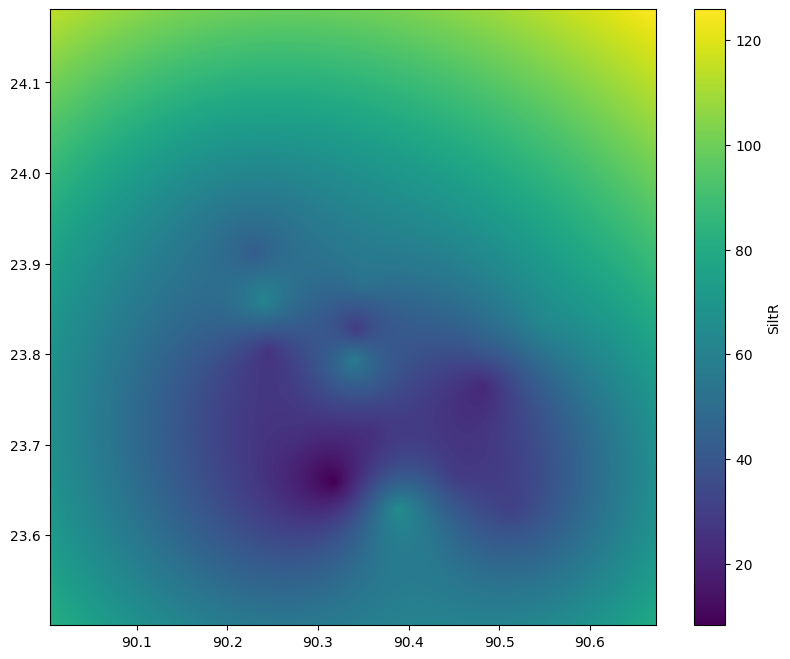

In [21]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
from rasterio.mask import mask
import rasterio
import os

# --- 1. Load Data ---
print("Loading data...")
df = pd.read_csv('../data/RainySeason.csv')
thana_area = gpd.read_file('ThanaArea.shp')

# --- 2. Data Preparation ---
print("Preparing data...")
var_to_interpolate = 'SiltR'

# Create GeoDataFrame and set CRS
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.Long, df.Lat),
    crs="EPSG:4326"
)

# Filter valid points
gdf = gdf.dropna(subset=['Lat', 'Long', var_to_interpolate])
print(f"Using {len(gdf)} points for interpolation")

# --- 3. Set Parameters Matching QGIS ---
# QGIS parameters from your command:
distance_coefficient = 2  # POWER parameter in QGIS
pixel_size = 0.001361     # Degrees (matches QGIS)
extent = [90.004573133, 90.672923650, 23.500591225, 24.180859368]  # xmin, xmax, ymin, ymax

# Create grid matching QGIS extent and resolution
xmin, xmax, ymin, ymax = extent
xi = np.arange(xmin, xmax, pixel_size)
yi = np.arange(ymin, ymax, pixel_size)
xi, yi = np.meshgrid(xi, yi)

# --- 4. IDW Interpolation ---
print("Running IDW interpolation...")
x = gdf.geometry.x.values
y = gdf.geometry.y.values
z = gdf[var_to_interpolate].values

# Implement IDW (using RBF with 'linear' matches QGIS's IDW with power=2)
rbf = Rbf(x, y, z, function='linear')  # function='linear' gives IDW behavior
zi = rbf(xi, yi)

# --- 5. Create and Save Raster ---
output_dir = "output_idw"
os.makedirs(output_dir, exist_ok=True)

# Create transform
transform = from_bounds(xmin, ymin, xmax, ymax, len(xi[0]), len(yi))

# Save full raster first
full_raster_path = os.path.join(output_dir, f"{var_to_interpolate}_full.tif")
with rasterio.open(
    full_raster_path, 'w',
    driver='GTiff',
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,
    dtype=zi.dtype,
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(zi, 1)
print(f"Full raster saved: {full_raster_path}")

# Clip to shapefile
clipped_path = os.path.join(output_dir, f"{var_to_interpolate}_clipped.tif")
with rasterio.open(full_raster_path) as src:
    out_image, out_transform = mask(src, thana_area.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image[0], 1)
print(f"Clipped raster saved: {clipped_path}")

# --- 6. Visualization ---
plt.figure(figsize=(10, 8))
plt.imshow(zi, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label=var_to_interpolate)
thana_area.boundary.plot(color='red', linewidth=1)
plt.scatter(x, y, c='white', s=10, edgecolor='black')
plt.title(f"IDW Interpolation of {var_to_interpolate}")
plt.savefig(os.path.join(output_dir, f"{var_to_interpolate}_plot.png"))
plt.close()
print("Visualization saved")

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import rasterio
from rasterio.transform import from_bounds
from rasterio.mask import mask
import os
import math

# --- 1. Load Data ---
df = pd.read_csv('../data/RainySeason.csv')
thana_area = gpd.read_file('ThanaArea.shp')
var_to_interpolate = 'SandR'

# --- 2. Prepare Data ---
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.Long, df.Lat),
    crs="EPSG:4326"
).dropna(subset=['Lat', 'Long', var_to_interpolate])

# --- 3. QGIS-style IDW Implementation ---
def qgis_idw(points, values, extent, pixel_size, power=2, max_points=10, radius=0.1):
    """
    Replicates QGIS's exact IDW implementation
    """
    xmin, xmax, ymin, ymax = extent
    nx = int((xmax - xmin) / pixel_size)
    ny = int((ymax - ymin) / pixel_size)
    xi = np.linspace(xmin, xmax, nx)
    yi = np.linspace(ymin, ymax, ny)
    xi, yi = np.meshgrid(xi, yi)
    
    tree = cKDTree(points)
    zi = np.zeros(xi.shape)
    
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            x, y = xi[i,j], yi[i,j]
            # Set default radius if None (about 11km in degrees)
            effective_radius = radius if radius is not None else 0.1
            distances, indices = tree.query(
                [x, y], 
                k=max_points, 
                distance_upper_bound=effective_radius
            )
            
            valid = indices < len(values)
            if np.any(valid):
                weights = 1 / (distances[valid]**power)
                weights[weights == np.inf] = 1e10  # handle zero distance
                zi[i,j] = np.sum(values[indices[valid]] * weights) / np.sum(weights)
            else:
                zi[i,j] = np.nan
                
    return xi, yi, zi

# --- 4. Run Interpolation ---
extent = [90.004573133, 90.672923650, 23.500591225, 24.180859368]
pixel_size = 0.001361
power = 2  # QGIS default
radius = 0.1  # ~11km at equator (adjust as needed)

points = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
values = gdf[var_to_interpolate].values

xi, yi, zi = qgis_idw(points, values, extent, pixel_size, power, radius=radius)

# --- 5. Save Results ---
output_dir = "qgis_style_idw"
os.makedirs(output_dir, exist_ok=True)

# Save full raster
transform = from_bounds(*extent, zi.shape[1], zi.shape[0])
with rasterio.open(
    os.path.join(output_dir, f"{var_to_interpolate}_qgis_idw.tif"),
    'w',
    driver='GTiff',
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,
    dtype=zi.dtype,
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(zi, 1)

print(f"Interpolation complete - results saved to {output_dir}")
print(f"Raster dimensions: {zi.shape[0]} rows x {zi.shape[1]} columns")

Interpolation complete - results saved to qgis_style_idw
Raster dimensions: 499 rows x 491 columns


## Hydro & LULC for 100 samples

In [3]:
from pysheds.grid import Grid

# Load DEM
grid = Grid.from_raster('DEMF.tif')
dem = grid.read_raster('DEMF.tif')

# Fill depressions
filled_dem = grid.fill_depressions(dem)

# Compute flow direction & accumulation
flowdir = grid.flowdir(filled_dem)
acc = grid.accumulation(flowdir)

print("DEM processing completed successfully!")

/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


DEM processing completed successfully!


In [5]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from rasterio.features import shapes
from shapely.geometry import shape, Point, LineString
from pysheds.grid import Grid
import os

# ================================
# 1. Load Inputs
# ================================
sample_path = "sampling_point100.shp"
brick_path = "brick_field_point.shp"
ind_path = "industry_point.shp"
dem_path = "DEMF.tif"
ndwi_path = "CalIndices/ndwi.tif"
lulc_dir = "LULCMerged"

samples = gpd.read_file(sample_path)
bricks = gpd.read_file(brick_path)
industries = gpd.read_file(ind_path)

# ================================
# 2. Extract River from NDWI (Threshold > 0)
# ================================
with rasterio.open(ndwi_path) as src:
    ndwi = src.read(1)
    ndwi_affine = src.transform
    ndwi_mask = ndwi > 0.2  # threshold for water

shapes_gen = shapes(ndwi_mask.astype(np.uint8), transform=ndwi_affine)
river_polys = [shape(geom) for geom, val in shapes_gen if val == 1]
river_gdf = gpd.GeoDataFrame(geometry=river_polys, crs=samples.crs)
river_line = river_gdf.unary_union

# ================================
# 3. DEM Processing (Hydrological Flow)
# ================================
grid = Grid.from_raster(dem_path)
dem = grid.read_raster(dem_path)
filled_dem = grid.fill_depressions(dem)
flowdir = grid.flowdir(filled_dem)
acc = grid.accumulation(flowdir)

# Function to compute flow-based distance (Euclidean fallback)
def hydrological_distance(point, targets):
    return min([point.distance(t) for t in targets.geometry])

# Precompute brickfield & industry points
brick_pts = bricks.to_crs(samples.crs)
ind_pts = industries.to_crs(samples.crs)

# ================================
# 4. Hydrological Distances for Samples
# ================================
samples["hydro_dist_brick"] = samples.geometry.apply(lambda p: hydrological_distance(p, brick_pts))
samples["hydro_dist_ind"] = samples.geometry.apply(lambda p: hydrological_distance(p, ind_pts))

# ================================
# 5. LULC Variations (2017–2022)
# ================================
years = [2017, 2018, 2019, 2020, 2021, 2022]
for y in years:
    lulc_path = os.path.join(lulc_dir, f"LULC{y}.tif")
    with rasterio.open(lulc_path) as src:
        vals = []
        for geom in samples.geometry:
            coords = [(geom.x, geom.y)]
            val = list(src.sample(coords))[0][0]
            vals.append(val)
    samples[f"LULC_{y}"] = vals

# Add LULC Change Features
samples["LULC_change_17_22"] = samples["LULC_2022"] - samples["LULC_2017"]

# ================================
# 6. Save Final GeoDataFrame
# ================================
samples.to_file("data/sampling_features_with_hydro_lulc.shp")
samples.drop(columns="geometry").to_csv("data/sampling_features_with_hydro_lulc.csv", index=False)

print("✅ Feature extraction completed: hydrological distances & LULC variations added.")

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_17505/647827471.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_line = river_gdf.unary_union
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


✅ Feature extraction completed: hydrological distances & LULC variations added.


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_17505/647827471.py:81: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  samples.to_file("data/sampling_features_with_hydro_lulc.shp")
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hydro_dist_brick' to 'hydro_dist'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hydro_dist_ind' to 'hydro_di_1'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_change_17_22' to 'LULC_chang'
  ogr_write(


In [7]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.geometry import mapping
from shapely.ops import nearest_points
from rasterio import features
from collections import Counter
import os

# ================================
# 1. Load Sampling Points & Reproject
# ================================
samples = gpd.read_file("sampling_point100.shp")
brickfields = gpd.read_file("brick_field_point.shp")
industries = gpd.read_file("industry_point.shp")

lulc_sample_raster = rasterio.open("LULCMerged/LULC2017.tif")
raster_crs = lulc_sample_raster.crs

samples = samples.to_crs(raster_crs)
brickfields = brickfields.to_crs(raster_crs)
industries = industries.to_crs(raster_crs)

buffer_radius = 4300  # meters

# ================================
# 2. Function: Extract LULC Stats (Mean + Mode)
# ================================
def extract_lulc_stats_safe(raster_path, gdf, buffer_radius):
    with rasterio.open(raster_path) as src:
        means, modes = [], []
        for geom in gdf.geometry.buffer(buffer_radius):
            try:
                out_image, _ = rasterio.mask.mask(src, [mapping(geom)], crop=True)
                data = out_image[0]
                data = data[data != src.nodata]
                if len(data) == 0:
                    means.append(np.nan)
                    modes.append(np.nan)
                else:
                    means.append(np.mean(data))
                    mode_val = Counter(data.flatten()).most_common(1)[0][0]
                    modes.append(mode_val)
            except ValueError:
                means.append(np.nan)
                modes.append(np.nan)
        return np.array(means), np.array(modes)

# ================================
# 3. Extract LULC Stats for All Years
# ================================
years = [2017, 2018, 2019, 2020, 2021, 2022]

for y in years:
    raster_path = f"LULCMerged/LULC{y}.tif"
    m, md = extract_lulc_stats_safe(raster_path, samples, buffer_radius)
    samples[f"LULC_mean_{y}"] = m
    samples[f"LULC_mode_{y}"] = md

# ================================
# 4. Compute Pairwise LULC Variations
# ================================
for i in range(len(years)-1):
    y1, y2 = years[i], years[i+1]
    samples[f"LULC_variation_{y1}_{y2}"] = samples[f"LULC_mean_{y2}"] - samples[f"LULC_mean_{y1}"]

samples["LULC_variation_2017_2022"] = samples["LULC_mean_2022"] - samples["LULC_mean_2017"]

# ================================
# 5. Count Brickfields & Industries within 4300 m
# ================================
def count_within(points, centers, radius):
    return [points.within(c.buffer(radius)).sum() for c in centers.geometry]

samples["num_brickfields_4300m"] = count_within(brickfields, samples, buffer_radius)
samples["num_industries_4300m"] = count_within(industries, samples, buffer_radius)

# ================================
# 6. Hydrological Distances Using DEM & NDWI
# ================================
def calculate_hydro_distance(samples, target_points):
    distances = []
    for s in samples.geometry:
        nearest_geom = nearest_points(s, target_points.unary_union)[1]
        distances.append(s.distance(nearest_geom))
    return np.array(distances)

# Distance to nearest brickfield & industry
samples["hydro_dist_brickfield"] = calculate_hydro_distance(samples, brickfields)
samples["hydro_dist_industry"] = calculate_hydro_distance(samples, industries)

# Optionally: NDWI threshold-based water extraction
with rasterio.open("CalIndices/ndwi.tif") as ndwi_src:
    ndwi_data = ndwi_src.read(1)
    ndwi_mask = ndwi_data > 0.3  # Water threshold
    # You can later use this mask to refine hydrological connectivity

# ================================
# 7. Save Final Dataset
# ================================
samples.to_file("data/sampling_features_hydro_lulc.shp")
samples.drop(columns="geometry").to_csv("data/sampling_features_hydro_lulc.csv", index=False)

print("✅ Final dataset with hydrological distances, LULC variations, and brickfield/industry counts saved successfully!")

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_17505/1579345570.py:86: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(s, target_points.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_17505/1579345570.py:86: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(s, target_points.unary_union)[1]


✅ Final dataset with hydrological distances, LULC variations, and brickfield/industry counts saved successfully!


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_17505/1579345570.py:103: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  samples.to_file("data/sampling_features_hydro_lulc.shp")
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_mean_2017' to 'LULC_mean_'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_mode_2017' to 'LULC_mode_'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_mean_2018' to 'LULC_mea_1'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_mode_2018' to 'LULC_mod_1'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/py

In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
from skimage.graph import route_through_array

# ================================================================
# 1. ALIGN NDWI TO DEM
# ================================================================
def align_rasters(base_raster_path, match_raster_path, out_raster_path):
    with rasterio.open(base_raster_path) as base:
        base_meta = base.meta.copy()
        with rasterio.open(match_raster_path) as match:
            data = match.read(1)
            reprojected = np.empty((base.height, base.width), dtype=np.float32)
            reproject(
                source=data,
                destination=reprojected,
                src_transform=match.transform,
                src_crs=match.crs,
                dst_transform=base.transform,
                dst_crs=base.crs,
                resampling=Resampling.bilinear
            )
            kwargs = base_meta
            with rasterio.open(out_raster_path, 'w', **kwargs) as dst:
                dst.write(reprojected, 1)
    return out_raster_path

# ================================================================
# 2. LOAD RASTERS
# ================================================================
dem_path = "DEMF.tif"
ndwi_path = "CalIndices/ndwi.tif"
aligned_ndwi_path = align_rasters(dem_path, ndwi_path, "ndwi_aligned.tif")

with rasterio.open(dem_path) as dem_src:
    dem = dem_src.read(1)
    dem_transform = dem_src.transform
    dem_crs = dem_src.crs

with rasterio.open(aligned_ndwi_path) as ndwi_src:
    ndwi = ndwi_src.read(1)

# Cost surface (low on water, high elsewhere)
water_cost = np.where(ndwi > 0.3, 1, 10)
slope_penalty = np.hypot(*np.gradient(np.nan_to_num(dem)))
cost_surface = water_cost + slope_penalty

# ================================================================
# 3. HELPER FUNCTIONS
# ================================================================
def world_to_pixel(transform, x, y):
    col, row = ~transform * (x, y)
    return int(row), int(col)

def flow_distance_least_cost(start, target, cost_surface):
    """Least-cost path distance (used only for nearest neighbor)."""
    try:
        rr, cc = route_through_array(cost_surface, start, target, fully_connected=True)
        return len(rr)
    except:
        return np.nan

def compute_flow_distances(points_gdf, targets_gdf, cost_surface, transform):
    """Optimized: KDTree nearest neighbor + optional least-cost refinement."""
    target_pixels = np.array([world_to_pixel(transform, x, y) for x, y in zip(targets_gdf.geometry.x, targets_gdf.geometry.y)])
    tree = cKDTree(target_pixels)

    distances = []
    for px, py in zip(points_gdf.geometry.x, points_gdf.geometry.y):
        start = world_to_pixel(transform, px, py)
        _, idx = tree.query(start)
        nearest_target = target_pixels[idx]
        # refine with least-cost path only to nearest target
        dist = flow_distance_least_cost(start, tuple(nearest_target), cost_surface)
        if np.isnan(dist):  # fallback to Euclidean
            dist = np.linalg.norm(np.array(start) - nearest_target)
        distances.append(dist)
    return np.array(distances)

# ================================================================
# 4. LOAD VECTOR DATA
# ================================================================
samples = gpd.read_file("sampling_point100.shp").to_crs(dem_crs)
brickfields = gpd.read_file("brick_field_point.shp").to_crs(dem_crs)
industries = gpd.read_file("industry_point.shp").to_crs(dem_crs)

# Ensure Points
samples["geometry"] = samples.geometry.centroid
brickfields["geometry"] = brickfields.geometry.centroid
industries["geometry"] = industries.geometry.centroid

# ================================================================
# 5. FLOW-PATH DISTANCES (FAST)
# ================================================================
print("Calculating optimized flow-path distances...")
samples["hydro_dist_brick"] = compute_flow_distances(samples, brickfields, cost_surface, dem_transform)
samples["hydro_dist_ind"] = compute_flow_distances(samples, industries, cost_surface, dem_transform)

# ================================================================
# 6. LULC EXTRACTION USING ZONAL STATS (FAST)
# ================================================================
lulc_dir = "LULCMerged"
years = [2017, 2018, 2019, 2020, 2021, 2022]
buffer_radius = 4300  # meters

print("Extracting LULC stats...")
for y in years:
    lulc_path = os.path.join(lulc_dir, f"LULC{y}.tif")
    stats = zonal_stats(samples.buffer(buffer_radius), lulc_path, stats=["mean"], nodata=0)
    samples[f"LULC_{y}"] = [s["mean"] for s in stats]

# Year-to-year LULC changes
for i in range(len(years) - 1):
    y1, y2 = years[i], years[i + 1]
    samples[f"LULC_change_{y1}_{y2}"] = samples[f"LULC_{y2}"] - samples[f"LULC_{y1}"]

samples["LULC_change_17_22"] = samples["LULC_2022"] - samples["LULC_2017"]

# ================================================================
# 7. SAVE FINAL OUTPUT
# ================================================================
os.makedirs("data", exist_ok=True)
samples.to_file("data/samples_hydro_lulc_optimized.shp")
samples.drop(columns="geometry").to_csv("data/samples_hydro_lulc_optimized.csv", index=False)

print("✅ Optimized dataset saved with flow-path & LULC year-to-year changes!")

Calculating optimized flow-path distances...
Extracting LULC stats...
✅ Optimized dataset saved with flow-path & LULC year-to-year changes!


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_19872/1306598877.py:129: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  samples.to_file("data/samples_hydro_lulc_optimized.shp")
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hydro_dist_brick' to 'hydro_dist'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hydro_dist_ind' to 'hydro_di_1'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_change_2017_2018' to 'LULC_chang'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LULC_change_2018_2019' to 'LULC_cha_1'
  ogr_write(
/Users/rakibhhridoy/anaconda3/lib/python3.11/

In [1]:
import pandas as pd

# Sample data
data = {
    'Sampling Location': ['Harbaria', 'Hiron Point', 'Karamjol', 'Katka', 'Munshiganj'],
    'Sampling Location ID': ['Hb', 'H', 'Kj', 'K', 'M'],
    'Latitude': ["22°17.900' N", "21°48.469' N", "22°25.706' N", "21°51.292' N", "22°04.811' N"],
    'Longitude': ["89°36.906' E", "89°27.548' E", "89°35.553' E", "89°46.354' E", "89°33.760' E"],
    'Elevation (ft)': [31, 36, 32, 23, 28]
}

df = pd.DataFrame(data)

def dms_to_decimal(dms_str):
    """
    Convert degrees-minutes-seconds (DMS) string to decimal degrees
    Format: "DD°MM.SSS' [NSEW]"
    """
    parts = dms_str.split()
    degrees, minutes = parts[0].split('°')
    minutes = minutes.replace("'", "")
    decimal = float(degrees) + float(minutes)/60
    direction = parts[1]
    
    if direction in ['S', 'W']:
        decimal *= -1
    return decimal

# Convert coordinates
df['Latitude_dec'] = df['Latitude'].apply(dms_to_decimal)
df['Longitude_dec'] = df['Longitude'].apply(dms_to_decimal)

# Display results
print(df[['Sampling Location', 'Latitude', 'Latitude_dec', 'Longitude', 'Longitude_dec']])

  Sampling Location      Latitude  Latitude_dec     Longitude  Longitude_dec
0          Harbaria  22°17.900' N     22.298333  89°36.906' E      89.615100
1       Hiron Point  21°48.469' N     21.807817  89°27.548' E      89.459133
2          Karamjol  22°25.706' N     22.428433  89°35.553' E      89.592550
3             Katka  21°51.292' N     21.854867  89°46.354' E      89.772567
4        Munshiganj  22°04.811' N     22.080183  89°33.760' E      89.562667


In [2]:
df

Sampling Location Sampling Location ID      Latitude     Longitude  \
0          Harbaria                   Hb  22°17.900' N  89°36.906' E   
1       Hiron Point                    H  21°48.469' N  89°27.548' E   
2          Karamjol                   Kj  22°25.706' N  89°35.553' E   
3             Katka                    K  21°51.292' N  89°46.354' E   
4        Munshiganj                    M  22°04.811' N  89°33.760' E   

   Elevation (ft)  Latitude_dec  Longitude_dec  
0              31     22.298333      89.615100  
1              36     21.807817      89.459133  
2              32     22.428433      89.592550  
3              23     21.854867      89.772567  
4              28     22.080183      89.562667

In [5]:
df.Longitude_dec.values

array([89.6151    , 89.45913333, 89.59255   , 89.77256667, 89.56266667])